In [1]:
!pip install seaborn==0.9.0
!pip install allennlp==0.8.5
!pip install matplotlib
!pip install numpy 
!pip install ray

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt


from datetime import datetime
from typing import Dict, List

from allennlp.common import Params
from allennlp.common.util import import_submodules

from experiments.utils import (get_args, quantify_exposure_bias_runner, run,
                  sample_oracle_runner, train_runner)
from pprint import pprint
import_submodules("quant_exp_bias")


## Basic Setup of grammar and global variables like serialization directory and training config file

In [3]:
FSA_GRAMMAR_STRING = """
                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]
                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]
                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]
                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]
                    """
    
os.environ["FSA_GRAMMAR_STRING"] = FSA_GRAMMAR_STRING
os.environ['ARTIFICIAL_GRAMMAR_TRAIN'] = ""
os.environ['ARTIFICIAL_GRAMMAR_DEV'] = ""

dataset_experiments_params = [(6250,16), (12500,8) , (25000, 4), (50000,2), (100000,1)]

num_sample_oracles = 10
num_trials = 10
num_samples_per_length=1000

# Ipython by default adds some arguments to sys.argv.
#  We don't want those arguments, hence we pass [] here.
#
# The deafult argument get_args is args=None. 
# This translates to parsing sys.argv. This is useful
# in case we run the method from a python file but not here.
# Hence, we keep the default argument as None but pass [] for 
# ipython notebook.
main_args = get_args(args=[])

serialization_dir = os.path.join(main_args.output_dir, datetime.now().strftime("%m_%d_%Y_%H_%M_%S"))
param_path = main_args.config

# Dataset Experiments

In [3]:
# Setup variables needed later.
dataset_exp_results = {}
for num_samples, _ in dataset_experiments_params:
    dataset_exp_results[num_samples] = []
    
orig_serialization_dir = serialization_dir
for num_samples, num_runs in dataset_experiments_params:
    dexp_serialization_dir = os.path.join(orig_serialization_dir, 'dataset_experiments', str(num_samples))
    for num_run in range(num_runs):
        serialization_dir = os.path.join(dexp_serialization_dir, str(num_run))
        sample_oracle_args = get_args(args=['sample-oracle', param_path, '-s', serialization_dir, '-n', str(num_samples)])
        oracle_train_filename, oracle_dev_filename = \
                                    sample_oracle_runner(sample_oracle_args, 
                                                        serialization_dir);

        os.environ['ARTIFICIAL_GRAMMAR_TRAIN'] = oracle_train_filename
        os.environ['ARTIFICIAL_GRAMMAR_DEV'] = oracle_dev_filename

        train_args = get_args(args=['train' , param_path, '-s', serialization_dir])
        trainer_params = Params.from_file(train_args.param_path, train_args.overrides)
        cuda_device = trainer_params['trainer']['cuda_device']
        train_model_serialization_dir = train_runner(train_args, 
                                                    serialization_dir);

        archive_file = os.path.join(train_model_serialization_dir, 'model.tar.gz')
        qeb_output_dir = os.path.join(serialization_dir, 'exp_bias')

        qeb_args = get_args(args=['quantify-exposure-bias', archive_file, '--output-dir', qeb_output_dir])
        exp_biases, exp_bias_mean, exp_bias_std = quantify_exposure_bias_runner(qeb_args, 
                                                                                archive_file,
                                                                                qeb_output_dir,
                                                                                cuda_device=cuda_device, 
                                                                                num_trials=num_trials,
                                                                                num_samples_per_length=num_samples_per_length)
        dataset_exp_results[num_samples].extend(exp_biases)


2019-10-10 22:16:18,816 - INFO - allennlp.common.params - random_seed = 13370
2019-10-10 22:16:18,817 - INFO - allennlp.common.params - numpy_seed = 1337
2019-10-10 22:16:18,818 - INFO - allennlp.common.params - pytorch_seed = 133
2019-10-10 22:16:20,800 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-10 22:16:20,803 - INFO - quant_exp_bias.commands.sample_oracle - Num Samples: 1000
2019-10-10 22:16:20,830 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025

2019-10-10 22:16:27,719 - INFO - allennlp.common.params - vocabulary.min_pretrained_embeddings = None
2019-10-10 22:16:27,719 - INFO - allennlp.common.params - vocabulary.only_include_pretrained_words = False
2019-10-10 22:16:27,720 - INFO - allennlp.common.params - vocabulary.tokens_to_add = None
2019-10-10 22:16:27,721 - INFO - allennlp.data.vocabulary - Fitting token dictionary from dataset.
0it [00:00, ?it/s]
2019-10-10 22:16:27,723 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-train.txt
2019-10-10 22:16:27,987 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-train.txt.
2019-10-10 22:16:27,988 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100

2019-10-10 22:16:28,085 - INFO - allennlp.training.trainer_pieces - _target_embedder.weight
2019-10-10 22:16:28,086 - INFO - allennlp.training.trainer_pieces - _decoder_cell.weight_ih
2019-10-10 22:16:28,087 - INFO - allennlp.training.trainer_pieces - _decoder_cell.weight_hh
2019-10-10 22:16:28,087 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_ih
2019-10-10 22:16:28,088 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_hh
2019-10-10 22:16:28,089 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.weight
2019-10-10 22:16:28,090 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.bias
2019-10-10 22:16:28,090 - INFO - allennlp.common.params - trainer.patience = 10
2019-10-10 22:16:28,091 - INFO - allennlp.common.params - trainer.validation_metric = -loss
2019-10-10 22:16:28,092 - INFO - allennlp.common.params - trainer.shuffle = True
2019-10-10 22:16:28,093 - INFO - allennlp.common.params - trainer.num_epochs = 50
2019-10-10 

2019-10-10 22:16:38,099 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2541
2019-10-10 22:16:38,101 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 4565
2019-10-10 22:16:38,103 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:16:38,107 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-train.txt
2019-10-10 22:16:38,330 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:16:38,791 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-train.txt.
perplexity: 3.5606, loss: 1.2699 ||: : 4it [00:00,  5.11it/s]

2019-10-10 22:16:38,892 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:16:38,89

2019-10-10 22:16:42,519 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:16:42,968 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-train.txt.
perplexity: 3.0136, loss: 1.1031 ||: : 4it [00:00,  5.25it/s]

2019-10-10 22:16:43,061 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:16:43,064 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-dev.txt
2019-10-10 22:16:43,123 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-dev.txt.
perplexity: 2.9722, loss: 1.0893 ||: 100%|##########| 1/1 [00:00<00:00,  9.42it/s]

2019-10-10 22:16:4

2019-10-10 22:16:47,154 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-dev.txt.
perplexity: 2.9673, loss: 1.0876 ||: 100%|##########| 1/1 [00:00<00:00,  9.88it/s]

2019-10-10 22:16:47,198 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:16:47,200 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1885.000  |       N/A
2019-10-10 22:16:47,201 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:16:47,202 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2051.000  |       N/A
2019-10-10 22:16:47,204 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.002  |     2.967
2019-10-10 22:16:47,206 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |   789.000  |       N/A
2019-10-10 22:16:47,207 - IN

2019-10-10 22:16:51,300 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  4285.000  |       N/A
2019-10-10 22:16:51,302 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:16:51,303 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4227.000  |       N/A
2019-10-10 22:16:51,305 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.011  |     2.961
2019-10-10 22:16:51,306 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |   789.000  |       N/A
2019-10-10 22:16:51,308 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:16:51,309 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2598.528  |       N/A
2019-10-10 22:16:51,310 - INFO - allennlp.training.tensorboard_writer - loss            |     1.102  |     1.086
2019-10-10 22:16:51,312 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.

2019-10-10 22:16:55,369 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.002  |     2.961
2019-10-10 22:16:55,371 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |   789.000  |       N/A
2019-10-10 22:16:55,372 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:16:55,373 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2598.528  |       N/A
2019-10-10 22:16:55,374 - INFO - allennlp.training.tensorboard_writer - loss            |     1.099  |     1.085
2019-10-10 22:16:55,376 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.000  |       N/A
2019-10-10 22:16:55,378 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:16:55,379 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:16:55,404 - INFO - allennlp.training.checkpointer - Best validation performance so

2019-10-10 22:16:58,377 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2598.528  |       N/A
2019-10-10 22:16:58,378 - INFO - allennlp.training.tensorboard_writer - loss            |     1.100  |     1.085
2019-10-10 22:16:58,379 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.000  |       N/A
2019-10-10 22:16:58,381 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:16:58,382 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:16:58,406 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/train_output/best.th'.
2019-10-10 22:16:58,415 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.760790
2019-10-10 22:16:58,416 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:14
2019-10-10 22:16:58,

2019-10-10 22:17:02,315 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:17:02,316 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:17:02,342 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/train_output/best.th'.
2019-10-10 22:17:02,352 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.962857
2019-10-10 22:17:02,353 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:10
2019-10-10 22:17:02,354 - INFO - allennlp.training.trainer - Epoch 14/49
2019-10-10 22:17:02,356 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2598.528
2019-10-10 22:17:03,278 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:17:03,280 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:1

2019-10-10 22:17:06,309 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.143845
2019-10-10 22:17:06,311 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:06
2019-10-10 22:17:06,312 - INFO - allennlp.training.trainer - Epoch 16/49
2019-10-10 22:17:06,313 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2598.528
2019-10-10 22:17:07,277 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:17:07,280 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:17:07,281 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7467
2019-10-10 22:17:07,282 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6929
2019-10-10 22:17:07,284 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:17:07,285 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 789
2019-10-10 22:17:07,286 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2009
2019-10-10 22:17:0

2019-10-10 22:17:11,163 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:17:11,165 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:17:11,167 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7467
2019-10-10 22:17:11,168 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6929
2019-10-10 22:17:11,169 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:17:11,170 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 789
2019-10-10 22:17:11,172 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3565
2019-10-10 22:17:11,173 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2011
2019-10-10 22:17:11,174 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:17:11,177 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_sam

2019-10-10 22:17:14,957 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2231
2019-10-10 22:17:14,959 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:17:14,961 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-train.txt
2019-10-10 22:17:15,173 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:17:15,629 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-train.txt.
perplexity: 3.0003, loss: 1.0987 ||: : 4it [00:00,  5.30it/s]

2019-10-10 22:17:15,716 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:17:15,718 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/a


2019-10-10 22:17:19,078 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:17:19,081 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-dev.txt
2019-10-10 22:17:19,137 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-dev.txt.
perplexity: 2.9604, loss: 1.0853 ||: 100%|##########| 1/1 [00:00<00:00, 10.02it/s]

2019-10-10 22:17:19,182 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:17:19,183 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2049.000  |       N/A
2019-10-10 22:17:19,185 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:17:19,186 - INFO - allennlp.training.tensor

2019-10-10 22:17:23,344 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:17:23,346 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1871.000  |       N/A
2019-10-10 22:17:23,347 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.996  |     2.960
2019-10-10 22:17:23,348 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |   789.000  |       N/A
2019-10-10 22:17:23,349 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:17:23,351 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2598.528  |       N/A
2019-10-10 22:17:23,352 - INFO - allennlp.training.tensorboard_writer - loss            |     1.097  |     1.085
2019-10-10 22:17:23,353 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.000  |       N/A
2019-10-10 22:17:23,355 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.

2019-10-10 22:17:27,302 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2599.128  |       N/A
2019-10-10 22:17:27,303 - INFO - allennlp.training.tensorboard_writer - loss            |     1.095  |     1.085
2019-10-10 22:17:27,305 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.000  |       N/A
2019-10-10 22:17:27,306 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:17:27,308 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:17:27,335 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.026551
2019-10-10 22:17:27,336 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:44
2019-10-10 22:17:27,337 - INFO - allennlp.training.trainer - Epoch 27/49
2019-10-10 22:17:27,339 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2599.128
2019-10-10 22:17:28,419 - INFO - allennlp.training.trainer - GPU 0 mem

2019-10-10 22:17:31,425 - INFO - allennlp.training.trainer - Epoch 29/49
2019-10-10 22:17:31,426 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2599.128
2019-10-10 22:17:32,297 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:17:32,299 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:17:32,300 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7467
2019-10-10 22:17:32,301 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6929
2019-10-10 22:17:32,303 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:17:32,304 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 789
2019-10-10 22:17:32,305 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2137
2019-10-10 22:17:32,306 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2169
2019-10-10 22:17:32,308 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:17:

2019-10-10 22:17:35,874 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3901
2019-10-10 22:17:35,876 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:17:35,879 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-train.txt
2019-10-10 22:17:36,082 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:17:36,522 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-train.txt.
perplexity: 2.9999, loss: 1.0986 ||: : 4it [00:00,  5.49it/s]

2019-10-10 22:17:36,610 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:17:36,612 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/a


2019-10-10 22:17:40,868 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:17:40,871 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-dev.txt
2019-10-10 22:17:40,928 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-dev.txt.
perplexity: 2.9604, loss: 1.0853 ||: 100%|##########| 1/1 [00:00<00:00, 10.29it/s]

2019-10-10 22:17:40,970 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:17:40,972 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1883.000  |       N/A
2019-10-10 22:17:40,973 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:17:40,975 - INFO - allennlp.training.tensor


2019-10-10 22:17:44,682 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:17:44,683 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  3747.000  |       N/A
2019-10-10 22:17:44,684 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:17:44,685 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2115.000  |       N/A
2019-10-10 22:17:44,687 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.998  |     2.960
2019-10-10 22:17:44,689 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |   789.000  |       N/A
2019-10-10 22:17:44,690 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:17:44,691 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2599.128  |       N/A
2019-10-10 22:17:44,693 - INFO - allennlp.training.tensorboard_writer - loss            |    

2019-10-10 22:17:48,937 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2599.128  |       N/A
2019-10-10 22:17:48,939 - INFO - allennlp.training.tensorboard_writer - loss            |     1.100  |     1.085
2019-10-10 22:17:48,940 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.000  |       N/A
2019-10-10 22:17:48,942 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:17:48,943 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:17:48,968 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.056497
2019-10-10 22:17:48,970 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:23
2019-10-10 22:17:48,971 - INFO - allennlp.training.trainer - Epoch 38/49
2019-10-10 22:17:48,971 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2599.128
2019-10-10 22:17:50,121 - INFO - allennlp.training.trainer - GPU 0 mem

2019-10-10 22:17:53,239 - INFO - allennlp.training.trainer - Epoch 40/49
2019-10-10 22:17:53,240 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2599.132
2019-10-10 22:17:54,383 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:17:54,386 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:17:54,387 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7467
2019-10-10 22:17:54,388 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6929
2019-10-10 22:17:54,390 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:17:54,391 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 789
2019-10-10 22:17:54,392 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3681
2019-10-10 22:17:54,393 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2787
2019-10-10 22:17:54,394 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:17:

2019-10-10 22:17:58,560 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 789
2019-10-10 22:17:58,562 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2023
2019-10-10 22:17:58,563 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3043
2019-10-10 22:17:58,564 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:17:58,567 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-train.txt
2019-10-10 22:17:58,759 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:17:59,384 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-train.txt.
perplexity: 2.9963, loss: 1.0974 ||: : 4it [00:00,  4.35it/s]

2019-10-10 22:17:59,488 - INFO - allennlp.tr

perplexity: 2.9939, loss: 1.0966 ||: : 4it [00:00,  5.31it/s]

2019-10-10 22:18:03,329 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:18:03,331 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-dev.txt
2019-10-10 22:18:03,388 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/0/oracle_samples-dev.txt.
perplexity: 2.9604, loss: 1.0853 ||: 100%|##########| 1/1 [00:00<00:00, 10.04it/s]

2019-10-10 22:18:03,433 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:18:03,435 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1997.000  |       N/A
2019-10-10 22:18:03,436 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6827.000  |      

perplexity: 2.9604, loss: 1.0853 ||: 100%|##########| 1/1 [00:00<00:00, 13.73it/s]

2019-10-10 22:18:06,715 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:18:06,716 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2035.000  |       N/A
2019-10-10 22:18:06,718 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6827.000  |       N/A
2019-10-10 22:18:06,719 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2405.000  |       N/A
2019-10-10 22:18:06,721 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.005  |     2.960
2019-10-10 22:18:06,722 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |   789.000  |       N/A
2019-10-10 22:18:06,724 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:18:06,725 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2599.140  |       N/A
2019-10-10

2019-10-10 22:18:10,304 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:18:10,306 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2599.140  |       N/A
2019-10-10 22:18:10,308 - INFO - allennlp.training.tensorboard_writer - loss            |     1.097  |     1.085
2019-10-10 22:18:10,309 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7477.000  |       N/A
2019-10-10 22:18:10,310 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6003.000  |       N/A
2019-10-10 22:18:10,312 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:18:10,338 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.656449
2019-10-10 22:18:10,339 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:01
2019-10-10 22:18:10,340 - INFO - allennlp.training.trainer - Epoch 49/49
2019-10-10 22:18:10,341 - INFO - allennlp.training.tr

2019-10-10 22:18:12,216 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras {'vocab'}
2019-10-10 22:18:12,217 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' 


2019-10-10 22:18:22,053 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'type': 'quant_exp_lm', 'use_bleu': False} and extras {'vocab'}
2019-10

2019-10-10 22:18:23,940 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7477.000  |       N/A
2019-10-10 22:18:23,942 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6939.000  |       N/A
2019-10-10 22:18:23,943 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:18:23,966 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/1/train_output/best.th'.
2019-10-10 22:18:23,975 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.884011
2019-10-10 22:18:23,976 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:32
2019-10-10 22:18:23,977 - INFO - allennlp.training.trainer - Epoch 1/49
2019-10-10 22:18:23,978 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2609.308
2019-10-10 22:18:25,108 - INFO - allennlp.training.trainer - GPU 0 memory usag

2019-10-10 22:18:28,044 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/1/train_output/best.th'.
2019-10-10 22:18:28,054 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.985995
2019-10-10 22:18:28,055 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:33
2019-10-10 22:18:28,056 - INFO - allennlp.training.trainer - Epoch 3/49
2019-10-10 22:18:28,057 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2609.316
2019-10-10 22:18:29,093 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7851
2019-10-10 22:18:29,096 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:18:29,097 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7477
2019-10-10 22:18:29,099 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6939
2019-10-10 22:18:29,100 - INFO - allennlp.training.trainer - GPU

2019-10-10 22:18:31,905 - INFO - allennlp.training.trainer - Epoch 5/49
2019-10-10 22:18:31,906 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2609.316
2019-10-10 22:18:32,981 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7851
2019-10-10 22:18:32,983 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:18:32,984 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7477
2019-10-10 22:18:32,986 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6939
2019-10-10 22:18:32,987 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:18:32,988 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:18:32,989 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3115
2019-10-10 22:18:32,990 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2645
2019-10-10 22:18:32,991 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:18:

2019-10-10 22:18:37,156 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7477
2019-10-10 22:18:37,158 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6939
2019-10-10 22:18:37,159 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:18:37,160 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:18:37,161 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1889
2019-10-10 22:18:37,162 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1989
2019-10-10 22:18:37,163 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:18:37,165 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/1/oracle_samples-train.txt
2019-10-10 22:18:37,422 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:18:37,905 - INFO - quant_exp_bias.dat

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:18:41,160 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/1/oracle_samples-train.txt
2019-10-10 22:18:41,402 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:18:42,027 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/1/oracle_samples-train.txt.
perplexity: 2.9896, loss: 1.0951 ||: : 4it [00:00,  4.19it/s]

2019-10-10 22:18:42,117 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:18:42,120 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/1/oracle_samples-dev.txt
2019-10-10 22:18:42,172 - INFO - quant_exp_bias.dataset_readers.languag

2019-10-10 22:18:46,233 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/1/oracle_samples-dev.txt.
perplexity: 2.9730, loss: 1.0896 ||: 100%|##########| 1/1 [00:00<00:00, 11.18it/s]

2019-10-10 22:18:46,267 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:18:46,268 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1809.000  |       N/A
2019-10-10 22:18:46,270 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7851.000  |       N/A
2019-10-10 22:18:46,271 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1999.000  |       N/A
2019-10-10 22:18:46,273 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.991  |     2.973
2019-10-10 22:18:46,274 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:18:46,276 - IN

2019-10-10 22:18:49,861 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:18:49,863 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:18:49,864 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2609.340  |       N/A
2019-10-10 22:18:49,866 - INFO - allennlp.training.tensorboard_writer - loss            |     1.094  |     1.090
2019-10-10 22:18:49,867 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7477.000  |       N/A
2019-10-10 22:18:49,869 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6939.000  |       N/A
2019-10-10 22:18:49,871 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:18:49,897 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.017312
2019-10-10 22:18:49,899 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:11
2019-10-10 22

2019-10-10 22:18:54,280 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.121022
2019-10-10 22:18:54,282 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:08
2019-10-10 22:18:54,283 - INFO - allennlp.training.trainer - Epoch 16/49
2019-10-10 22:18:54,284 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2609.34
2019-10-10 22:18:55,403 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7851
2019-10-10 22:18:55,406 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:18:55,407 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7477
2019-10-10 22:18:55,408 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6939
2019-10-10 22:18:55,410 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:18:55,411 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:18:55,412 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2521
2019-10-10 22:18:5

2019-10-10 22:18:58,675 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

2019-10-10 22:19:09,043 - INFO - allennlp.data.vocabulary - Fitting token dictionary from dataset.
0it [00:00, ?it/s]
2019-10-10 22:19:09,045 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-train.txt
2019-10-10 22:19:09,394 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-train.txt.
2019-10-10 22:19:09,395 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-dev.txt
2019-10-10 22:19:09,436 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-dev.txt.
1000it [00:00, 2550.41it/s]

2019-10-10 22:19:09,438 - INFO - al


2019-10-10 22:19:11,568 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:19:11,569 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2511.000  |       N/A
2019-10-10 22:19:11,571 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7851.000  |       N/A
2019-10-10 22:19:11,572 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2699.000  |       N/A
2019-10-10 22:19:11,574 - INFO - allennlp.training.tensorboard_writer - perplexity      |     6.551  |     4.344
2019-10-10 22:19:11,575 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:19:11,577 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:19:11,578 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2615.132  |       N/A
2019-10-10 22:19:11,580 - INFO - allennlp.training.tensorboard_writer - loss            |    

2019-10-10 22:19:15,728 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  3229.000  |       N/A
2019-10-10 22:19:15,730 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.053  |     2.944
2019-10-10 22:19:15,731 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:19:15,733 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:19:15,734 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2616.152  |       N/A
2019-10-10 22:19:15,735 - INFO - allennlp.training.tensorboard_writer - loss            |     1.116  |     1.080
2019-10-10 22:19:15,737 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7477.000  |       N/A
2019-10-10 22:19:15,738 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6939.000  |       N/A
2019-10-10 22:19:15,739 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:19:20,057 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:19:20,059 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2616.152  |       N/A
2019-10-10 22:19:20,061 - INFO - allennlp.training.tensorboard_writer - loss            |     1.096  |     1.069
2019-10-10 22:19:20,062 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7477.000  |       N/A
2019-10-10 22:19:20,064 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6939.000  |       N/A
2019-10-10 22:19:20,065 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:19:20,094 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/train_output/best.th'.
2019-10-10 22:19:20,105 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.219793
2019-10-10 

2019-10-10 22:19:24,112 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7477.000  |       N/A
2019-10-10 22:19:24,114 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6939.000  |       N/A
2019-10-10 22:19:24,115 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:19:24,141 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/train_output/best.th'.
2019-10-10 22:19:24,152 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.840410
2019-10-10 22:19:24,153 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:30
2019-10-10 22:19:24,154 - INFO - allennlp.training.trainer - Epoch 7/49
2019-10-10 22:19:24,155 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2616.152
2019-10-10 22:19:25,347 - INFO - allennlp.training.trainer - GPU 0 memory usag

2019-10-10 22:19:28,337 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/train_output/best.th'.
2019-10-10 22:19:28,347 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.041812
2019-10-10 22:19:28,348 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:25
2019-10-10 22:19:28,349 - INFO - allennlp.training.trainer - Epoch 9/49
2019-10-10 22:19:28,350 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2616.156
2019-10-10 22:19:29,436 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7851
2019-10-10 22:19:29,438 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:19:29,439 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7477
2019-10-10 22:19:29,440 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6939
2019-10-10 22:19:29,442 - INFO - allennlp.training.trainer - GPU

2019-10-10 22:19:32,693 - INFO - allennlp.training.trainer - Epoch 11/49
2019-10-10 22:19:32,694 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2616.156
2019-10-10 22:19:33,787 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7851
2019-10-10 22:19:33,790 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:19:33,791 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7477
2019-10-10 22:19:33,793 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6939
2019-10-10 22:19:33,794 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:19:33,795 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:19:33,796 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1873
2019-10-10 22:19:33,798 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 4441
2019-10-10 22:19:33,799 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:19

2019-10-10 22:19:37,613 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7477
2019-10-10 22:19:37,614 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6939
2019-10-10 22:19:37,615 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:19:37,616 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:19:37,618 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2543
2019-10-10 22:19:37,619 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1971
2019-10-10 22:19:37,621 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:19:37,624 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-train.txt
2019-10-10 22:19:37,852 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:19:38,341 - INFO - quant_exp_bias.dat

2019-10-10 22:19:41,958 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2137
2019-10-10 22:19:41,959 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1989
2019-10-10 22:19:41,960 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:19:41,963 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-train.txt
2019-10-10 22:19:42,189 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:19:42,702 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-train.txt.
perplexity: 2.9977, loss: 1.0978 ||: : 4it [00:00,  4.82it/s]

2019-10-10 22:19:42,795 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:19:42,79

2019-10-10 22:19:46,095 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:19:46,570 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-train.txt.
perplexity: 2.9954, loss: 1.0971 ||: : 4it [00:00,  5.12it/s]

2019-10-10 22:19:46,660 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:19:46,661 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-dev.txt
2019-10-10 22:19:46,721 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-dev.txt.
perplexity: 2.9071, loss: 1.0672 ||: 100%|##########| 1/1 [00:00<00:00, 10.11it/s]

2019-10-10 22:19:4

2019-10-10 22:19:50,187 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-dev.txt.
perplexity: 2.9071, loss: 1.0672 ||: 100%|##########| 1/1 [00:00<00:00, 11.12it/s]

2019-10-10 22:19:50,226 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:19:50,227 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1919.000  |       N/A
2019-10-10 22:19:50,228 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6571.000  |       N/A
2019-10-10 22:19:50,229 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4543.000  |       N/A
2019-10-10 22:19:50,230 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.991  |     2.907
2019-10-10 22:19:50,232 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:19:50,233 - IN

2019-10-10 22:19:54,591 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1959.000  |       N/A
2019-10-10 22:19:54,592 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.001  |     2.907
2019-10-10 22:19:54,593 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:19:54,595 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:19:54,596 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2616.156  |       N/A
2019-10-10 22:19:54,598 - INFO - allennlp.training.tensorboard_writer - loss            |     1.099  |     1.067
2019-10-10 22:19:54,599 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7473.000  |       N/A
2019-10-10 22:19:54,601 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  4987.000  |       N/A
2019-10-10 22:19:54,602 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:19:58,322 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  5811.000  |       N/A
2019-10-10 22:19:58,323 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:19:58,346 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.105783
2019-10-10 22:19:58,347 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:52
2019-10-10 22:19:58,348 - INFO - allennlp.training.trainer - Epoch 24/49
2019-10-10 22:19:58,349 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2616.156
2019-10-10 22:19:59,108 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6571
2019-10-10 22:19:59,110 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:19:59,112 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7473
2019-10-10 22:19:59,113 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 5989
2019-10-10 22:19:59,114 - INFO - allennlp.training.train

2019-10-10 22:20:02,180 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7473
2019-10-10 22:20:02,182 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6925
2019-10-10 22:20:02,183 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:20:02,184 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:20:02,185 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4193
2019-10-10 22:20:02,187 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3059
2019-10-10 22:20:02,188 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:20:02,191 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-train.txt
2019-10-10 22:20:02,403 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:20:02,900 - INFO - quant_exp_bias.dat

2019-10-10 22:20:05,902 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:20:06,524 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-train.txt.
perplexity: 2.9928, loss: 1.0962 ||: : 4it [00:00,  4.21it/s]

2019-10-10 22:20:06,619 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:20:06,621 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-dev.txt
2019-10-10 22:20:06,679 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-dev.txt.
perplexity: 2.9071, loss: 1.0672 ||: 100%|##########| 1/1 [00:00<00:00, 10.17it/s]

2019-10-10 22:20:0

2019-10-10 22:20:10,233 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-dev.txt.
perplexity: 2.9071, loss: 1.0672 ||: 100%|##########| 1/1 [00:00<00:00,  9.41it/s]

2019-10-10 22:20:10,284 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:20:10,285 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2337.000  |       N/A
2019-10-10 22:20:10,287 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:20:10,289 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4295.000  |       N/A
2019-10-10 22:20:10,291 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.994  |     2.907
2019-10-10 22:20:10,293 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:20:10,294 - IN

2019-10-10 22:20:13,632 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:20:13,634 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:20:13,635 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2616.156  |       N/A
2019-10-10 22:20:13,636 - INFO - allennlp.training.tensorboard_writer - loss            |     1.101  |     1.067
2019-10-10 22:20:13,638 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7473.000  |       N/A
2019-10-10 22:20:13,640 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6925.000  |       N/A
2019-10-10 22:20:13,641 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:20:13,663 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.283362
2019-10-10 22:20:13,664 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:33
2019-10-10 22

2019-10-10 22:20:17,790 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6925.000  |       N/A
2019-10-10 22:20:17,791 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:20:17,812 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.013345
2019-10-10 22:20:17,813 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:29
2019-10-10 22:20:17,814 - INFO - allennlp.training.trainer - Epoch 35/49
2019-10-10 22:20:17,815 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2616.156
2019-10-10 22:20:18,853 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:20:18,855 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:20:18,856 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7473
2019-10-10 22:20:18,858 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6925
2019-10-10 22:20:18,859 - INFO - allennlp.training.train

2019-10-10 22:20:22,933 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:20:22,935 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:20:22,937 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7473
2019-10-10 22:20:22,938 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6925
2019-10-10 22:20:22,939 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:20:22,941 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:20:22,942 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1881
2019-10-10 22:20:22,944 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1977
2019-10-10 22:20:22,945 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:20:22,948 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_sa

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:20:26,999 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-train.txt
2019-10-10 22:20:27,218 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:20:27,704 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-train.txt.
perplexity: 2.9879, loss: 1.0946 ||: : 4it [00:00,  5.02it/s]

2019-10-10 22:20:27,798 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:20:27,801 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-dev.txt
2019-10-10 22:20:27,855 - INFO - quant_exp_bias.dataset_readers.languag

2019-10-10 22:20:31,145 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-dev.txt.
perplexity: 2.9071, loss: 1.0672 ||: 100%|##########| 1/1 [00:00<00:00, 10.08it/s]

2019-10-10 22:20:31,187 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:20:31,188 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  3029.000  |       N/A
2019-10-10 22:20:31,190 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:20:31,191 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2341.000  |       N/A
2019-10-10 22:20:31,193 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.001  |     2.907
2019-10-10 22:20:31,194 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:20:31,196 - IN

2019-10-10 22:20:35,387 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:20:35,388 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:20:35,390 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2616.156  |       N/A
2019-10-10 22:20:35,391 - INFO - allennlp.training.tensorboard_writer - loss            |     1.095  |     1.067
2019-10-10 22:20:35,393 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7473.000  |       N/A
2019-10-10 22:20:35,394 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6925.000  |       N/A
2019-10-10 22:20:35,396 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:20:35,419 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.983267
2019-10-10 22:20:35,420 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:11
2019-10-10 22

2019-10-10 22:20:39,168 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.805687
2019-10-10 22:20:39,169 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:07
2019-10-10 22:20:39,170 - INFO - allennlp.training.trainer - Epoch 46/49
2019-10-10 22:20:39,171 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2616.156
2019-10-10 22:20:40,217 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:20:40,220 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:20:40,221 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7473
2019-10-10 22:20:40,222 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6925
2019-10-10 22:20:40,223 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:20:40,225 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:20:40,226 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4203
2019-10-10 22:20:

2019-10-10 22:20:43,839 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7473
2019-10-10 22:20:43,840 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6925
2019-10-10 22:20:43,841 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:20:43,842 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:20:43,843 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2005
2019-10-10 22:20:43,844 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2053
2019-10-10 22:20:43,846 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:20:43,849 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/oracle_samples-train.txt
2019-10-10 22:20:44,057 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:20:44,495 - INFO - quant_exp_bias.dat

2019-10-10 22:20:47,026 - INFO - allennlp.models.archival - loading archive file results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/train_output/model.tar.gz
2019-10-10 22:20:47,027 - INFO - allennlp.models.archival - extracting archive file results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/2/train_output/model.tar.gz to temp dir /tmp/tmphuhh725z
2019-10-10 22:20:47,100 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmphuhh725z/vocabulary.
2019-10-10 22:20:47,101 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.

2019-10-10 22:20:57,204 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.dataset_readers.language_modeling.LanguageModelingDatasetReader'> from params {'end_tokens': ['</S>'], 'start_tokens': ['<S>'], 'token_indexers': {'tokens': {'namespace': 'target_tokens', 'type': 'single_id'}}} and extras set()
2019-10-10 22:20:57,205 - INFO - allennlp.common.from_params - instantiating class allennlp.data.token_indexers.token_indexer.TokenIndexer from params {'namespace': 'target_tokens', 'type': 'single_id'} and extras set()
2019-10-10 22:20:57,206 - INFO - allennlp.common.from_params - instantiating class allennlp.data.token_indexers.single_id_token_indexer.SingleIdTokenIndexer from params {'namespace': 'target_tokens'} and extras set()
2019-10-10 22:20:57,207 - INFO - quant_exp_bias.dataset_readers.language_modeling - Creating SimpleLanguageModelingDatasetReader
2019-10-10 22:20:57,208 - INFO - quant_exp_bias.dataset_readers.language_modeling - max_sequence_len

2019-10-10 22:20:58,657 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:20:58,658 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3757
2019-10-10 22:20:58,659 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1977
2019-10-10 22:20:58,660 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:20:58,663 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt
2019-10-10 22:20:58,869 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:20:59,316 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt.
perplexity: 6.4123, loss: 1.8582 ||: : 4it [00:00,  4.49it/s]

2019-10-10 22:20:59,557 - INFO - allennlp.t

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:21:02,921 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt
2019-10-10 22:21:03,121 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:21:03,605 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt.
perplexity: 3.0459, loss: 1.1138 ||: : 4it [00:00,  5.12it/s]

2019-10-10 22:21:03,704 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:21:03,707 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-dev.txt
2019-10-10 22:21:03,755 - INFO - quant_exp_bias.dataset_readers.languag

2019-10-10 22:21:07,300 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt.
perplexity: 3.0151, loss: 1.1036 ||: : 4it [00:00,  5.07it/s]

2019-10-10 22:21:07,400 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:21:07,403 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-dev.txt
2019-10-10 22:21:07,459 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-dev.txt.
perplexity: 2.9117, loss: 1.0687 ||: 100%|##########| 1/1 [00:00<00:00, 10.52it/s]

2019-10-10 22:21:07,499 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:21:11,627 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-dev.txt
2019-10-10 22:21:11,685 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-dev.txt.
perplexity: 2.9084, loss: 1.0676 ||: 100%|##########| 1/1 [00:00<00:00, 10.29it/s]

2019-10-10 22:21:11,726 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:21:11,727 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1933.000  |       N/A
2019-10-10 22:21:11,729 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:21:11,730 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2317.000  |       N/A
2019-10-10 22:21:

perplexity: 2.9069, loss: 1.0671 ||: 100%|##########| 1/1 [00:00<00:00,  9.79it/s]

2019-10-10 22:21:15,765 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:21:15,766 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2147.000  |       N/A
2019-10-10 22:21:15,768 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:21:15,769 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2389.000  |       N/A
2019-10-10 22:21:15,771 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.005  |     2.907
2019-10-10 22:21:15,772 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:21:15,774 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:21:15,775 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2621.744  |       N/A
2019-10-10

2019-10-10 22:21:20,125 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2055.000  |       N/A
2019-10-10 22:21:20,127 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.002  |     2.907
2019-10-10 22:21:20,128 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:21:20,130 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:21:20,131 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2621.744  |       N/A
2019-10-10 22:21:20,132 - INFO - allennlp.training.tensorboard_writer - loss            |     1.099  |     1.067
2019-10-10 22:21:20,135 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7473.000  |       N/A
2019-10-10 22:21:20,136 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6925.000  |       N/A
2019-10-10 22:21:20,137 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:21:24,317 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:21:24,319 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2621.744  |       N/A
2019-10-10 22:21:24,320 - INFO - allennlp.training.tensorboard_writer - loss            |     1.102  |     1.067
2019-10-10 22:21:24,322 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7473.000  |       N/A
2019-10-10 22:21:24,324 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6925.000  |       N/A
2019-10-10 22:21:24,326 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:21:24,352 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/train_output/best.th'.
2019-10-10 22:21:24,363 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.133159
2019-10-10 

2019-10-10 22:21:28,063 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7473.000  |       N/A
2019-10-10 22:21:28,065 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6925.000  |       N/A
2019-10-10 22:21:28,066 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:21:28,092 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/train_output/best.th'.
2019-10-10 22:21:28,104 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.728620
2019-10-10 22:21:28,105 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:11
2019-10-10 22:21:28,106 - INFO - allennlp.training.trainer - Epoch 15/49
2019-10-10 22:21:28,108 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2621.744
2019-10-10 22:21:29,167 - INFO - allennlp.training.trainer - GPU 0 memory usa

2019-10-10 22:21:32,364 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/train_output/best.th'.
2019-10-10 22:21:32,373 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.132498
2019-10-10 22:21:32,374 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:07
2019-10-10 22:21:32,375 - INFO - allennlp.training.trainer - Epoch 17/49
2019-10-10 22:21:32,376 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2621.744
2019-10-10 22:21:33,596 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 5547
2019-10-10 22:21:33,598 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:21:33,600 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 5431
2019-10-10 22:21:33,601 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6925
2019-10-10 22:21:33,602 - INFO - allennlp.training.trainer - GP

2019-10-10 22:21:36,659 - INFO - allennlp.training.trainer - Epoch 19/49
2019-10-10 22:21:36,660 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2621.744
2019-10-10 22:21:37,420 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6455
2019-10-10 22:21:37,422 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:21:37,423 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 4849
2019-10-10 22:21:37,424 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 4295
2019-10-10 22:21:37,425 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:21:37,426 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:21:37,428 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2077
2019-10-10 22:21:37,429 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2263
2019-10-10 22:21:37,430 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:21

2019-10-10 22:21:40,755 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:21:40,757 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3481
2019-10-10 22:21:40,758 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1991
2019-10-10 22:21:40,759 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:21:40,762 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt
2019-10-10 22:21:40,979 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:21:41,407 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt.
perplexity: 3.0043, loss: 1.1000 ||: : 4it [00:00,  5.47it/s]

2019-10-10 22:21:41,496 - INFO - allennlp.t

perplexity: 2.9992, loss: 1.0984 ||: : 4it [00:00,  5.28it/s]

2019-10-10 22:21:44,835 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:21:44,837 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-dev.txt
2019-10-10 22:21:44,894 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-dev.txt.
perplexity: 2.9065, loss: 1.0670 ||: 100%|##########| 1/1 [00:00<00:00,  9.68it/s]

2019-10-10 22:21:44,943 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:21:44,944 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1825.000  |       N/A
2019-10-10 22:21:44,945 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6455.000  |      

perplexity: 2.9065, loss: 1.0670 ||: 100%|##########| 1/1 [00:00<00:00,  9.43it/s]

2019-10-10 22:21:48,071 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:21:48,073 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2219.000  |       N/A
2019-10-10 22:21:48,074 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7479.000  |       N/A
2019-10-10 22:21:48,075 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4417.000  |       N/A
2019-10-10 22:21:48,077 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.000  |     2.907
2019-10-10 22:21:48,078 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:21:48,080 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:21:48,081 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2621.744  |       N/A
2019-10-10

2019-10-10 22:21:52,085 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:21:52,086 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2621.744  |       N/A
2019-10-10 22:21:52,088 - INFO - allennlp.training.tensorboard_writer - loss            |     1.098  |     1.067
2019-10-10 22:21:52,089 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7481.000  |       N/A
2019-10-10 22:21:52,091 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6931.000  |       N/A
2019-10-10 22:21:52,092 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:21:52,115 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.948695
2019-10-10 22:21:52,116 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:42
2019-10-10 22:21:52,117 - INFO - allennlp.training.trainer - Epoch 28/49
2019-10-10 22:21:52,118 - INFO - allennlp.training.tr

2019-10-10 22:21:56,194 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:39
2019-10-10 22:21:56,195 - INFO - allennlp.training.trainer - Epoch 30/49
2019-10-10 22:21:56,196 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2621.744
2019-10-10 22:21:57,232 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7479
2019-10-10 22:21:57,234 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:21:57,236 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7481
2019-10-10 22:21:57,237 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6931
2019-10-10 22:21:57,238 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:21:57,239 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:21:57,240 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4013
2019-10-10 22:21:57,242 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2069
2019-10-10 22:21:57,

2019-10-10 22:22:01,140 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3935
2019-10-10 22:22:01,141 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1921
2019-10-10 22:22:01,142 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:22:01,145 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt
2019-10-10 22:22:01,298 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:22:01,951 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt.
perplexity: 3.0089, loss: 1.1016 ||: : 4it [00:00,  4.46it/s]

2019-10-10 22:22:02,043 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:22:02,04

2019-10-10 22:22:05,869 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt.
perplexity: 3.0011, loss: 1.0990 ||: : 4it [00:00,  5.13it/s]

2019-10-10 22:22:05,971 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:22:05,974 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-dev.txt
2019-10-10 22:22:06,027 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-dev.txt.
perplexity: 2.9065, loss: 1.0670 ||: 100%|##########| 1/1 [00:00<00:00, 11.16it/s]

2019-10-10 22:22:06,065 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 

perplexity: 2.9065, loss: 1.0670 ||: 100%|##########| 1/1 [00:00<00:00,  9.34it/s]

2019-10-10 22:22:10,050 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:22:10,052 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2641.000  |       N/A
2019-10-10 22:22:10,054 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7479.000  |       N/A
2019-10-10 22:22:10,055 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2095.000  |       N/A
2019-10-10 22:22:10,057 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.000  |     2.907
2019-10-10 22:22:10,059 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:22:10,060 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:22:10,061 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2621.744  |       N/A
2019-10-10

2019-10-10 22:22:14,088 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:22:14,090 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2621.744  |       N/A
2019-10-10 22:22:14,091 - INFO - allennlp.training.tensorboard_writer - loss            |     1.101  |     1.067
2019-10-10 22:22:14,092 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7481.000  |       N/A
2019-10-10 22:22:14,093 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6931.000  |       N/A
2019-10-10 22:22:14,095 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:22:14,116 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/train_output/best.th'.
2019-10-10 22:22:14,125 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.967483
2019-10-10 

2019-10-10 22:22:18,216 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:22:18,242 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.041301
2019-10-10 22:22:18,243 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:17
2019-10-10 22:22:18,245 - INFO - allennlp.training.trainer - Epoch 41/49
2019-10-10 22:22:18,246 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2621.744
2019-10-10 22:22:19,359 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7479
2019-10-10 22:22:19,361 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:22:19,362 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7481
2019-10-10 22:22:19,363 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6931
2019-10-10 22:22:19,365 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:22:19,366 - INFO - allennlp.training.trainer - GPU 5 memory usage MB

2019-10-10 22:22:23,420 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:22:23,421 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1897
2019-10-10 22:22:23,422 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1721
2019-10-10 22:22:23,423 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2005
2019-10-10 22:22:23,425 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:22:23,428 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt
2019-10-10 22:22:23,631 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:22:24,079 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt.
perplexity: 3.0051,

2019-10-10 22:22:27,766 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:22:28,182 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-train.txt.
perplexity: 3.0014, loss: 1.0991 ||: : 4it [00:00,  5.87it/s]

2019-10-10 22:22:28,268 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:22:28,271 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-dev.txt
2019-10-10 22:22:28,325 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/3/oracle_samples-dev.txt.
perplexity: 2.9065, loss: 1.0670 ||: 100%|##########| 1/1 [00:00<00:00, 10.87it/s]

2019-10-10 22:22:2

perplexity: 2.9065, loss: 1.0670 ||: 100%|##########| 1/1 [00:00<00:00, 11.91it/s]

2019-10-10 22:22:32,711 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:22:32,712 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2237.000  |       N/A
2019-10-10 22:22:32,713 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7479.000  |       N/A
2019-10-10 22:22:32,715 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2665.000  |       N/A
2019-10-10 22:22:32,716 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.996  |     2.907
2019-10-10 22:22:32,718 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:22:32,720 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:22:32,721 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2621.752  |       N/A
2019-10-10

2019-10-10 22:22:36,904 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.998  |     2.907
2019-10-10 22:22:36,905 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1897.000  |       N/A
2019-10-10 22:22:36,906 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:22:36,908 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2621.752  |       N/A
2019-10-10 22:22:36,909 - INFO - allennlp.training.tensorboard_writer - loss            |     1.098  |     1.067
2019-10-10 22:22:36,911 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7481.000  |       N/A
2019-10-10 22:22:36,913 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6931.000  |       N/A
2019-10-10 22:22:36,914 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:22:36,939 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.057595
2019

2019-10-10 22:22:46,491 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-10 22:22:46,492 - INFO - quant_exp_bias.commands.sample_oracle - Num Samples: 1000
2019-10-10 22:22:46,494 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras set()
2019-10-10 22:22:46,495 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bi

2019-10-10 22:22:47,230 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-10 22:22:47,234 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.data.iterators.data_iterator.DataIterator'> from params {'batch_size': 256, 'type': 'basic'} and extras set()
2019-10-10 22:22:47,235 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.data.iterators.basic_iterator.BasicIterator'> from params {'batch_size': 256} and extras set()
2019-10-10 22:22:47,237 - INFO - allennlp.training.trainer_pieces - Following parameters are Frozen  (without gradient):
2019-10-10 22:22:47,238 - INFO - allennlp.training.trainer_pieces - Following parameters are Tunable (with gradient):
2019-10-10 22:22:47,239 - INFO - allennlp.training.trainer_pieces - _target_embedder.weight
2019-10-10 22:22:47,240 - INFO - allennlp.training.trainer_pieces - _decoder_cell.wei

2019-10-10 22:22:51,607 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.693  |     3.083
2019-10-10 22:22:51,609 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:22:51,610 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:22:51,612 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2627.332  |       N/A
2019-10-10 22:22:51,614 - INFO - allennlp.training.tensorboard_writer - loss            |     1.306  |     1.126
2019-10-10 22:22:51,615 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7481.000  |       N/A
2019-10-10 22:22:51,617 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6931.000  |       N/A
2019-10-10 22:22:51,618 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:22:51,645 - INFO - allennlp.training.checkpointer - Best validation performance so

2019-10-10 22:22:55,442 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2627.332  |       N/A
2019-10-10 22:22:55,444 - INFO - allennlp.training.tensorboard_writer - loss            |     1.125  |     1.083
2019-10-10 22:22:55,445 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7481.000  |       N/A
2019-10-10 22:22:55,447 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6931.000  |       N/A
2019-10-10 22:22:55,448 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:22:55,472 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/train_output/best.th'.
2019-10-10 22:22:55,482 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.079524
2019-10-10 22:22:55,483 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:34
2019-10-10 22:22:55,

2019-10-10 22:22:59,525 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.266486
2019-10-10 22:22:59,526 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:30
2019-10-10 22:22:59,527 - INFO - allennlp.training.trainer - Epoch 6/49
2019-10-10 22:22:59,528 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2627.336
2019-10-10 22:23:00,659 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7479
2019-10-10 22:23:00,662 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:23:00,663 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7481
2019-10-10 22:23:00,665 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6931
2019-10-10 22:23:00,666 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:23:00,668 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:23:00,669 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3421
2019-10-10 22:23:0

2019-10-10 22:23:04,551 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7481
2019-10-10 22:23:04,551 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6931
2019-10-10 22:23:04,553 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:23:04,554 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:23:04,554 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2643
2019-10-10 22:23:04,555 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2025
2019-10-10 22:23:04,557 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:23:04,559 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-train.txt
2019-10-10 22:23:04,758 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:23:05,195 - INFO - quant_exp_bias.dat

2019-10-10 22:23:08,753 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1781
2019-10-10 22:23:08,755 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 4269
2019-10-10 22:23:08,756 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:23:08,758 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-train.txt
2019-10-10 22:23:08,981 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:23:09,460 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-train.txt.
perplexity: 3.0480, loss: 1.1145 ||: : 4it [00:00,  5.04it/s]

2019-10-10 22:23:09,555 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:23:09,55

2019-10-10 22:23:13,256 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:23:13,777 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-train.txt.
perplexity: 3.0481, loss: 1.1145 ||: : 4it [00:00,  4.79it/s]

2019-10-10 22:23:13,883 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:23:13,886 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-dev.txt
2019-10-10 22:23:13,938 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-dev.txt.
perplexity: 2.9498, loss: 1.0817 ||: 100%|##########| 1/1 [00:00<00:00,  9.93it/s]

2019-10-10 22:23:1

perplexity: 3.0478, loss: 1.1144 ||: : 4it [00:00,  5.23it/s]

2019-10-10 22:23:18,241 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:23:18,244 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-dev.txt
2019-10-10 22:23:18,301 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-dev.txt.
perplexity: 2.9497, loss: 1.0817 ||: 100%|##########| 1/1 [00:00<00:00,  9.39it/s]

2019-10-10 22:23:18,352 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:23:18,353 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  4211.000  |       N/A
2019-10-10 22:23:18,355 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7479.000  |      

2019-10-10 22:23:22,499 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-dev.txt.
perplexity: 2.9497, loss: 1.0817 ||: 100%|##########| 1/1 [00:00<00:00, 11.23it/s]

2019-10-10 22:23:22,544 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:23:22,545 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1803.000  |       N/A
2019-10-10 22:23:22,546 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6455.000  |       N/A
2019-10-10 22:23:22,548 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2075.000  |       N/A
2019-10-10 22:23:22,549 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.046  |     2.950
2019-10-10 22:23:22,551 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:23:22,552 - IN

2019-10-10 22:23:26,100 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  4283.000  |       N/A
2019-10-10 22:23:26,101 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6967.000  |       N/A
2019-10-10 22:23:26,103 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2995.000  |       N/A
2019-10-10 22:23:26,104 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.045  |     2.950
2019-10-10 22:23:26,107 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:23:26,108 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:23:26,109 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2627.336  |       N/A
2019-10-10 22:23:26,111 - INFO - allennlp.training.tensorboard_writer - loss            |     1.113  |     1.082
2019-10-10 22:23:26,112 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  5835.

2019-10-10 22:23:29,484 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.059  |     2.950
2019-10-10 22:23:29,485 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:23:29,486 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:23:29,488 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2627.336  |       N/A
2019-10-10 22:23:29,489 - INFO - allennlp.training.tensorboard_writer - loss            |     1.118  |     1.082
2019-10-10 22:23:29,491 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:23:29,492 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  4815.000  |       N/A
2019-10-10 22:23:29,493 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:23:29,515 - INFO - allennlp.training.checkpointer - Best validation performance so

2019-10-10 22:23:33,000 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:23:33,002 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6721.000  |       N/A
2019-10-10 22:23:33,006 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:23:33,035 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/train_output/best.th'.
2019-10-10 22:23:33,046 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.831800
2019-10-10 22:23:33,047 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:53
2019-10-10 22:23:33,048 - INFO - allennlp.training.trainer - Epoch 23/49
2019-10-10 22:23:33,050 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2627.336
2019-10-10 22:23:33,859 - INFO - allennlp.training.trainer - GPU 0 memory usa

2019-10-10 22:23:36,324 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.489195
2019-10-10 22:23:36,325 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:49
2019-10-10 22:23:36,327 - INFO - allennlp.training.trainer - Epoch 25/49
2019-10-10 22:23:36,328 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2627.336
2019-10-10 22:23:37,380 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7991
2019-10-10 22:23:37,382 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:23:37,383 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:23:37,385 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6945
2019-10-10 22:23:37,386 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:23:37,387 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:23:37,388 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1829
2019-10-10 22:23:

2019-10-10 22:23:41,652 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:23:41,653 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6945
2019-10-10 22:23:41,654 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:23:41,655 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:23:41,657 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2861
2019-10-10 22:23:41,658 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3819
2019-10-10 22:23:41,660 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:23:41,663 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-train.txt
2019-10-10 22:23:41,886 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:23:42,409 - INFO - quant_exp_bias.dat

2019-10-10 22:23:45,863 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:23:45,865 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-train.txt
2019-10-10 22:23:46,060 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:23:46,581 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-train.txt.
perplexity: 3.0411, loss: 1.1122 ||: : 4it [00:00,  4.95it/s]

2019-10-10 22:23:46,676 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:23:46,678 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-dev.txt
2

2019-10-10 22:23:50,779 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-train.txt.
perplexity: 3.0520, loss: 1.1158 ||: : 4it [00:00,  4.29it/s]

2019-10-10 22:23:50,871 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:23:50,874 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-dev.txt
2019-10-10 22:23:50,920 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-dev.txt.
perplexity: 2.9497, loss: 1.0817 ||: 100%|##########| 1/1 [00:00<00:00,  9.12it/s]

2019-10-10 22:23:50,985 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 

2019-10-10 22:23:54,947 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-dev.txt.
perplexity: 2.9497, loss: 1.0817 ||: 100%|##########| 1/1 [00:00<00:00,  9.38it/s]

2019-10-10 22:23:55,000 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:23:55,001 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  4289.000  |       N/A
2019-10-10 22:23:55,003 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7991.000  |       N/A
2019-10-10 22:23:55,004 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2119.000  |       N/A
2019-10-10 22:23:55,006 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.052  |     2.950
2019-10-10 22:23:55,007 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:23:55,009 - IN

2019-10-10 22:23:59,269 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1817.000  |       N/A
2019-10-10 22:23:59,270 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.057  |     2.950
2019-10-10 22:23:59,271 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:23:59,273 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:23:59,275 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2627.336  |       N/A
2019-10-10 22:23:59,276 - INFO - allennlp.training.tensorboard_writer - loss            |     1.117  |     1.082
2019-10-10 22:23:59,277 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:23:59,278 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:23:59,280 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:24:02,957 - INFO - allennlp.training.tensorboard_writer - loss            |     1.116  |     1.082
2019-10-10 22:24:02,959 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:24:02,961 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:24:02,962 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:24:02,986 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/train_output/best.th'.
2019-10-10 22:24:02,995 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.039995
2019-10-10 22:24:02,996 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:23
2019-10-10 22:24:02,998 - INFO - allennlp.training.trainer - Epoch 38/49
2019-10-10 22:24:02,999 - INFO - allennlp.training.trainer -

2019-10-10 22:24:06,527 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:24:06,551 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/train_output/best.th'.
2019-10-10 22:24:06,560 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.014934
2019-10-10 22:24:06,561 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:19
2019-10-10 22:24:06,562 - INFO - allennlp.training.trainer - Epoch 40/49
2019-10-10 22:24:06,563 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2627.336
2019-10-10 22:24:07,715 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7991
2019-10-10 22:24:07,717 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:24:07,719 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:24:07,720 - INFO - allenn

2019-10-10 22:24:10,892 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.101596
2019-10-10 22:24:10,893 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:15
2019-10-10 22:24:10,895 - INFO - allennlp.training.trainer - Epoch 42/49
2019-10-10 22:24:10,896 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2627.336
2019-10-10 22:24:11,549 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7991
2019-10-10 22:24:11,551 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:24:11,552 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:24:11,552 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6945
2019-10-10 22:24:11,553 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:24:11,554 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:24:11,555 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2603
2019-10-10 22:24:

2019-10-10 22:24:15,377 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7991
2019-10-10 22:24:15,380 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:24:15,381 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:24:15,383 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6945
2019-10-10 22:24:15,384 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:24:15,385 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:24:15,386 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2593
2019-10-10 22:24:15,387 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3037
2019-10-10 22:24:15,389 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:24:15,392 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_sa

2019-10-10 22:24:19,688 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2363
2019-10-10 22:24:19,689 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:24:19,692 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-train.txt
2019-10-10 22:24:19,926 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:24:20,358 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-train.txt.
perplexity: 3.0419, loss: 1.1125 ||: : 4it [00:00,  5.32it/s]

2019-10-10 22:24:20,445 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:24:20,448 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/a

perplexity: 3.0473, loss: 1.1143 ||: : 4it [00:00,  4.28it/s]

2019-10-10 22:24:24,008 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:24:24,010 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-dev.txt
2019-10-10 22:24:24,065 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/4/oracle_samples-dev.txt.
perplexity: 2.9497, loss: 1.0817 ||: 100%|##########| 1/1 [00:00<00:00,  9.52it/s]

2019-10-10 22:24:24,116 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:24:24,117 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1771.000  |       N/A
2019-10-10 22:24:24,119 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7991.000  |      

2019-10-10 22:24:26,861 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

2019-10-10 22:24:36,949 - INFO - allennlp.data.vocabulary - Fitting token dictionary from dataset.
0it [00:00, ?it/s]
2019-10-10 22:24:36,951 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt
2019-10-10 22:24:37,260 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt.
2019-10-10 22:24:37,261 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt
2019-10-10 22:24:37,302 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt.
1000it [00:00, 2841.55it/s]

2019-10-10 22:24:37,304 - INFO - al


2019-10-10 22:24:38,731 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:24:38,732 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1911.000  |       N/A
2019-10-10 22:24:38,734 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7991.000  |       N/A
2019-10-10 22:24:38,735 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1959.000  |       N/A
2019-10-10 22:24:38,737 - INFO - allennlp.training.tensorboard_writer - perplexity      |     6.517  |     4.552
2019-10-10 22:24:38,738 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:24:38,739 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:24:38,740 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2632.860  |       N/A
2019-10-10 22:24:38,741 - INFO - allennlp.training.tensorboard_writer - loss            |    

2019-10-10 22:24:42,527 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4317.000  |       N/A
2019-10-10 22:24:42,528 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.056  |     3.112
2019-10-10 22:24:42,529 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:24:42,531 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:24:42,532 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2632.904  |       N/A
2019-10-10 22:24:42,533 - INFO - allennlp.training.tensorboard_writer - loss            |     1.117  |     1.135
2019-10-10 22:24:42,534 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:24:42,536 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:24:42,537 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:24:46,369 - INFO - allennlp.training.tensorboard_writer - loss            |     1.107  |     1.136
2019-10-10 22:24:46,370 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:24:46,372 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:24:46,373 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:24:46,401 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.059520
2019-10-10 22:24:46,402 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:21
2019-10-10 22:24:46,403 - INFO - allennlp.training.trainer - Epoch 5/49
2019-10-10 22:24:46,404 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2632.904
2019-10-10 22:24:47,428 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7991
2019-10-10 22:24:47,429 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-1

2019-10-10 22:24:51,227 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7991
2019-10-10 22:24:51,229 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:24:51,231 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:24:51,232 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6945
2019-10-10 22:24:51,233 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:24:51,234 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:24:51,235 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1875
2019-10-10 22:24:51,236 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2677
2019-10-10 22:24:51,237 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:24:51,240 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_sa

2019-10-10 22:24:54,723 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:24:54,724 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:24:54,725 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2367
2019-10-10 22:24:54,727 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2507
2019-10-10 22:24:54,729 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:24:54,732 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt
2019-10-10 22:24:54,945 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:24:55,371 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt.
perplexity: 3.0110,

2019-10-10 22:24:58,873 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:24:58,877 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt
2019-10-10 22:24:59,116 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:24:59,567 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt.
perplexity: 3.0128, loss: 1.1029 ||: : 4it [00:00,  5.19it/s]

2019-10-10 22:24:59,649 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:24:59,652 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt
2

2019-10-10 22:25:03,424 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt.
perplexity: 3.0123, loss: 1.1027 ||: : 4it [00:00,  5.24it/s]

2019-10-10 22:25:03,517 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:25:03,520 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt
2019-10-10 22:25:03,578 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt.
perplexity: 3.1101, loss: 1.1346 ||: 100%|##########| 1/1 [00:00<00:00,  9.21it/s]

2019-10-10 22:25:03,630 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:25:07,592 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt
2019-10-10 22:25:07,643 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt.
perplexity: 3.1100, loss: 1.1346 ||: 100%|##########| 1/1 [00:00<00:00,  9.00it/s]

2019-10-10 22:25:07,705 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:25:07,706 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  3581.000  |       N/A
2019-10-10 22:25:07,708 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  5547.000  |       N/A
2019-10-10 22:25:07,709 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1971.000  |       N/A
2019-10-10 22:25:

perplexity: 3.1100, loss: 1.1346 ||: 100%|##########| 1/1 [00:00<00:00, 10.72it/s]

2019-10-10 22:25:11,740 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:25:11,741 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1909.000  |       N/A
2019-10-10 22:25:11,742 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6455.000  |       N/A
2019-10-10 22:25:11,743 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4521.000  |       N/A
2019-10-10 22:25:11,744 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.013  |     3.110
2019-10-10 22:25:11,745 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:25:11,747 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:25:11,748 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2632.904  |       N/A
2019-10-10

2019-10-10 22:25:15,125 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2045.000  |       N/A
2019-10-10 22:25:15,126 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.019  |     3.110
2019-10-10 22:25:15,128 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:25:15,129 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:25:15,131 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2632.904  |       N/A
2019-10-10 22:25:15,132 - INFO - allennlp.training.tensorboard_writer - loss            |     1.105  |     1.135
2019-10-10 22:25:15,134 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7073.000  |       N/A
2019-10-10 22:25:15,135 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  4265.000  |       N/A
2019-10-10 22:25:15,137 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:25:18,814 - INFO - allennlp.training.tensorboard_writer - loss            |     1.103  |     1.135
2019-10-10 22:25:18,816 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7475.000  |       N/A
2019-10-10 22:25:18,817 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  4963.000  |       N/A
2019-10-10 22:25:18,818 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:25:18,840 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.217263
2019-10-10 22:25:18,841 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:52
2019-10-10 22:25:18,842 - INFO - allennlp.training.trainer - Epoch 22/49
2019-10-10 22:25:18,843 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2632.904
2019-10-10 22:25:19,985 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6455
2019-10-10 22:25:19,988 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-

2019-10-10 22:25:22,952 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.074255
2019-10-10 22:25:22,953 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:49
2019-10-10 22:25:22,954 - INFO - allennlp.training.trainer - Epoch 24/49
2019-10-10 22:25:22,955 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2632.904
2019-10-10 22:25:23,585 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7479
2019-10-10 22:25:23,587 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:25:23,589 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7475
2019-10-10 22:25:23,590 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6937
2019-10-10 22:25:23,591 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:25:23,592 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:25:23,593 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1915
2019-10-10 22:25:

2019-10-10 22:25:26,921 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:25:26,921 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1837
2019-10-10 22:25:26,922 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2565
2019-10-10 22:25:26,924 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:25:26,926 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt
2019-10-10 22:25:27,137 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:25:27,614 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt.
perplexity: 3.0279, loss: 1.1079 ||: : 4it [00:00,  5.17it/s]

2019-10-10 22:25:27,701 - INFO - allennlp.t

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:25:30,724 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt
2019-10-10 22:25:30,944 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:25:31,395 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt.
perplexity: 3.0161, loss: 1.1040 ||: : 4it [00:00,  5.33it/s]

2019-10-10 22:25:31,475 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:25:31,477 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt
2019-10-10 22:25:31,534 - INFO - quant_exp_bias.dataset_readers.languag

perplexity: 3.0088, loss: 1.1016 ||: : 4it [00:00,  4.42it/s]

2019-10-10 22:25:35,605 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:25:35,608 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt
2019-10-10 22:25:35,658 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt.
perplexity: 3.1100, loss: 1.1346 ||: 100%|##########| 1/1 [00:00<00:00, 10.90it/s]

2019-10-10 22:25:35,701 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:25:35,702 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2651.000  |       N/A
2019-10-10 22:25:35,703 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7479.000  |      

perplexity: 3.1100, loss: 1.1346 ||: 100%|##########| 1/1 [00:00<00:00, 10.97it/s]

2019-10-10 22:25:39,334 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:25:39,335 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  4491.000  |       N/A
2019-10-10 22:25:39,336 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7479.000  |       N/A
2019-10-10 22:25:39,337 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2283.000  |       N/A
2019-10-10 22:25:39,339 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.012  |     3.110
2019-10-10 22:25:39,340 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:25:39,341 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:25:39,342 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2632.904  |       N/A
2019-10-10

2019-10-10 22:25:42,913 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2149.000  |       N/A
2019-10-10 22:25:42,914 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.021  |     3.110
2019-10-10 22:25:42,916 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:25:42,917 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:25:42,919 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2632.904  |       N/A
2019-10-10 22:25:42,920 - INFO - allennlp.training.tensorboard_writer - loss            |     1.106  |     1.135
2019-10-10 22:25:42,922 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7475.000  |       N/A
2019-10-10 22:25:42,923 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6937.000  |       N/A
2019-10-10 22:25:42,925 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:25:46,871 - INFO - allennlp.training.tensorboard_writer - loss            |     1.103  |     1.135
2019-10-10 22:25:46,874 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7475.000  |       N/A
2019-10-10 22:25:46,875 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6937.000  |       N/A
2019-10-10 22:25:46,877 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:25:46,905 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.703983
2019-10-10 22:25:46,907 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:24
2019-10-10 22:25:46,908 - INFO - allennlp.training.trainer - Epoch 37/49
2019-10-10 22:25:46,909 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2632.904
2019-10-10 22:25:47,897 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7479
2019-10-10 22:25:47,900 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-

2019-10-10 22:25:50,767 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:20
2019-10-10 22:25:50,768 - INFO - allennlp.training.trainer - Epoch 39/49
2019-10-10 22:25:50,769 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2632.904
2019-10-10 22:25:51,808 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7479
2019-10-10 22:25:51,811 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:25:51,812 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7475
2019-10-10 22:25:51,813 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6937
2019-10-10 22:25:51,814 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:25:51,816 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:25:51,817 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2047
2019-10-10 22:25:51,818 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2113
2019-10-10 22:25:51,

2019-10-10 22:25:55,903 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6937
2019-10-10 22:25:55,905 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:25:55,906 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:25:55,907 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2001
2019-10-10 22:25:55,908 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1921
2019-10-10 22:25:55,909 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:25:55,912 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt
2019-10-10 22:25:56,138 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:25:56,580 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_

2019-10-10 22:25:59,839 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt
2019-10-10 22:26:00,044 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:26:00,492 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-train.txt.
perplexity: 3.0129, loss: 1.1029 ||: : 4it [00:00,  5.48it/s]

2019-10-10 22:26:00,570 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:26:00,573 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt
2019-10-10 22:26:00,630 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from

perplexity: 3.0153, loss: 1.1037 ||: : 4it [00:00,  4.61it/s]

2019-10-10 22:26:04,643 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:26:04,646 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt
2019-10-10 22:26:04,703 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/5/oracle_samples-dev.txt.
perplexity: 3.1100, loss: 1.1346 ||: 100%|##########| 1/1 [00:00<00:00,  9.51it/s]

2019-10-10 22:26:04,752 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:26:04,753 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1837.000  |       N/A
2019-10-10 22:26:04,755 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7479.000  |      

perplexity: 3.1100, loss: 1.1346 ||: 100%|##########| 1/1 [00:00<00:00,  9.62it/s]

2019-10-10 22:26:08,618 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:26:08,619 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2429.000  |       N/A
2019-10-10 22:26:08,620 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7479.000  |       N/A
2019-10-10 22:26:08,622 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2365.000  |       N/A
2019-10-10 22:26:08,623 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.009  |     3.110
2019-10-10 22:26:08,625 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:26:08,626 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:26:08,627 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2632.904  |       N/A
2019-10-10

2019-10-10 22:26:12,154 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1941.000  |       N/A
2019-10-10 22:26:12,155 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.006  |     3.110
2019-10-10 22:26:12,157 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:26:12,159 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:26:12,160 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2632.904  |       N/A
2019-10-10 22:26:12,161 - INFO - allennlp.training.tensorboard_writer - loss            |     1.101  |     1.135
2019-10-10 22:26:12,163 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7475.000  |       N/A
2019-10-10 22:26:12,164 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6937.000  |       N/A
2019-10-10 22:26:12,165 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:26:21,742 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Done!!
2019-10-10 22:26:21,783 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-10 22:26:21,785 - INFO - quant_exp_bias.commands.sample_oracle - Num Samples: 1000
2019-10-10 22:26:21,789 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras set()
2019-10-10 22:

2019-10-10 22:26:22,457 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-10 22:26:22,460 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.data.iterators.data_iterator.DataIterator'> from params {'batch_size': 256, 'type': 'basic'} and extras set()
2019-10-10 22:26:22,461 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.data.iterators.basic_iterator.BasicIterator'> from params {'batch_size': 256} and extras set()
2019-10-10 22:26:22,463 - INFO - allennlp.training.trainer_pieces - Following parameters are Frozen  (without gradient):
2019-10-10 22:26:22,464 - INFO - allennlp.training.trainer_pieces - Following parameters are Tunable (with gradient):
2019-10-10 22:26:22,465 - INFO - allennlp.training.trainer_pieces - _target_embedder.weight
2019-10-10 22:26:22,466 - INFO - allennlp.training.trainer_pieces - _decoder_cell.wei

2019-10-10 22:26:26,646 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.549  |     3.089
2019-10-10 22:26:26,647 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:26:26,649 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:26:26,650 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2638.468  |       N/A
2019-10-10 22:26:26,652 - INFO - allennlp.training.tensorboard_writer - loss            |     1.267  |     1.128
2019-10-10 22:26:26,654 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7475.000  |       N/A
2019-10-10 22:26:26,655 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6937.000  |       N/A
2019-10-10 22:26:26,657 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:26:26,685 - INFO - allennlp.training.checkpointer - Best validation performance so

2019-10-10 22:26:31,175 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2638.468  |       N/A
2019-10-10 22:26:31,177 - INFO - allennlp.training.tensorboard_writer - loss            |     1.105  |     1.111
2019-10-10 22:26:31,179 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7475.000  |       N/A
2019-10-10 22:26:31,180 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6937.000  |       N/A
2019-10-10 22:26:31,182 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:26:31,213 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/6/train_output/best.th'.
2019-10-10 22:26:31,226 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.360521
2019-10-10 22:26:31,228 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:40
2019-10-10 22:26:31,

2019-10-10 22:26:35,162 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.010232
2019-10-10 22:26:35,164 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:33
2019-10-10 22:26:35,165 - INFO - allennlp.training.trainer - Epoch 6/49
2019-10-10 22:26:35,166 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2638.468
2019-10-10 22:26:36,152 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7479
2019-10-10 22:26:36,153 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:26:36,154 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7475
2019-10-10 22:26:36,155 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6937
2019-10-10 22:26:36,156 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:26:36,157 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:26:36,158 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2327
2019-10-10 22:26:3

2019-10-10 22:26:40,053 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:26:40,054 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2345
2019-10-10 22:26:40,055 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3023
2019-10-10 22:26:40,056 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:26:40,059 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/6/oracle_samples-train.txt
2019-10-10 22:26:40,242 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:26:40,909 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/6/oracle_samples-train.txt.
perplexity: 3.0026, loss: 1.0995 ||: : 4it [00:00,  4.19it/s]

2019-10-10 22:26:41,015 - INFO - allennlp.t

perplexity: 2.9884, loss: 1.0947 ||: : 4it [00:00,  5.05it/s]

2019-10-10 22:26:45,101 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:26:45,103 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/6/oracle_samples-dev.txt
2019-10-10 22:26:45,155 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/6/oracle_samples-dev.txt.
perplexity: 3.0381, loss: 1.1112 ||: 100%|##########| 1/1 [00:00<00:00, 11.73it/s]

2019-10-10 22:26:45,190 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:26:45,191 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2005.000  |       N/A
2019-10-10 22:26:45,192 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7479.000  |      

2019-10-10 22:26:49,017 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2095.000  |       N/A
2019-10-10 22:26:49,018 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  5687.000  |       N/A
2019-10-10 22:26:49,019 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4159.000  |       N/A
2019-10-10 22:26:49,020 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.991  |     3.038
2019-10-10 22:26:49,022 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:26:49,023 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:26:49,024 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2638.468  |       N/A
2019-10-10 22:26:49,025 - INFO - allennlp.training.tensorboard_writer - loss            |     1.096  |     1.111
2019-10-10 22:26:49,027 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  4607.

2019-10-10 22:26:51,111 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True} and extras {'vocab'}
2019-10-10 22:26:51,120 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-10 22:26:51,128 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-10 22

2019-10-10 22:27:01,090 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

2019-10-10 22:27:04,289 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7735
2019-10-10 22:27:04,291 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:27:04,292 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7457
2019-10-10 22:27:04,293 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6935
2019-10-10 22:27:04,294 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:27:04,295 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:27:04,295 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3285
2019-10-10 22:27:04,296 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2879
2019-10-10 22:27:04,298 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:27:04,301 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_sa

2019-10-10 22:27:08,359 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:27:08,360 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:27:08,361 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2335
2019-10-10 22:27:08,363 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 4229
2019-10-10 22:27:08,365 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:27:08,368 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-train.txt
2019-10-10 22:27:08,578 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:27:09,246 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-train.txt.
perplexity: 3.0217,

2019-10-10 22:27:12,099 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:27:12,616 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-train.txt.
perplexity: 3.0000, loss: 1.0986 ||: : 4it [00:00,  4.83it/s]

2019-10-10 22:27:12,708 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:27:12,711 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-dev.txt
2019-10-10 22:27:12,769 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-dev.txt.
perplexity: 2.9055, loss: 1.0666 ||: 100%|##########| 1/1 [00:00<00:00,  9.42it/s]

2019-10-10 22:27:1

perplexity: 2.9015, loss: 1.0652 ||: 100%|##########| 1/1 [00:00<00:00, 11.89it/s]

2019-10-10 22:27:16,974 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:27:16,975 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2259.000  |       N/A
2019-10-10 22:27:16,977 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7735.000  |       N/A
2019-10-10 22:27:16,978 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4519.000  |       N/A
2019-10-10 22:27:16,979 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.995  |     2.901
2019-10-10 22:27:16,981 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:27:16,982 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:27:16,983 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2644.104  |       N/A
2019-10-10

2019-10-10 22:27:20,524 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2275.000  |       N/A
2019-10-10 22:27:20,525 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.997  |     2.900
2019-10-10 22:27:20,527 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:27:20,528 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:27:20,530 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2644.104  |       N/A
2019-10-10 22:27:20,531 - INFO - allennlp.training.tensorboard_writer - loss            |     1.098  |     1.065
2019-10-10 22:27:20,533 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.000  |       N/A
2019-10-10 22:27:20,534 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6935.000  |       N/A
2019-10-10 22:27:20,535 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:27:24,231 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:27:24,233 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2644.104  |       N/A
2019-10-10 22:27:24,234 - INFO - allennlp.training.tensorboard_writer - loss            |     1.101  |     1.065
2019-10-10 22:27:24,235 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.000  |       N/A
2019-10-10 22:27:24,236 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6935.000  |       N/A
2019-10-10 22:27:24,236 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:27:24,260 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/train_output/best.th'.
2019-10-10 22:27:24,269 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.704360
2019-10-10 

2019-10-10 22:27:27,855 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.000  |       N/A
2019-10-10 22:27:27,856 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6935.000  |       N/A
2019-10-10 22:27:27,857 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:27:27,879 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/train_output/best.th'.
2019-10-10 22:27:27,891 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.020002
2019-10-10 22:27:27,893 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:08
2019-10-10 22:27:27,894 - INFO - allennlp.training.trainer - Epoch 14/49
2019-10-10 22:27:27,896 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2644.104
2019-10-10 22:27:29,008 - INFO - allennlp.training.trainer - GPU 0 memory usa

2019-10-10 22:27:31,463 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/train_output/best.th'.
2019-10-10 22:27:31,475 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.493802
2019-10-10 22:27:31,476 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:04
2019-10-10 22:27:31,477 - INFO - allennlp.training.trainer - Epoch 16/49
2019-10-10 22:27:31,478 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2644.104
2019-10-10 22:27:32,557 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7735
2019-10-10 22:27:32,560 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:27:32,561 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7457
2019-10-10 22:27:32,563 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6935
2019-10-10 22:27:32,564 - INFO - allennlp.training.trainer - GP

2019-10-10 22:27:35,466 - INFO - allennlp.training.trainer - Epoch 18/49
2019-10-10 22:27:35,467 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2644.104
2019-10-10 22:27:36,553 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7735
2019-10-10 22:27:36,555 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:27:36,556 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7457
2019-10-10 22:27:36,557 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6935
2019-10-10 22:27:36,559 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:27:36,560 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:27:36,561 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2767
2019-10-10 22:27:36,563 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3189
2019-10-10 22:27:36,564 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:27

2019-10-10 22:27:40,630 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7457
2019-10-10 22:27:40,632 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6935
2019-10-10 22:27:40,633 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:27:40,634 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:27:40,635 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3833
2019-10-10 22:27:40,636 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 4103
2019-10-10 22:27:40,638 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:27:40,641 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-train.txt
2019-10-10 22:27:40,829 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:27:41,336 - INFO - quant_exp_bias.dat

2019-10-10 22:27:45,060 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:27:45,583 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-train.txt.
perplexity: 2.9908, loss: 1.0956 ||: : 4it [00:00,  4.94it/s]

2019-10-10 22:27:45,663 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:27:45,665 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-dev.txt
2019-10-10 22:27:45,718 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-dev.txt.
perplexity: 2.8995, loss: 1.0645 ||: 100%|##########| 1/1 [00:00<00:00, 10.31it/s]

2019-10-10 22:27:4

perplexity: 2.9966, loss: 1.0975 ||: : 4it [00:00,  5.20it/s]

2019-10-10 22:27:49,837 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:27:49,840 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-dev.txt
2019-10-10 22:27:49,899 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-dev.txt.
perplexity: 2.8995, loss: 1.0645 ||: 100%|##########| 1/1 [00:00<00:00,  9.41it/s]

2019-10-10 22:27:49,948 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:27:49,949 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1999.000  |       N/A
2019-10-10 22:27:49,951 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7735.000  |      

perplexity: 2.8995, loss: 1.0645 ||: 100%|##########| 1/1 [00:00<00:00,  9.57it/s]

2019-10-10 22:27:54,303 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:27:54,304 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2021.000  |       N/A
2019-10-10 22:27:54,306 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7735.000  |       N/A
2019-10-10 22:27:54,307 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2123.000  |       N/A
2019-10-10 22:27:54,308 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.003  |     2.900
2019-10-10 22:27:54,310 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:27:54,311 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:27:54,313 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2644.104  |       N/A
2019-10-10

2019-10-10 22:27:58,553 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.992  |     2.900
2019-10-10 22:27:58,555 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:27:58,556 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:27:58,558 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2644.104  |       N/A
2019-10-10 22:27:58,559 - INFO - allennlp.training.tensorboard_writer - loss            |     1.096  |     1.065
2019-10-10 22:27:58,561 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.000  |       N/A
2019-10-10 22:27:58,562 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6935.000  |       N/A
2019-10-10 22:27:58,563 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:27:58,588 - INFO - allennlp.training.checkpointer - Best validation performance so

2019-10-10 22:28:02,858 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2644.104  |       N/A
2019-10-10 22:28:02,860 - INFO - allennlp.training.tensorboard_writer - loss            |     1.095  |     1.065
2019-10-10 22:28:02,861 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.000  |       N/A
2019-10-10 22:28:02,862 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6935.000  |       N/A
2019-10-10 22:28:02,863 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:28:02,891 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/train_output/best.th'.
2019-10-10 22:28:02,903 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.192613
2019-10-10 22:28:02,904 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:37
2019-10-10 22:28:02,

2019-10-10 22:28:07,206 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/train_output/best.th'.
2019-10-10 22:28:07,216 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.158002
2019-10-10 22:28:07,217 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:34
2019-10-10 22:28:07,218 - INFO - allennlp.training.trainer - Epoch 33/49
2019-10-10 22:28:07,218 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2644.104
2019-10-10 22:28:08,138 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7735
2019-10-10 22:28:08,140 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:28:08,141 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7457
2019-10-10 22:28:08,142 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6935
2019-10-10 22:28:08,144 - INFO - allennlp.training.trainer - GP

2019-10-10 22:28:11,143 - INFO - allennlp.training.trainer - Epoch 35/49
2019-10-10 22:28:11,144 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2644.104
2019-10-10 22:28:12,304 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7735
2019-10-10 22:28:12,307 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:28:12,308 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7457
2019-10-10 22:28:12,309 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6935
2019-10-10 22:28:12,310 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:28:12,311 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:28:12,312 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2673
2019-10-10 22:28:12,313 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2483
2019-10-10 22:28:12,314 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:28

2019-10-10 22:28:16,836 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:28:16,837 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2103
2019-10-10 22:28:16,839 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2251
2019-10-10 22:28:16,840 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:28:16,843 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-train.txt
2019-10-10 22:28:17,061 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:28:17,572 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-train.txt.
perplexity: 3.0049, loss: 1.1003 ||: : 4it [00:00,  4.86it/s]

2019-10-10 22:28:17,668 - INFO - allennlp.t

2019-10-10 22:28:20,660 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:28:21,194 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-train.txt.
perplexity: 3.0122, loss: 1.1027 ||: : 4it [00:00,  4.81it/s]

2019-10-10 22:28:21,278 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:28:21,281 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-dev.txt
2019-10-10 22:28:21,336 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-dev.txt.
perplexity: 2.8995, loss: 1.0645 ||: 100%|##########| 1/1 [00:00<00:00,  9.85it/s]

2019-10-10 22:28:2

2019-10-10 22:28:24,823 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/oracle_samples-dev.txt.
perplexity: 2.8995, loss: 1.0645 ||: 100%|##########| 1/1 [00:00<00:00, 11.04it/s]

2019-10-10 22:28:24,868 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:28:24,869 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  3733.000  |       N/A
2019-10-10 22:28:24,870 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6711.000  |       N/A
2019-10-10 22:28:24,872 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4499.000  |       N/A
2019-10-10 22:28:24,873 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.993  |     2.900
2019-10-10 22:28:24,875 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:28:24,877 - IN

2019-10-10 22:28:28,326 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1671.000  |       N/A
2019-10-10 22:28:28,328 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6711.000  |       N/A
2019-10-10 22:28:28,330 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1959.000  |       N/A
2019-10-10 22:28:28,331 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.999  |     2.900
2019-10-10 22:28:28,333 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:28:28,334 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:28:28,335 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2644.104  |       N/A
2019-10-10 22:28:28,337 - INFO - allennlp.training.tensorboard_writer - loss            |     1.098  |     1.065
2019-10-10 22:28:28,339 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7447.

2019-10-10 22:28:31,983 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.998  |     2.900
2019-10-10 22:28:31,984 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:28:31,985 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:28:31,986 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2644.104  |       N/A
2019-10-10 22:28:31,988 - INFO - allennlp.training.tensorboard_writer - loss            |     1.098  |     1.065
2019-10-10 22:28:31,989 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7447.000  |       N/A
2019-10-10 22:28:31,990 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6941.000  |       N/A
2019-10-10 22:28:31,991 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:28:32,012 - INFO - allennlp.training.checkpointer - Best validation performance so

2019-10-10 22:28:36,183 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7447.000  |       N/A
2019-10-10 22:28:36,185 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6941.000  |       N/A
2019-10-10 22:28:36,187 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:28:36,209 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/train_output/best.th'.
2019-10-10 22:28:36,219 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.081954
2019-10-10 22:28:36,221 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:03
2019-10-10 22:28:36,222 - INFO - allennlp.training.trainer - Epoch 48/49
2019-10-10 22:28:36,223 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2644.104
2019-10-10 22:28:37,284 - INFO - allennlp.training.trainer - GPU 0 memory usa

2019-10-10 22:28:40,491 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.168921
2019-10-10 22:28:40,493 - INFO - allennlp.training.checkpointer - loading best weights
2019-10-10 22:28:40,504 - INFO - allennlp.models.archival - archiving weights and vocabulary to results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/7/train_output/model.tar.gz
2019-10-10 22:28:40,722 - INFO - allennlp.common.util - Metrics: {
  "best_epoch": 49,
  "peak_cpu_memory_MB": 2644.104,
  "peak_gpu_0_memory_MB": 7735,
  "peak_gpu_1_memory_MB": 0,
  "peak_gpu_2_memory_MB": 7457,
  "peak_gpu_3_memory_MB": 6941,
  "peak_gpu_4_memory_MB": 10,
  "peak_gpu_5_memory_MB": 1907,
  "peak_gpu_6_memory_MB": 4369,
  "peak_gpu_7_memory_MB": 4519,
  "training_duration": "0:01:39.325481",
  "training_start_epoch": 0,
  "training_epochs": 49,
  "epoch": 49,
  "training_perplexity": 3.004916191101074,
  "training_loss": 1.1002496480941772,
  "training_cpu_memory_MB": 2644.104,
  "training_gpu_0_memo

2019-10-10 22:28:50,084 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True} and extras set()
2019-10-10 22:28:50,084 - INFO - quant_exp_bias.commands.sample_oracle - writing the oracle samples to results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples.txt.
2019-10-10 22:28:50,298 - INFO - quant_exp_bias.commands.sample_oracle - done cr

2019-10-10 22:28:50,788 - INFO - allennlp.training.trainer_pieces - _target_embedder.weight
2019-10-10 22:28:50,789 - INFO - allennlp.training.trainer_pieces - _decoder_cell.weight_ih
2019-10-10 22:28:50,790 - INFO - allennlp.training.trainer_pieces - _decoder_cell.weight_hh
2019-10-10 22:28:50,791 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_ih
2019-10-10 22:28:50,791 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_hh
2019-10-10 22:28:50,792 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.weight
2019-10-10 22:28:50,793 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.bias
2019-10-10 22:28:50,795 - INFO - allennlp.training.optimizers - Number of trainable parameters: 727809
2019-10-10 22:28:50,801 - INFO - allennlp.training.trainer - Beginning training.
2019-10-10 22:28:50,801 - INFO - allennlp.training.trainer - Epoch 0/49
2019-10-10 22:28:50,802 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 264

2019-10-10 22:28:54,422 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/train_output/best.th'.
2019-10-10 22:28:54,432 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.954161
2019-10-10 22:28:54,433 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:27
2019-10-10 22:28:54,434 - INFO - allennlp.training.trainer - Epoch 2/49
2019-10-10 22:28:54,435 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2649.672
2019-10-10 22:28:55,463 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7735
2019-10-10 22:28:55,465 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:28:55,466 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7447
2019-10-10 22:28:55,468 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6941
2019-10-10 22:28:55,469 - INFO - allennlp.training.trainer - GPU

2019-10-10 22:28:59,593 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7735
2019-10-10 22:28:59,595 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:28:59,597 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7447
2019-10-10 22:28:59,598 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6941
2019-10-10 22:28:59,599 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:28:59,600 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:28:59,602 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2161
2019-10-10 22:28:59,603 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2129
2019-10-10 22:28:59,604 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:28:59,607 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_sa

2019-10-10 22:29:03,577 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:29:03,578 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:29:03,579 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2233
2019-10-10 22:29:03,581 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2107
2019-10-10 22:29:03,582 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:29:03,585 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-train.txt
2019-10-10 22:29:03,758 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:29:04,106 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-train.txt.
perplexity: 3.0423,

2019-10-10 22:29:07,426 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:29:07,429 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-train.txt
2019-10-10 22:29:07,767 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:29:08,231 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-train.txt.
perplexity: 3.0396, loss: 1.1117 ||: : 4it [00:00,  4.53it/s]

2019-10-10 22:29:08,313 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:29:08,315 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-dev.txt
2

2019-10-10 22:29:12,184 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-train.txt.
perplexity: 3.0492, loss: 1.1149 ||: : 4it [00:00,  5.17it/s]

2019-10-10 22:29:12,269 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:29:12,272 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-dev.txt
2019-10-10 22:29:12,324 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-dev.txt.
perplexity: 3.0566, loss: 1.1173 ||: 100%|##########| 1/1 [00:00<00:00, 11.47it/s]

2019-10-10 22:29:12,361 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:29:16,301 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-dev.txt
2019-10-10 22:29:16,358 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-dev.txt.
perplexity: 3.0565, loss: 1.1173 ||: 100%|##########| 1/1 [00:00<00:00, 10.63it/s]

2019-10-10 22:29:16,397 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:29:16,398 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2007.000  |       N/A
2019-10-10 22:29:16,400 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7735.000  |       N/A
2019-10-10 22:29:16,401 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4751.000  |       N/A
2019-10-10 22:29:

perplexity: 3.0565, loss: 1.1173 ||: 100%|##########| 1/1 [00:00<00:00, 10.91it/s]

2019-10-10 22:29:20,388 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:29:20,389 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2625.000  |       N/A
2019-10-10 22:29:20,390 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7735.000  |       N/A
2019-10-10 22:29:20,391 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4297.000  |       N/A
2019-10-10 22:29:20,393 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.038  |     3.057
2019-10-10 22:29:20,395 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:29:20,396 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:29:20,397 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2649.672  |       N/A
2019-10-10

2019-10-10 22:29:24,125 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2679.000  |       N/A
2019-10-10 22:29:24,126 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.031  |     3.057
2019-10-10 22:29:24,128 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:29:24,129 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:29:24,131 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2649.672  |       N/A
2019-10-10 22:29:24,132 - INFO - allennlp.training.tensorboard_writer - loss            |     1.109  |     1.117
2019-10-10 22:29:24,133 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7447.000  |       N/A
2019-10-10 22:29:24,135 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6941.000  |       N/A
2019-10-10 22:29:24,136 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:29:27,412 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:29:27,413 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2649.672  |       N/A
2019-10-10 22:29:27,414 - INFO - allennlp.training.tensorboard_writer - loss            |     1.113  |     1.117
2019-10-10 22:29:27,416 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7447.000  |       N/A
2019-10-10 22:29:27,417 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6941.000  |       N/A
2019-10-10 22:29:27,418 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:29:27,444 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.857098
2019-10-10 22:29:27,445 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:59
2019-10-10 22:29:27,446 - INFO - allennlp.training.trainer - Epoch 19/49
2019-10-10 22:29:27,447 - INFO - allennlp.training.tr

2019-10-10 22:29:31,017 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.061298
2019-10-10 22:29:31,018 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:55
2019-10-10 22:29:31,019 - INFO - allennlp.training.trainer - Epoch 21/49
2019-10-10 22:29:31,020 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2649.672
2019-10-10 22:29:32,141 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7735
2019-10-10 22:29:32,143 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:29:32,144 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7447
2019-10-10 22:29:32,145 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6941
2019-10-10 22:29:32,147 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:29:32,148 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:29:32,149 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2133
2019-10-10 22:29:

2019-10-10 22:29:36,355 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:29:36,357 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2051
2019-10-10 22:29:36,357 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2111
2019-10-10 22:29:36,359 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:29:36,362 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-train.txt
2019-10-10 22:29:36,564 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:29:36,961 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-train.txt.
perplexity: 3.0407, loss: 1.1121 ||: : 4it [00:00,  5.87it/s]

2019-10-10 22:29:37,045 - INFO - allennlp.t

2019-10-10 22:29:40,584 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:29:41,059 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-train.txt.
perplexity: 3.0420, loss: 1.1125 ||: : 4it [00:00,  5.16it/s]

2019-10-10 22:29:41,140 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:29:41,143 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-dev.txt
2019-10-10 22:29:41,205 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-dev.txt.
perplexity: 3.0565, loss: 1.1173 ||: 100%|##########| 1/1 [00:00<00:00,  9.53it/s]

2019-10-10 22:29:4

perplexity: 3.0565, loss: 1.1173 ||: 100%|##########| 1/1 [00:00<00:00, 11.52it/s]

2019-10-10 22:29:45,170 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:29:45,171 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1959.000  |       N/A
2019-10-10 22:29:45,172 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7735.000  |       N/A
2019-10-10 22:29:45,173 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2369.000  |       N/A
2019-10-10 22:29:45,175 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.048  |     3.057
2019-10-10 22:29:45,176 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:29:45,178 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:29:45,179 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2649.672  |       N/A
2019-10-10

2019-10-10 22:29:49,296 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:29:49,297 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2649.672  |       N/A
2019-10-10 22:29:49,298 - INFO - allennlp.training.tensorboard_writer - loss            |     1.111  |     1.117
2019-10-10 22:29:49,300 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  4625.000  |       N/A
2019-10-10 22:29:49,301 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  4265.000  |       N/A
2019-10-10 22:29:49,302 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:29:49,323 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/train_output/best.th'.
2019-10-10 22:29:49,332 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.968351
2019-10-10 

2019-10-10 22:29:52,520 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:29:52,546 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/train_output/best.th'.
2019-10-10 22:29:52,555 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.574455
2019-10-10 22:29:52,556 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:34
2019-10-10 22:29:52,557 - INFO - allennlp.training.trainer - Epoch 32/49
2019-10-10 22:29:52,558 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2649.672
2019-10-10 22:29:54,078 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6555
2019-10-10 22:29:54,080 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:29:54,082 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 5643
2019-10-10 22:29:54,083 - INFO - allenn

2019-10-10 22:29:57,763 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:29:57,764 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7411
2019-10-10 22:29:57,765 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 4265
2019-10-10 22:29:57,766 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:29:57,768 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:29:57,769 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1903
2019-10-10 22:29:57,770 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2103
2019-10-10 22:29:57,771 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:29:57,774 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-train.txt
2019-10-10 22:29:57,990 - INFO - allennlp.training.trainer - current batc

2019-10-10 22:30:01,337 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:30:01,803 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-train.txt.
perplexity: 3.0502, loss: 1.1152 ||: : 4it [00:00,  5.27it/s]

2019-10-10 22:30:01,899 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:30:01,902 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-dev.txt
2019-10-10 22:30:01,959 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-dev.txt.
perplexity: 3.0565, loss: 1.1173 ||: 100%|##########| 1/1 [00:00<00:00, 10.37it/s]

2019-10-10 22:30:0

perplexity: 3.0565, loss: 1.1173 ||: 100%|##########| 1/1 [00:00<00:00, 10.74it/s]

2019-10-10 22:30:05,724 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:30:05,725 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2991.000  |       N/A
2019-10-10 22:30:05,727 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7579.000  |       N/A
2019-10-10 22:30:05,728 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4509.000  |       N/A
2019-10-10 22:30:05,730 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.047  |     3.057
2019-10-10 22:30:05,731 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:30:05,732 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:30:05,734 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2649.672  |       N/A
2019-10-10

2019-10-10 22:30:09,709 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:30:09,710 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2649.672  |       N/A
2019-10-10 22:30:09,711 - INFO - allennlp.training.tensorboard_writer - loss            |     1.114  |     1.117
2019-10-10 22:30:09,713 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.000  |       N/A
2019-10-10 22:30:09,714 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6933.000  |       N/A
2019-10-10 22:30:09,716 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:30:09,738 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.936619
2019-10-10 22:30:09,740 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:17
2019-10-10 22:30:09,741 - INFO - allennlp.training.trainer - Epoch 41/49
2019-10-10 22:30:09,741 - INFO - allennlp.training.tr

2019-10-10 22:30:13,961 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:30:13,985 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/train_output/best.th'.
2019-10-10 22:30:13,994 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.079827
2019-10-10 22:30:13,995 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:13
2019-10-10 22:30:13,996 - INFO - allennlp.training.trainer - Epoch 43/49
2019-10-10 22:30:13,997 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2649.672
2019-10-10 22:30:15,180 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7579
2019-10-10 22:30:15,182 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:30:15,184 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7457
2019-10-10 22:30:15,185 - INFO - allenn

2019-10-10 22:30:19,198 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:30:19,199 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7457
2019-10-10 22:30:19,200 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6933
2019-10-10 22:30:19,201 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:30:19,203 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:30:19,204 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3787
2019-10-10 22:30:19,206 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2051
2019-10-10 22:30:19,207 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:30:19,210 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-train.txt
2019-10-10 22:30:19,411 - INFO - allennlp.training.trainer - current batc

2019-10-10 22:30:23,392 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:30:23,830 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-train.txt.
perplexity: 3.0470, loss: 1.1142 ||: : 4it [00:00,  5.47it/s]

2019-10-10 22:30:23,916 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:30:23,919 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-dev.txt
2019-10-10 22:30:23,980 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/8/oracle_samples-dev.txt.
perplexity: 3.0565, loss: 1.1173 ||: 100%|##########| 1/1 [00:00<00:00,  9.31it/s]

2019-10-10 22:30:2

perplexity: 3.0565, loss: 1.1173 ||: 100%|##########| 1/1 [00:00<00:00, 10.94it/s]

2019-10-10 22:30:27,884 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:30:27,885 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2031.000  |       N/A
2019-10-10 22:30:27,886 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7579.000  |       N/A
2019-10-10 22:30:27,887 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2853.000  |       N/A
2019-10-10 22:30:27,888 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.037  |     3.057
2019-10-10 22:30:27,890 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:30:27,891 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:30:27,892 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2649.672  |       N/A
2019-10-10

2019-10-10 22:30:37,002 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:  10 :: exposure_bias: 0.61
2019-10-10 22:30:37,006 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Exposure Bias Average:
2019-10-10 22:30:37,006 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 mean: 0.67
2019-10-10 22:30:37,007 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 std:  0.15
2019-10-10 22:30:37,008 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Done!!
2019-10-10 22:30:37,039 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-10 22:30:37,040 - INFO - quant_exp_bias.commands.sample_oracle - Num Samples: 1000
2019-10-10 22:30:37,042 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.

2019-10-10 22:30:37,705 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-10 22:30:37,709 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.data.iterators.data_iterator.DataIterator'> from params {'batch_size': 256, 'type': 'basic'} and extras set()
2019-10-10 22:30:37,710 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.data.iterators.basic_iterator.BasicIterator'> from params {'batch_size': 256} and extras set()
2019-10-10 22:30:37,712 - INFO - allennlp.training.trainer_pieces - Following parameters are Frozen  (without gradient):
2019-10-10 22:30:37,713 - INFO - allennlp.training.trainer_pieces - Following parameters are Tunable (with gradient):
2019-10-10 22:30:37,714 - INFO - allennlp.training.trainer_pieces - _target_embedder.weight
2019-10-10 22:30:37,715 - INFO - allennlp.training.trainer_pieces - _decoder_cell.wei

2019-10-10 22:30:41,135 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.616  |     3.105
2019-10-10 22:30:41,137 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:30:41,138 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:30:41,139 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2655.272  |       N/A
2019-10-10 22:30:41,141 - INFO - allennlp.training.tensorboard_writer - loss            |     1.285  |     1.133
2019-10-10 22:30:41,143 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.000  |       N/A
2019-10-10 22:30:41,144 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6933.000  |       N/A
2019-10-10 22:30:41,146 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:30:41,169 - INFO - allennlp.training.checkpointer - Best validation performance so

2019-10-10 22:30:45,323 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2655.272  |       N/A
2019-10-10 22:30:45,325 - INFO - allennlp.training.tensorboard_writer - loss            |     1.113  |     1.124
2019-10-10 22:30:45,326 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.000  |       N/A
2019-10-10 22:30:45,327 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6933.000  |       N/A
2019-10-10 22:30:45,329 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:30:45,351 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/train_output/best.th'.
2019-10-10 22:30:45,359 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.101443
2019-10-10 22:30:45,360 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:27
2019-10-10 22:30:45,

2019-10-10 22:30:49,128 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6933.000  |       N/A
2019-10-10 22:30:49,129 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:30:49,152 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/train_output/best.th'.
2019-10-10 22:30:49,162 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.026404
2019-10-10 22:30:49,163 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:23
2019-10-10 22:30:49,164 - INFO - allennlp.training.trainer - Epoch 6/49
2019-10-10 22:30:49,165 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2655.272
2019-10-10 22:30:49,519 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7579
2019-10-10 22:30:49,521 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:30

2019-10-10 22:30:52,680 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.207451
2019-10-10 22:30:52,682 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:18
2019-10-10 22:30:52,683 - INFO - allennlp.training.trainer - Epoch 8/49
2019-10-10 22:30:52,685 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2655.272
2019-10-10 22:30:53,832 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7579
2019-10-10 22:30:53,834 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:30:53,835 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7457
2019-10-10 22:30:53,837 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6933
2019-10-10 22:30:53,838 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:30:53,839 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:30:53,840 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1975
2019-10-10 22:30:5

2019-10-10 22:30:58,054 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7579
2019-10-10 22:30:58,056 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:30:58,058 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7457
2019-10-10 22:30:58,059 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6933
2019-10-10 22:30:58,060 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:30:58,061 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:30:58,062 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3815
2019-10-10 22:30:58,063 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1945
2019-10-10 22:30:58,064 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:30:58,067 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_sa

2019-10-10 22:31:01,668 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:31:01,669 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:31:01,670 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4327
2019-10-10 22:31:01,671 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2375
2019-10-10 22:31:01,672 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:31:01,675 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-train.txt
2019-10-10 22:31:01,927 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:31:02,418 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-train.txt.
perplexity: 3.0385,

2019-10-10 22:31:05,212 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:31:05,215 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-train.txt
2019-10-10 22:31:05,458 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:31:05,947 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-train.txt.
perplexity: 3.0304, loss: 1.1087 ||: : 4it [00:00,  4.90it/s]

2019-10-10 22:31:06,033 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:31:06,034 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-dev.txt
2

2019-10-10 22:31:09,586 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-train.txt.
perplexity: 3.0342, loss: 1.1100 ||: : 4it [00:00,  4.16it/s]

2019-10-10 22:31:09,671 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:31:09,674 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-dev.txt
2019-10-10 22:31:09,730 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-dev.txt.
perplexity: 3.0666, loss: 1.1206 ||: 100%|##########| 1/1 [00:00<00:00, 11.29it/s]

2019-10-10 22:31:09,763 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:31:13,312 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-dev.txt
2019-10-10 22:31:13,370 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-dev.txt.
perplexity: 3.0666, loss: 1.1206 ||: 100%|##########| 1/1 [00:00<00:00, 10.97it/s]

2019-10-10 22:31:13,405 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:31:13,406 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  4325.000  |       N/A
2019-10-10 22:31:13,407 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7579.000  |       N/A
2019-10-10 22:31:13,408 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  3983.000  |       N/A
2019-10-10 22:31:

2019-10-10 22:31:17,515 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2115.000  |       N/A
2019-10-10 22:31:17,517 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7579.000  |       N/A
2019-10-10 22:31:17,518 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  3037.000  |       N/A
2019-10-10 22:31:17,520 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.030  |     3.067
2019-10-10 22:31:17,521 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:31:17,523 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:31:17,524 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2655.272  |       N/A
2019-10-10 22:31:17,526 - INFO - allennlp.training.tensorboard_writer - loss            |     1.108  |     1.121
2019-10-10 22:31:17,527 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.

2019-10-10 22:31:20,917 - INFO - allennlp.training.tensorboard_writer - loss            |     1.109  |     1.121
2019-10-10 22:31:20,919 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.000  |       N/A
2019-10-10 22:31:20,921 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6933.000  |       N/A
2019-10-10 22:31:20,922 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:31:20,949 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.326307
2019-10-10 22:31:20,950 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:50
2019-10-10 22:31:20,951 - INFO - allennlp.training.trainer - Epoch 23/49
2019-10-10 22:31:20,952 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2655.272
2019-10-10 22:31:21,679 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7579
2019-10-10 22:31:21,682 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-

2019-10-10 22:31:24,224 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:46
2019-10-10 22:31:24,226 - INFO - allennlp.training.trainer - Epoch 25/49
2019-10-10 22:31:24,227 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2655.272
2019-10-10 22:31:25,333 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6159
2019-10-10 22:31:25,335 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:31:25,336 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 4653
2019-10-10 22:31:25,338 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 4287
2019-10-10 22:31:25,339 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:31:25,340 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:31:25,342 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2033
2019-10-10 22:31:25,343 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2577
2019-10-10 22:31:25,

2019-10-10 22:31:28,891 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1889
2019-10-10 22:31:28,892 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3885
2019-10-10 22:31:28,893 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:31:28,896 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-train.txt
2019-10-10 22:31:29,147 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:31:29,615 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-train.txt.
perplexity: 3.0216, loss: 1.1058 ||: : 4it [00:00,  4.98it/s]

2019-10-10 22:31:29,702 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:31:29,70

perplexity: 3.0336, loss: 1.1098 ||: : 4it [00:00,  4.74it/s]

2019-10-10 22:31:33,405 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:31:33,409 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-dev.txt
2019-10-10 22:31:33,465 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-dev.txt.
perplexity: 3.0666, loss: 1.1206 ||: 100%|##########| 1/1 [00:00<00:00, 10.76it/s]

2019-10-10 22:31:33,503 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:31:33,504 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2675.000  |       N/A
2019-10-10 22:31:33,505 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6671.000  |      

perplexity: 3.0666, loss: 1.1206 ||: 100%|##########| 1/1 [00:00<00:00, 11.31it/s]

2019-10-10 22:31:37,067 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:31:37,069 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1811.000  |       N/A
2019-10-10 22:31:37,070 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7695.000  |       N/A
2019-10-10 22:31:37,071 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2183.000  |       N/A
2019-10-10 22:31:37,073 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.033  |     3.067
2019-10-10 22:31:37,075 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:31:37,076 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:31:37,078 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2655.272  |       N/A
2019-10-10

2019-10-10 22:31:41,164 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:31:41,165 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2655.280  |       N/A
2019-10-10 22:31:41,167 - INFO - allennlp.training.tensorboard_writer - loss            |     1.106  |     1.121
2019-10-10 22:31:41,169 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.000  |       N/A
2019-10-10 22:31:41,170 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:31:41,172 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:31:41,199 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.223900
2019-10-10 22:31:41,200 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:29
2019-10-10 22:31:41,202 - INFO - allennlp.training.trainer - Epoch 34/49
2019-10-10 22:31:41,203 - INFO - allennlp.training.tr

2019-10-10 22:31:45,379 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:31:45,407 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.163399
2019-10-10 22:31:45,408 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:26
2019-10-10 22:31:45,409 - INFO - allennlp.training.trainer - Epoch 36/49
2019-10-10 22:31:45,410 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2655.28
2019-10-10 22:31:46,493 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7695
2019-10-10 22:31:46,495 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:31:46,497 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7467
2019-10-10 22:31:46,498 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6945
2019-10-10 22:31:46,500 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:31:46,501 - INFO - allennlp.training.trainer - GPU 5 memory usage MB:

2019-10-10 22:31:50,512 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:31:50,513 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:31:50,514 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1931
2019-10-10 22:31:50,515 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1865
2019-10-10 22:31:50,516 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:31:50,519 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-train.txt
2019-10-10 22:31:50,764 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:31:51,262 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-train.txt.
perplexity: 3.0234,

2019-10-10 22:31:55,119 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-train.txt.
perplexity: 3.0210, loss: 1.1056 ||: : 4it [00:00,  4.15it/s]

2019-10-10 22:31:55,206 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:31:55,208 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-dev.txt
2019-10-10 22:31:55,262 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-dev.txt.
perplexity: 3.0666, loss: 1.1206 ||: 100%|##########| 1/1 [00:00<00:00, 11.70it/s]

2019-10-10 22:31:55,295 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 

perplexity: 3.0666, loss: 1.1206 ||: 100%|##########| 1/1 [00:00<00:00, 11.39it/s]

2019-10-10 22:31:58,918 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:31:58,919 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  3367.000  |       N/A
2019-10-10 22:31:58,920 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7695.000  |       N/A
2019-10-10 22:31:58,922 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2287.000  |       N/A
2019-10-10 22:31:58,923 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.025  |     3.067
2019-10-10 22:31:58,924 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:31:58,926 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:31:58,927 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2655.280  |       N/A
2019-10-10

2019-10-10 22:32:02,829 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.036  |     3.067
2019-10-10 22:32:02,831 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:32:02,832 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:32:02,833 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2655.280  |       N/A
2019-10-10 22:32:02,835 - INFO - allennlp.training.tensorboard_writer - loss            |     1.110  |     1.121
2019-10-10 22:32:02,836 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.000  |       N/A
2019-10-10 22:32:02,837 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:32:02,839 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:32:02,864 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.854802
2019

2019-10-10 22:32:06,184 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:32:06,209 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/train_output/best.th'.
2019-10-10 22:32:06,219 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.699177
2019-10-10 22:32:06,220 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:05
2019-10-10 22:32:06,221 - INFO - allennlp.training.trainer - Epoch 47/49
2019-10-10 22:32:06,222 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2655.28
2019-10-10 22:32:07,260 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7695
2019-10-10 22:32:07,262 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:32:07,263 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7467
2019-10-10 22:32:07,264 - INFO - allennl

2019-10-10 22:32:10,449 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:32:10,450 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7467
2019-10-10 22:32:10,452 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6945
2019-10-10 22:32:10,453 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:32:10,454 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:32:10,455 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1889
2019-10-10 22:32:10,456 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 4125
2019-10-10 22:32:10,458 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:32:10,461 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/9/oracle_samples-train.txt
2019-10-10 22:32:10,712 - INFO - allennlp.training.trainer - current batc

2019-10-10 22:32:11,768 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-10 22:32:11,775 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-10 22:32:11,779 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Metrics:
2019-10-10 22:32:12,812 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   1 :: exposure_bias: 0.46
2019-10-10 22:32:13,789 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   2 :: exposure_bias: 0.53
2019-10-10 22:32:14,757 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   3 :: exposure_bias: 0.57
2019-10-10 22:32:15,801 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   4 :: exposure_bias: 0.79
2019-10-10 22:32:16,826 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   5 :: exposure_bias: 0.61
2019-10-10 22:32:17,804 - INFO - quant_exp_bias.commands.quantify_exp

2019-10-10 22:32:22,353 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras {'vocab'}
2019-10-10 22:32:22,354 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' 

2019-10-10 22:32:25,600 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:32:26,081 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-train.txt.
perplexity: 3.6693, loss: 1.3000 ||: : 4it [00:00,  5.06it/s]

2019-10-10 22:32:26,178 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:32:26,180 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-dev.txt
2019-10-10 22:32:26,234 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-dev.txt.
perplexity: 3.0739, loss: 1.1230 ||: 100%|##########| 1/1 [00:00<00:00, 10.69it/s]

2019-10-10 22:3

perplexity: 3.0611, loss: 1.1188 ||: : 4it [00:00,  5.61it/s]

2019-10-10 22:32:30,136 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:32:30,138 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-dev.txt
2019-10-10 22:32:30,196 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-dev.txt.
perplexity: 3.0593, loss: 1.1182 ||: 100%|##########| 1/1 [00:00<00:00, 10.03it/s]

2019-10-10 22:32:30,239 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:32:30,241 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2323.000  |       N/A
2019-10-10 22:32:30,242 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7695.000  |    

2019-10-10 22:32:34,195 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-dev.txt.
perplexity: 3.0538, loss: 1.1164 ||: 100%|##########| 1/1 [00:00<00:00,  9.38it/s]

2019-10-10 22:32:34,245 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:32:34,246 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1713.000  |       N/A
2019-10-10 22:32:34,248 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7695.000  |       N/A
2019-10-10 22:32:34,249 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2157.000  |       N/A
2019-10-10 22:32:34,251 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.045  |     3.054
2019-10-10 22:32:34,253 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:32:34,254 - I

2019-10-10 22:32:38,393 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  4085.000  |       N/A
2019-10-10 22:32:38,395 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7695.000  |       N/A
2019-10-10 22:32:38,396 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  3189.000  |       N/A
2019-10-10 22:32:38,398 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.025  |     3.050
2019-10-10 22:32:38,399 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:32:38,400 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:32:38,402 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2660.672  |       N/A
2019-10-10 22:32:38,404 - INFO - allennlp.training.tensorboard_writer - loss            |     1.107  |     1.115
2019-10-10 22:32:38,406 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.

2019-10-10 22:32:42,868 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.033  |     3.049
2019-10-10 22:32:42,869 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:32:42,870 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:32:42,871 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2660.844  |       N/A
2019-10-10 22:32:42,873 - INFO - allennlp.training.tensorboard_writer - loss            |     1.109  |     1.115
2019-10-10 22:32:42,874 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.000  |       N/A
2019-10-10 22:32:42,875 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:32:42,876 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:32:42,900 - INFO - allennlp.training.checkpointer - Best validation performance so

2019-10-10 22:32:47,047 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2660.844  |       N/A
2019-10-10 22:32:47,049 - INFO - allennlp.training.tensorboard_writer - loss            |     1.111  |     1.115
2019-10-10 22:32:47,051 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.000  |       N/A
2019-10-10 22:32:47,052 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:32:47,053 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:32:47,080 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/train_output/best.th'.
2019-10-10 22:32:47,091 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.049948
2019-10-10 22:32:47,092 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:18
2019-10-10 22:32:47

2019-10-10 22:32:51,337 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:32:51,338 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:32:51,360 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/train_output/best.th'.
2019-10-10 22:32:51,370 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.167071
2019-10-10 22:32:51,371 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:14
2019-10-10 22:32:51,372 - INFO - allennlp.training.trainer - Epoch 14/49
2019-10-10 22:32:51,372 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2660.844
2019-10-10 22:32:52,508 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7695
2019-10-10 22:32:52,510 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:

2019-10-10 22:32:55,546 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.974596
2019-10-10 22:32:55,546 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:10
2019-10-10 22:32:55,547 - INFO - allennlp.training.trainer - Epoch 16/49
2019-10-10 22:32:55,548 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2660.844
2019-10-10 22:32:55,987 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6275
2019-10-10 22:32:55,989 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:32:55,990 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 4849
2019-10-10 22:32:55,991 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 4291
2019-10-10 22:32:55,992 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:32:55,993 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:32:55,994 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4027
2019-10-10 22:32:

2019-10-10 22:32:59,570 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6275
2019-10-10 22:32:59,573 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:32:59,574 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 6167
2019-10-10 22:32:59,576 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 4291
2019-10-10 22:32:59,577 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:32:59,578 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:32:59,579 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2005
2019-10-10 22:32:59,580 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2149
2019-10-10 22:32:59,582 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:32:59,586 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_s

2019-10-10 22:33:03,499 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:33:03,500 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:33:03,501 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4367
2019-10-10 22:33:03,503 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 4143
2019-10-10 22:33:03,504 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:33:03,507 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-train.txt
2019-10-10 22:33:03,709 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:33:04,170 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-train.txt.
perplexity: 3.035

2019-10-10 22:33:07,626 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:33:08,101 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-train.txt.
perplexity: 3.0259, loss: 1.1072 ||: : 4it [00:00,  4.96it/s]

2019-10-10 22:33:08,204 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:33:08,206 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-dev.txt
2019-10-10 22:33:08,262 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-dev.txt.
perplexity: 3.0489, loss: 1.1148 ||: 100%|##########| 1/1 [00:00<00:00, 10.44it/s]

2019-10-10 22:3

2019-10-10 22:33:12,191 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-dev.txt.
perplexity: 3.0489, loss: 1.1148 ||: 100%|##########| 1/1 [00:00<00:00, 10.43it/s]

2019-10-10 22:33:12,233 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:33:12,234 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2039.000  |       N/A
2019-10-10 22:33:12,236 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7299.000  |       N/A
2019-10-10 22:33:12,237 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  3075.000  |       N/A
2019-10-10 22:33:12,238 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.035  |     3.049
2019-10-10 22:33:12,240 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:33:12,241 - I

2019-10-10 22:33:15,646 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.024  |     3.049
2019-10-10 22:33:15,648 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:33:15,649 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:33:15,651 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2660.844  |       N/A
2019-10-10 22:33:15,652 - INFO - allennlp.training.tensorboard_writer - loss            |     1.107  |     1.115
2019-10-10 22:33:15,654 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 22:33:15,655 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:33:15,656 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:33:15,678 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.437103
2019

2019-10-10 22:33:19,355 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:33:19,382 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/train_output/best.th'.
2019-10-10 22:33:19,394 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.172341
2019-10-10 22:33:19,395 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:41
2019-10-10 22:33:19,396 - INFO - allennlp.training.trainer - Epoch 29/49
2019-10-10 22:33:19,397 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2660.844
2019-10-10 22:33:19,971 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7299
2019-10-10 22:33:19,974 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:33:19,975 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7459
2019-10-10 22:33:19,976 - INFO - allen

2019-10-10 22:33:24,042 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:33:24,043 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7459
2019-10-10 22:33:24,044 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6945
2019-10-10 22:33:24,045 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:33:24,046 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:33:24,047 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2473
2019-10-10 22:33:24,049 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3905
2019-10-10 22:33:24,050 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:33:24,053 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-train.txt
2019-10-10 22:33:24,305 - INFO - allennlp.training.trainer - current bat

2019-10-10 22:33:28,205 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2229
2019-10-10 22:33:28,206 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:33:28,208 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-train.txt
2019-10-10 22:33:28,413 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:33:28,876 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-train.txt.
perplexity: 3.0277, loss: 1.1078 ||: : 4it [00:00,  5.28it/s]

2019-10-10 22:33:28,967 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:33:28,970 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results


2019-10-10 22:33:33,003 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:33:33,006 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-dev.txt
2019-10-10 22:33:33,061 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-dev.txt.
perplexity: 3.0489, loss: 1.1148 ||: 100%|##########| 1/1 [00:00<00:00, 10.64it/s]

2019-10-10 22:33:33,101 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:33:33,102 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1813.000  |       N/A
2019-10-10 22:33:33,104 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7299.000  |       N/A
2019-10-10 22:33:33,105 - INFO - allennlp.training.tens

2019-10-10 22:33:37,333 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7299.000  |       N/A
2019-10-10 22:33:37,334 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2027.000  |       N/A
2019-10-10 22:33:37,336 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.031  |     3.049
2019-10-10 22:33:37,337 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:33:37,338 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:33:37,340 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2660.844  |       N/A
2019-10-10 22:33:37,341 - INFO - allennlp.training.tensorboard_writer - loss            |     1.109  |     1.115
2019-10-10 22:33:37,342 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 22:33:37,343 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.

2019-10-10 22:33:45,581 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:33:45,607 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/train_output/best.th'.
2019-10-10 22:33:45,617 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.210836
2019-10-10 22:33:45,618 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:15
2019-10-10 22:33:45,619 - INFO - allennlp.training.trainer - Epoch 42/49
2019-10-10 22:33:45,620 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2660.844
2019-10-10 22:33:46,744 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7299
2019-10-10 22:33:46,746 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:33:46,747 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7459
2019-10-10 22:33:46,748 - INFO - allen

2019-10-10 22:33:50,987 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:33:50,988 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7459
2019-10-10 22:33:50,989 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6945
2019-10-10 22:33:50,990 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:33:50,991 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:33:50,992 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1945
2019-10-10 22:33:50,993 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2705
2019-10-10 22:33:50,994 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:33:50,997 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-train.txt
2019-10-10 22:33:51,165 - INFO - allennlp.training.trainer - current bat

2019-10-10 22:33:54,680 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2171
2019-10-10 22:33:54,682 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:33:54,684 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-train.txt
2019-10-10 22:33:54,878 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:33:55,419 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-train.txt.
perplexity: 3.0343, loss: 1.1100 ||: : 4it [00:00,  4.82it/s]

2019-10-10 22:33:55,517 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:33:55,519 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results

perplexity: 3.0339, loss: 1.1098 ||: : 4it [00:00,  5.02it/s]

2019-10-10 22:33:59,255 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:33:59,257 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-dev.txt
2019-10-10 22:33:59,315 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/10/oracle_samples-dev.txt.
perplexity: 3.0489, loss: 1.1148 ||: 100%|##########| 1/1 [00:00<00:00,  9.90it/s]

2019-10-10 22:33:59,360 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:33:59,361 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2065.000  |       N/A
2019-10-10 22:33:59,363 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7299.000  |    

2019-10-10 22:34:01,740 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

2019-10-10 22:34:12,067 - INFO - allennlp.data.vocabulary - Fitting token dictionary from dataset.
0it [00:00, ?it/s]
2019-10-10 22:34:12,069 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/11/oracle_samples-train.txt
2019-10-10 22:34:12,375 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/11/oracle_samples-train.txt.
2019-10-10 22:34:12,376 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/11/oracle_samples-dev.txt
2019-10-10 22:34:12,426 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/11/oracle_samples-dev.txt.
1000it [00:00, 2794.60it/s]

2019-10-10 22:34:12,428 - INFO 


2019-10-10 22:34:14,613 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:34:14,614 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1951.000  |       N/A
2019-10-10 22:34:14,615 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7299.000  |       N/A
2019-10-10 22:34:14,617 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2377.000  |       N/A
2019-10-10 22:34:14,618 - INFO - allennlp.training.tensorboard_writer - perplexity      |     6.685  |     4.286
2019-10-10 22:34:14,619 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:34:14,621 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:34:14,622 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2666.156  |       N/A
2019-10-10 22:34:14,623 - INFO - allennlp.training.tensorboard_writer - loss            |    

2019-10-10 22:34:18,255 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2089.000  |       N/A
2019-10-10 22:34:18,257 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.072  |     3.005
2019-10-10 22:34:18,258 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:34:18,260 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:34:18,261 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2666.412  |       N/A
2019-10-10 22:34:18,263 - INFO - allennlp.training.tensorboard_writer - loss            |     1.122  |     1.100
2019-10-10 22:34:18,264 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 22:34:18,266 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:34:18,267 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:34:22,593 - INFO - allennlp.training.tensorboard_writer - loss            |     1.119  |     1.103
2019-10-10 22:34:22,594 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 22:34:22,596 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:34:22,597 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:34:22,625 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.269669
2019-10-10 22:34:22,626 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:31
2019-10-10 22:34:22,627 - INFO - allennlp.training.trainer - Epoch 5/49
2019-10-10 22:34:22,628 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2666.412
2019-10-10 22:34:23,786 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7299
2019-10-10 22:34:23,789 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-1

2019-10-10 22:34:28,059 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 5919
2019-10-10 22:34:28,062 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:34:28,063 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 4645
2019-10-10 22:34:28,064 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 4285
2019-10-10 22:34:28,066 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:34:28,067 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:34:28,068 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1947
2019-10-10 22:34:28,070 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2105
2019-10-10 22:34:28,071 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:34:28,075 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/11/oracle_s

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:34:31,288 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/11/oracle_samples-train.txt
2019-10-10 22:34:31,494 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:34:32,130 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/11/oracle_samples-train.txt.
perplexity: 3.0420, loss: 1.1125 ||: : 4it [00:00,  4.29it/s]

2019-10-10 22:34:32,223 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:34:32,226 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/11/oracle_samples-dev.txt
2019-10-10 22:34:32,284 - INFO - quant_exp_bias.dataset_readers.lang

2019-10-10 22:34:35,082 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/11/oracle_samples-dev.txt.
perplexity: 3.0075, loss: 1.1011 ||: 100%|##########| 1/1 [00:00<00:00, 16.05it/s]

2019-10-10 22:34:35,112 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:34:35,113 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  4043.000  |       N/A
2019-10-10 22:34:35,114 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6571.000  |       N/A
2019-10-10 22:34:35,115 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4051.000  |       N/A
2019-10-10 22:34:35,117 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.039  |     3.008
2019-10-10 22:34:35,118 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:34:35,119 - I

2019-10-10 22:34:37,422 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True} and extras {'vocab'}
2019-10-10 22:34:37,436 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-10 22:34:37,446 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-10 22

2019-10-10 22:34:46,668 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

2019-10-10 22:34:49,907 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:34:49,910 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:34:49,911 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7473
2019-10-10 22:34:49,913 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6925
2019-10-10 22:34:49,914 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:34:49,915 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:34:49,916 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4373
2019-10-10 22:34:49,918 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2399
2019-10-10 22:34:49,919 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:34:49,922 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_s

2019-10-10 22:34:53,166 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2247
2019-10-10 22:34:53,167 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2419
2019-10-10 22:34:53,169 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:34:53,172 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-train.txt
2019-10-10 22:34:53,361 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:34:53,820 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-train.txt.
perplexity: 3.0342, loss: 1.1099 ||: : 4it [00:00,  5.39it/s]

2019-10-10 22:34:53,916 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:34:53,

2019-10-10 22:34:57,523 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:34:57,994 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-train.txt.
perplexity: 3.0148, loss: 1.1035 ||: : 4it [00:00,  5.34it/s]

2019-10-10 22:34:58,093 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:34:58,095 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-dev.txt
2019-10-10 22:34:58,153 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-dev.txt.
perplexity: 3.0654, loss: 1.1202 ||: 100%|##########| 1/1 [00:00<00:00,  9.92it/s]

2019-10-10 22:3

perplexity: 3.0101, loss: 1.1020 ||: : 4it [00:00,  5.61it/s]

2019-10-10 22:35:01,348 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:35:01,350 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-dev.txt
2019-10-10 22:35:01,389 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-dev.txt.
perplexity: 3.0617, loss: 1.1190 ||: 100%|##########| 1/1 [00:00<00:00, 12.57it/s]

2019-10-10 22:35:01,431 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:35:01,431 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1835.000  |       N/A
2019-10-10 22:35:01,433 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |    

2019-10-10 22:35:04,906 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-dev.txt.
perplexity: 3.0604, loss: 1.1186 ||: 100%|##########| 1/1 [00:00<00:00, 10.26it/s]

2019-10-10 22:35:04,950 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:35:04,951 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2833.000  |       N/A
2019-10-10 22:35:04,953 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:35:04,954 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2019.000  |       N/A
2019-10-10 22:35:04,956 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.021  |     3.060
2019-10-10 22:35:04,958 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:35:04,959 - I

2019-10-10 22:35:08,182 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2059.000  |       N/A
2019-10-10 22:35:08,183 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:35:08,185 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2859.000  |       N/A
2019-10-10 22:35:08,186 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.020  |     3.060
2019-10-10 22:35:08,188 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:35:08,190 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:35:08,191 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2671.980  |       N/A
2019-10-10 22:35:08,193 - INFO - allennlp.training.tensorboard_writer - loss            |     1.105  |     1.118
2019-10-10 22:35:08,194 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7473.

2019-10-10 22:35:12,383 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.012  |     3.060
2019-10-10 22:35:12,385 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:35:12,386 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:35:12,388 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2671.980  |       N/A
2019-10-10 22:35:12,389 - INFO - allennlp.training.tensorboard_writer - loss            |     1.103  |     1.118
2019-10-10 22:35:12,390 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7473.000  |       N/A
2019-10-10 22:35:12,392 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6925.000  |       N/A
2019-10-10 22:35:12,393 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:35:12,416 - INFO - allennlp.training.checkpointer - Best validation performance so

2019-10-10 22:35:15,697 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2671.980  |       N/A
2019-10-10 22:35:15,699 - INFO - allennlp.training.tensorboard_writer - loss            |     1.103  |     1.118
2019-10-10 22:35:15,701 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7473.000  |       N/A
2019-10-10 22:35:15,702 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6925.000  |       N/A
2019-10-10 22:35:15,704 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:35:15,727 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/train_output/best.th'.
2019-10-10 22:35:15,736 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.060014
2019-10-10 22:35:15,737 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:01
2019-10-10 22:35:15

2019-10-10 22:35:19,830 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6925.000  |       N/A
2019-10-10 22:35:19,831 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:35:19,852 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/train_output/best.th'.
2019-10-10 22:35:19,860 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.019741
2019-10-10 22:35:19,861 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:58
2019-10-10 22:35:19,862 - INFO - allennlp.training.trainer - Epoch 18/49
2019-10-10 22:35:19,863 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2671.98
2019-10-10 22:35:20,205 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:35:20,207 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:3

2019-10-10 22:35:23,139 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.870152
2019-10-10 22:35:23,140 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:54
2019-10-10 22:35:23,141 - INFO - allennlp.training.trainer - Epoch 20/49
2019-10-10 22:35:23,142 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2671.98
2019-10-10 22:35:24,193 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:35:24,195 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:35:24,196 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7473
2019-10-10 22:35:24,198 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6925
2019-10-10 22:35:24,199 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:35:24,200 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:35:24,201 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4591
2019-10-10 22:35:2

2019-10-10 22:35:27,257 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:35:27,260 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:35:27,261 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7473
2019-10-10 22:35:27,262 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6925
2019-10-10 22:35:27,263 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:35:27,265 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:35:27,266 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2461
2019-10-10 22:35:27,267 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2597
2019-10-10 22:35:27,268 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:35:27,271 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_s

2019-10-10 22:35:31,442 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1805
2019-10-10 22:35:31,443 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2035
2019-10-10 22:35:31,444 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:35:31,446 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-train.txt
2019-10-10 22:35:31,645 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:35:32,052 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-train.txt.
perplexity: 3.0103, loss: 1.1021 ||: : 4it [00:00,  5.71it/s]

2019-10-10 22:35:32,148 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:35:32,

2019-10-10 22:35:35,959 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-train.txt.
perplexity: 3.0153, loss: 1.1037 ||: : 4it [00:00,  5.33it/s]

2019-10-10 22:35:36,050 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:35:36,052 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-dev.txt
2019-10-10 22:35:36,111 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-dev.txt.
perplexity: 3.0600, loss: 1.1184 ||: 100%|##########| 1/1 [00:00<00:00,  9.82it/s]

2019-10-10 22:35:36,155 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-

perplexity: 3.0600, loss: 1.1184 ||: 100%|##########| 1/1 [00:00<00:00,  9.69it/s]

2019-10-10 22:35:39,979 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:35:39,980 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2013.000  |       N/A
2019-10-10 22:35:39,981 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:35:39,983 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1877.000  |       N/A
2019-10-10 22:35:39,984 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.020  |     3.060
2019-10-10 22:35:39,986 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:35:39,988 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:35:39,989 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2671.980  |       N/A
2019-10-10

2019-10-10 22:35:43,633 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7595.000  |       N/A
2019-10-10 22:35:43,635 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4429.000  |       N/A
2019-10-10 22:35:43,636 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.018  |     3.060
2019-10-10 22:35:43,638 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:35:43,639 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:35:43,640 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2671.980  |       N/A
2019-10-10 22:35:43,641 - INFO - allennlp.training.tensorboard_writer - loss            |     1.105  |     1.118
2019-10-10 22:35:43,643 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7473.000  |       N/A
2019-10-10 22:35:43,644 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6925.

2019-10-10 22:35:47,744 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7473.000  |       N/A
2019-10-10 22:35:47,746 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6925.000  |       N/A
2019-10-10 22:35:47,747 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:35:47,775 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/train_output/best.th'.
2019-10-10 22:35:47,786 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.964982
2019-10-10 22:35:47,787 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:31
2019-10-10 22:35:47,788 - INFO - allennlp.training.trainer - Epoch 33/49
2019-10-10 22:35:47,790 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2671.98
2019-10-10 22:35:48,305 - INFO - allennlp.training.trainer - GPU 0 memory usa

2019-10-10 22:35:51,193 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.955647
2019-10-10 22:35:51,194 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:27
2019-10-10 22:35:51,195 - INFO - allennlp.training.trainer - Epoch 35/49
2019-10-10 22:35:51,196 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2671.98
2019-10-10 22:35:52,325 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7595
2019-10-10 22:35:52,327 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:35:52,328 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7473
2019-10-10 22:35:52,330 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6925
2019-10-10 22:35:52,331 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:35:52,332 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:35:52,334 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4261
2019-10-10 22:35:5

2019-10-10 22:35:56,692 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7473
2019-10-10 22:35:56,693 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6925
2019-10-10 22:35:56,694 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:35:56,695 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:35:56,696 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1847
2019-10-10 22:35:56,697 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2341
2019-10-10 22:35:56,699 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:35:56,702 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-train.txt
2019-10-10 22:35:56,894 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:35:57,371 - INFO - quant_exp_bias.da

2019-10-10 22:36:00,665 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1955
2019-10-10 22:36:00,666 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2103
2019-10-10 22:36:00,668 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:36:00,670 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-train.txt
2019-10-10 22:36:00,853 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:36:01,295 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-train.txt.
perplexity: 3.0222, loss: 1.1060 ||: : 4it [00:00,  5.57it/s]

2019-10-10 22:36:01,391 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:36:01,

2019-10-10 22:36:04,732 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:36:05,230 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-train.txt.
perplexity: 3.0192, loss: 1.1050 ||: : 4it [00:00,  5.06it/s]

2019-10-10 22:36:05,323 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:36:05,326 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-dev.txt
2019-10-10 22:36:05,385 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-dev.txt.
perplexity: 3.0600, loss: 1.1184 ||: 100%|##########| 1/1 [00:00<00:00,  8.90it/s]

2019-10-10 22:3

2019-10-10 22:36:08,588 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/oracle_samples-dev.txt.
perplexity: 3.0600, loss: 1.1184 ||: 100%|##########| 1/1 [00:00<00:00,  9.62it/s]

2019-10-10 22:36:08,634 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:36:08,635 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1795.000  |       N/A
2019-10-10 22:36:08,637 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6431.000  |       N/A
2019-10-10 22:36:08,638 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  3391.000  |       N/A
2019-10-10 22:36:08,640 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.018  |     3.060
2019-10-10 22:36:08,641 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:36:08,643 - I

2019-10-10 22:36:12,204 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2013.000  |       N/A
2019-10-10 22:36:12,206 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.018  |     3.060
2019-10-10 22:36:12,208 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:36:12,209 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:36:12,211 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2671.980  |       N/A
2019-10-10 22:36:12,213 - INFO - allennlp.training.tensorboard_writer - loss            |     1.105  |     1.118
2019-10-10 22:36:12,214 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 22:36:12,216 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6939.000  |       N/A
2019-10-10 22:36:12,217 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:36:16,010 - INFO - allennlp.training.tensorboard_writer - loss            |     1.104  |     1.118
2019-10-10 22:36:16,011 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 22:36:16,013 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6939.000  |       N/A
2019-10-10 22:36:16,014 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:36:16,037 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/train_output/best.th'.
2019-10-10 22:36:16,047 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.889130
2019-10-10 22:36:16,048 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:03
2019-10-10 22:36:16,049 - INFO - allennlp.training.trainer - Epoch 48/49
2019-10-10 22:36:16,050 - INFO - allennlp.training.trainer 

2019-10-10 22:36:19,384 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.045751
2019-10-10 22:36:19,387 - INFO - allennlp.training.checkpointer - loading best weights
2019-10-10 22:36:19,395 - INFO - allennlp.models.archival - archiving weights and vocabulary to results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/12/train_output/model.tar.gz
2019-10-10 22:36:19,632 - INFO - allennlp.common.util - Metrics: {
  "best_epoch": 49,
  "peak_cpu_memory_MB": 2671.98,
  "peak_gpu_0_memory_MB": 7595,
  "peak_gpu_1_memory_MB": 0,
  "peak_gpu_2_memory_MB": 7473,
  "peak_gpu_3_memory_MB": 6939,
  "peak_gpu_4_memory_MB": 10,
  "peak_gpu_5_memory_MB": 1907,
  "peak_gpu_6_memory_MB": 4797,
  "peak_gpu_7_memory_MB": 4547,
  "training_duration": "0:01:32.633688",
  "training_start_epoch": 0,
  "training_epochs": 49,
  "epoch": 49,
  "training_perplexity": 3.0127923488616943,
  "training_loss": 1.1028673350811005,
  "training_cpu_memory_MB": 2671.98,
  "training_gpu_0_memo

2019-10-10 22:36:29,323 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True} and extras set()
2019-10-10 22:36:29,324 - INFO - quant_exp_bias.commands.sample_oracle - writing the oracle samples to results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/13/oracle_samples.txt.
2019-10-10 22:36:29,547 - INFO - quant_exp_bias.commands.sample_oracle - done c

2019-10-10 22:36:30,028 - INFO - allennlp.training.trainer_pieces - _target_embedder.weight
2019-10-10 22:36:30,029 - INFO - allennlp.training.trainer_pieces - _decoder_cell.weight_ih
2019-10-10 22:36:30,029 - INFO - allennlp.training.trainer_pieces - _decoder_cell.weight_hh
2019-10-10 22:36:30,030 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_ih
2019-10-10 22:36:30,031 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_hh
2019-10-10 22:36:30,032 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.weight
2019-10-10 22:36:30,033 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.bias
2019-10-10 22:36:30,035 - INFO - allennlp.training.optimizers - Number of trainable parameters: 727809
2019-10-10 22:36:30,041 - INFO - allennlp.training.trainer - Beginning training.
2019-10-10 22:36:30,042 - INFO - allennlp.training.trainer - Epoch 0/49
2019-10-10 22:36:30,043 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 267

2019-10-10 22:36:33,368 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:36:33,391 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/13/train_output/best.th'.
2019-10-10 22:36:33,400 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.554872
2019-10-10 22:36:33,401 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:20
2019-10-10 22:36:33,402 - INFO - allennlp.training.trainer - Epoch 2/49
2019-10-10 22:36:33,403 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2677.556
2019-10-10 22:36:34,377 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7455
2019-10-10 22:36:34,380 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:36:34,381 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7459
2019-10-10 22:36:34,382 - INFO - allenn

2019-10-10 22:36:37,425 - INFO - allennlp.training.trainer - Epoch 4/49
2019-10-10 22:36:37,426 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2677.556
2019-10-10 22:36:38,529 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7455
2019-10-10 22:36:38,530 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:36:38,531 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7459
2019-10-10 22:36:38,532 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6939
2019-10-10 22:36:38,533 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:36:38,534 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:36:38,535 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1965
2019-10-10 22:36:38,536 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2115
2019-10-10 22:36:38,538 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:36:

2019-10-10 22:36:42,009 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2565
2019-10-10 22:36:42,011 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:36:42,013 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/13/oracle_samples-train.txt
2019-10-10 22:36:42,221 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:36:42,724 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/13/oracle_samples-train.txt.
perplexity: 3.0177, loss: 1.1045 ||: : 4it [00:00,  4.91it/s]

2019-10-10 22:36:42,829 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:36:42,832 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results


2019-10-10 22:36:47,074 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:36:47,076 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/13/oracle_samples-dev.txt
2019-10-10 22:36:47,134 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/13/oracle_samples-dev.txt.
perplexity: 3.0272, loss: 1.1076 ||: 100%|##########| 1/1 [00:00<00:00, 10.87it/s]

2019-10-10 22:36:47,170 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:36:47,171 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  4269.000  |       N/A
2019-10-10 22:36:47,172 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7455.000  |       N/A
2019-10-10 22:36:47,173 - INFO - allennlp.training.tens

2019-10-10 22:36:50,841 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7455.000  |       N/A
2019-10-10 22:36:50,843 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1987.000  |       N/A
2019-10-10 22:36:50,844 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.006  |     3.026
2019-10-10 22:36:50,846 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:36:50,847 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:36:50,849 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2677.556  |       N/A
2019-10-10 22:36:50,851 - INFO - allennlp.training.tensorboard_writer - loss            |     1.101  |     1.107
2019-10-10 22:36:50,852 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 22:36:50,854 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6939.

2019-10-10 22:36:55,071 - INFO - allennlp.models.archival - loading archive file results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/13/train_output/model.tar.gz
2019-10-10 22:36:55,072 - INFO - allennlp.models.archival - extracting archive file results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/13/train_output/model.tar.gz to temp dir /tmp/tmp2v5u1_5c
2019-10-10 22:36:55,145 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmp2v5u1_5c/vocabulary.
2019-10-10 22:36:55,147 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [

2019-10-10 22:37:03,231 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.dataset_readers.language_modeling.LanguageModelingDatasetReader'> from params {'end_tokens': ['</S>'], 'start_tokens': ['<S>'], 'token_indexers': {'tokens': {'namespace': 'target_tokens', 'type': 'single_id'}}} and extras set()
2019-10-10 22:37:03,232 - INFO - allennlp.common.from_params - instantiating class allennlp.data.token_indexers.token_indexer.TokenIndexer from params {'namespace': 'target_tokens', 'type': 'single_id'} and extras set()
2019-10-10 22:37:03,233 - INFO - allennlp.common.from_params - instantiating class allennlp.data.token_indexers.single_id_token_indexer.SingleIdTokenIndexer from params {'namespace': 'target_tokens'} and extras set()
2019-10-10 22:37:03,235 - INFO - quant_exp_bias.dataset_readers.language_modeling - Creating SimpleLanguageModelingDatasetReader
2019-10-10 22:37:03,236 - INFO - quant_exp_bias.dataset_readers.language_modeling - max_sequence_len

2019-10-10 22:37:04,683 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:37:04,685 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4033
2019-10-10 22:37:04,686 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1863
2019-10-10 22:37:04,687 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:37:04,691 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/14/oracle_samples-train.txt
2019-10-10 22:37:04,893 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:37:05,298 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/14/oracle_samples-train.txt.
perplexity: 6.6759, loss: 1.8985 ||: : 4it [00:00,  5.84it/s]

2019-10-10 22:37:05,378 - INFO - allennlp

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:37:08,707 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/14/oracle_samples-train.txt
2019-10-10 22:37:08,917 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:37:09,381 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/14/oracle_samples-train.txt.
perplexity: 3.0524, loss: 1.1159 ||: : 4it [00:00,  5.27it/s]

2019-10-10 22:37:09,467 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:37:09,470 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/14/oracle_samples-dev.txt
2019-10-10 22:37:09,693 - INFO - quant_exp_bias.dataset_readers.lang

2019-10-10 22:37:13,045 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/14/oracle_samples-dev.txt.
perplexity: 3.0365, loss: 1.1107 ||: 100%|##########| 1/1 [00:00<00:00, 11.03it/s]

2019-10-10 22:37:13,083 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:37:13,084 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2393.000  |       N/A
2019-10-10 22:37:13,086 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7455.000  |       N/A
2019-10-10 22:37:13,087 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4355.000  |       N/A
2019-10-10 22:37:13,089 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.038  |     3.037
2019-10-10 22:37:13,090 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:37:13,092 - I

2019-10-10 22:37:17,188 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2951.000  |       N/A
2019-10-10 22:37:17,190 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.027  |     3.036
2019-10-10 22:37:17,191 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:37:17,193 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:37:17,194 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2683.168  |       N/A
2019-10-10 22:37:17,196 - INFO - allennlp.training.tensorboard_writer - loss            |     1.108  |     1.110
2019-10-10 22:37:17,198 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 22:37:17,199 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6939.000  |       N/A
2019-10-10 22:37:17,201 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:37:20,982 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6939.000  |       N/A
2019-10-10 22:37:20,983 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:37:21,009 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.550664
2019-10-10 22:37:21,011 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:19
2019-10-10 22:37:21,012 - INFO - allennlp.training.trainer - Epoch 9/49
2019-10-10 22:37:21,013 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2683.168
2019-10-10 22:37:22,162 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7455
2019-10-10 22:37:22,164 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:37:22,166 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7459
2019-10-10 22:37:22,167 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6939
2019-10-10 22:37:22,168 - INFO - allennlp.training.traine

2019-10-10 22:37:26,205 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7459
2019-10-10 22:37:26,206 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6939
2019-10-10 22:37:26,208 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:37:26,209 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:37:26,211 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2399
2019-10-10 22:37:26,212 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2059
2019-10-10 22:37:26,214 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:37:26,216 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/14/oracle_samples-train.txt
2019-10-10 22:37:26,422 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:37:27,000 - INFO - quant_exp_bias.da

2019-10-10 22:37:30,022 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:37:30,478 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/14/oracle_samples-train.txt.
perplexity: 3.0182, loss: 1.1046 ||: : 4it [00:00,  5.38it/s]

2019-10-10 22:37:30,565 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:37:30,567 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/14/oracle_samples-dev.txt
2019-10-10 22:37:30,625 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/14/oracle_samples-dev.txt.
perplexity: 3.0359, loss: 1.1105 ||: 100%|##########| 1/1 [00:00<00:00, 10.59it/s]

2019-10-10 22:3

perplexity: 3.0359, loss: 1.1105 ||: 100%|##########| 1/1 [00:00<00:00,  9.57it/s]

2019-10-10 22:37:34,780 - INFO - allennlp.training.trainer - Ran out of patience.  Stopping training.
2019-10-10 22:37:34,782 - INFO - allennlp.training.checkpointer - loading best weights
2019-10-10 22:37:34,792 - INFO - allennlp.models.archival - archiving weights and vocabulary to results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/14/train_output/model.tar.gz
2019-10-10 22:37:35,034 - INFO - allennlp.common.util - Metrics: {
  "best_epoch": 5,
  "peak_cpu_memory_MB": 2683.168,
  "peak_gpu_0_memory_MB": 7455,
  "peak_gpu_1_memory_MB": 0,
  "peak_gpu_2_memory_MB": 7459,
  "peak_gpu_3_memory_MB": 6939,
  "peak_gpu_4_memory_MB": 10,
  "peak_gpu_5_memory_MB": 1907,
  "peak_gpu_6_memory_MB": 4365,
  "peak_gpu_7_memory_MB": 4667,
  "training_duration": "0:00:29.496019",
  "training_start_epoch": 0,
  "training_epochs": 14,
  "epoch": 14,
  "training_perplexity": 3.0264105796813965,
  "t

2019-10-10 22:37:44,833 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True} and extras set()
2019-10-10 22:37:44,835 - INFO - quant_exp_bias.commands.sample_oracle - writing the oracle samples to results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples.txt.
2019-10-10 22:37:45,102 - INFO - quant_exp_bias.commands.sample_oracle - done c

2019-10-10 22:37:45,541 - INFO - allennlp.training.trainer_pieces - _target_embedder.weight
2019-10-10 22:37:45,542 - INFO - allennlp.training.trainer_pieces - _decoder_cell.weight_ih
2019-10-10 22:37:45,542 - INFO - allennlp.training.trainer_pieces - _decoder_cell.weight_hh
2019-10-10 22:37:45,543 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_ih
2019-10-10 22:37:45,544 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_hh
2019-10-10 22:37:45,544 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.weight
2019-10-10 22:37:45,545 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.bias
2019-10-10 22:37:45,547 - INFO - allennlp.training.optimizers - Number of trainable parameters: 727809
2019-10-10 22:37:45,552 - INFO - allennlp.training.trainer - Beginning training.
2019-10-10 22:37:45,553 - INFO - allennlp.training.trainer - Epoch 0/49
2019-10-10 22:37:45,554 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 268

2019-10-10 22:37:49,623 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:37:49,648 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/train_output/best.th'.
2019-10-10 22:37:49,657 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.086659
2019-10-10 22:37:49,658 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:38
2019-10-10 22:37:49,659 - INFO - allennlp.training.trainer - Epoch 2/49
2019-10-10 22:37:49,660 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2688.736
2019-10-10 22:37:50,404 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7711
2019-10-10 22:37:50,406 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:37:50,408 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:37:50,409 - INFO - allenn

2019-10-10 22:37:53,370 - INFO - allennlp.training.trainer - Epoch 4/49
2019-10-10 22:37:53,371 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2688.736
2019-10-10 22:37:54,428 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7711
2019-10-10 22:37:54,430 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:37:54,431 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:37:54,432 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6929
2019-10-10 22:37:54,434 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:37:54,435 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:37:54,436 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1771
2019-10-10 22:37:54,437 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 4351
2019-10-10 22:37:54,438 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:37:

2019-10-10 22:37:58,089 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2095
2019-10-10 22:37:58,090 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:37:58,093 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-train.txt
2019-10-10 22:37:58,313 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:37:58,779 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-train.txt.
perplexity: 3.0061, loss: 1.1006 ||: : 4it [00:00,  5.09it/s]

2019-10-10 22:37:58,881 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:37:58,884 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results

perplexity: 3.0158, loss: 1.1039 ||: : 4it [00:00,  5.39it/s]

2019-10-10 22:38:02,875 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:38:02,877 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-dev.txt
2019-10-10 22:38:02,934 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-dev.txt.
perplexity: 2.9844, loss: 1.0934 ||: 100%|##########| 1/1 [00:00<00:00,  9.70it/s]

2019-10-10 22:38:02,981 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:38:02,982 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  3545.000  |       N/A
2019-10-10 22:38:02,983 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7711.000  |    

2019-10-10 22:38:06,669 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-dev.txt.
perplexity: 2.9841, loss: 1.0933 ||: 100%|##########| 1/1 [00:00<00:00, 10.15it/s]

2019-10-10 22:38:06,715 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:38:06,716 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2655.000  |       N/A
2019-10-10 22:38:06,718 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7711.000  |       N/A
2019-10-10 22:38:06,719 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2061.000  |       N/A
2019-10-10 22:38:06,721 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.009  |     2.984
2019-10-10 22:38:06,723 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:38:06,724 - I

2019-10-10 22:38:10,710 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1967.000  |       N/A
2019-10-10 22:38:10,712 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7711.000  |       N/A
2019-10-10 22:38:10,713 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2017.000  |       N/A
2019-10-10 22:38:10,715 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.018  |     2.984
2019-10-10 22:38:10,716 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:38:10,718 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:38:10,719 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2688.736  |       N/A
2019-10-10 22:38:10,721 - INFO - allennlp.training.tensorboard_writer - loss            |     1.105  |     1.093
2019-10-10 22:38:10,722 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.

2019-10-10 22:38:14,962 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.015  |     2.984
2019-10-10 22:38:14,964 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:38:14,965 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:38:14,966 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2688.736  |       N/A
2019-10-10 22:38:14,967 - INFO - allennlp.training.tensorboard_writer - loss            |     1.104  |     1.093
2019-10-10 22:38:14,969 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:38:14,970 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:38:14,972 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:38:14,995 - INFO - allennlp.training.checkpointer - Best validation performance so

2019-10-10 22:38:18,924 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2688.736  |       N/A
2019-10-10 22:38:18,925 - INFO - allennlp.training.tensorboard_writer - loss            |     1.104  |     1.093
2019-10-10 22:38:18,926 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:38:18,927 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:38:18,928 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:38:18,950 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/train_output/best.th'.
2019-10-10 22:38:18,959 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.980226
2019-10-10 22:38:18,960 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:04
2019-10-10 22:38:18

2019-10-10 22:38:22,927 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:38:22,928 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:38:22,952 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/train_output/best.th'.
2019-10-10 22:38:22,961 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.017999
2019-10-10 22:38:22,962 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:01:01
2019-10-10 22:38:22,963 - INFO - allennlp.training.trainer - Epoch 19/49
2019-10-10 22:38:22,964 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2688.736
2019-10-10 22:38:24,013 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7711
2019-10-10 22:38:24,016 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:

2019-10-10 22:38:28,211 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7711
2019-10-10 22:38:28,213 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:38:28,215 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:38:28,216 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6929
2019-10-10 22:38:28,218 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:38:28,219 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:38:28,220 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4231
2019-10-10 22:38:28,221 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2069
2019-10-10 22:38:28,223 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:38:28,226 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_s

2019-10-10 22:38:32,110 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2745
2019-10-10 22:38:32,111 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 4453
2019-10-10 22:38:32,112 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:38:32,115 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-train.txt
2019-10-10 22:38:32,331 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:38:32,757 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-train.txt.
perplexity: 3.0002, loss: 1.0987 ||: : 4it [00:00,  5.39it/s]

2019-10-10 22:38:32,860 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:38:32,

perplexity: 3.0159, loss: 1.1039 ||: : 4it [00:00,  4.59it/s]

2019-10-10 22:38:37,170 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:38:37,172 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-dev.txt
2019-10-10 22:38:37,228 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-dev.txt.
perplexity: 2.9840, loss: 1.0933 ||: 100%|##########| 1/1 [00:00<00:00,  9.84it/s]

2019-10-10 22:38:37,275 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:38:37,276 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  4179.000  |       N/A
2019-10-10 22:38:37,278 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7711.000  |    

perplexity: 2.9840, loss: 1.0933 ||: 100%|##########| 1/1 [00:00<00:00,  9.15it/s]

2019-10-10 22:38:41,385 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:38:41,386 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1913.000  |       N/A
2019-10-10 22:38:41,388 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7711.000  |       N/A
2019-10-10 22:38:41,389 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2159.000  |       N/A
2019-10-10 22:38:41,391 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.012  |     2.984
2019-10-10 22:38:41,393 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:38:41,394 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:38:41,396 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2688.736  |       N/A
2019-10-10

2019-10-10 22:38:45,731 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:38:45,733 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2688.736  |       N/A
2019-10-10 22:38:45,734 - INFO - allennlp.training.tensorboard_writer - loss            |     1.102  |     1.093
2019-10-10 22:38:45,735 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:38:45,736 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:38:45,738 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:38:45,762 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/train_output/best.th'.
2019-10-10 22:38:45,772 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.110085
2019-10-10

2019-10-10 22:38:50,001 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:38:50,028 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.137352
2019-10-10 22:38:50,030 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:36
2019-10-10 22:38:50,031 - INFO - allennlp.training.trainer - Epoch 32/49
2019-10-10 22:38:50,032 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2688.736
2019-10-10 22:38:51,151 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7711
2019-10-10 22:38:51,153 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:38:51,155 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:38:51,156 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6929
2019-10-10 22:38:51,158 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:38:51,159 - INFO - allennlp.training.trainer - GPU 5 memory usage MB

2019-10-10 22:38:55,709 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:38:55,710 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7407
2019-10-10 22:38:55,711 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6929
2019-10-10 22:38:55,713 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:38:55,714 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:38:55,715 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2695
2019-10-10 22:38:55,716 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2967
2019-10-10 22:38:55,717 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:38:55,720 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-train.txt
2019-10-10 22:38:55,942 - INFO - allennlp.training.trainer - current bat

2019-10-10 22:39:00,093 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1843
2019-10-10 22:39:00,094 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:39:00,097 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-train.txt
2019-10-10 22:39:00,330 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:39:00,795 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-train.txt.
perplexity: 3.0131, loss: 1.1030 ||: : 4it [00:00,  4.97it/s]

2019-10-10 22:39:00,905 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:39:00,907 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results


2019-10-10 22:39:04,374 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:39:04,377 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-dev.txt
2019-10-10 22:39:04,436 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-dev.txt.
perplexity: 2.9840, loss: 1.0933 ||: 100%|##########| 1/1 [00:00<00:00,  9.38it/s]

2019-10-10 22:39:04,485 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:39:04,486 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1873.000  |       N/A
2019-10-10 22:39:04,488 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6687.000  |       N/A
2019-10-10 22:39:04,490 - INFO - allennlp.training.tens


2019-10-10 22:39:08,262 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:39:08,263 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  3429.000  |       N/A
2019-10-10 22:39:08,264 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6687.000  |       N/A
2019-10-10 22:39:08,266 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4199.000  |       N/A
2019-10-10 22:39:08,268 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.020  |     2.984
2019-10-10 22:39:08,269 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1907.000  |       N/A
2019-10-10 22:39:08,270 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:39:08,271 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2688.736  |       N/A
2019-10-10 22:39:08,273 - INFO - allennlp.training.tensorboard_writer - loss            |    

2019-10-10 22:39:12,214 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2688.736  |       N/A
2019-10-10 22:39:12,215 - INFO - allennlp.training.tensorboard_writer - loss            |     1.100  |     1.093
2019-10-10 22:39:12,217 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:39:12,218 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6933.000  |       N/A
2019-10-10 22:39:12,219 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:39:12,239 - INFO - allennlp.training.trainer - Epoch duration: 0:00:02.167984
2019-10-10 22:39:12,240 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:14
2019-10-10 22:39:12,241 - INFO - allennlp.training.trainer - Epoch 43/49
2019-10-10 22:39:12,241 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2688.736
2019-10-10 22:39:13,302 - INFO - allennlp.training.trainer - GPU 0 mem

2019-10-10 22:39:16,218 - INFO - allennlp.training.trainer - Epoch duration: 0:00:01.978470
2019-10-10 22:39:16,219 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:00:10
2019-10-10 22:39:16,220 - INFO - allennlp.training.trainer - Epoch 45/49
2019-10-10 22:39:16,221 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2688.736
2019-10-10 22:39:17,253 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7711
2019-10-10 22:39:17,256 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:39:17,257 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:39:17,258 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6933
2019-10-10 22:39:17,260 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:39:17,261 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:39:17,262 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4365
2019-10-10 22:39:

2019-10-10 22:39:21,128 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:39:21,129 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6933
2019-10-10 22:39:21,130 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:39:21,131 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1907
2019-10-10 22:39:21,132 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1891
2019-10-10 22:39:21,133 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2055
2019-10-10 22:39:21,134 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:39:21,137 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-train.txt
2019-10-10 22:39:21,386 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:39:22,019 - INFO - quant_exp_bias.da

2019-10-10 22:39:25,577 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:39:26,049 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-train.txt.
perplexity: 3.0192, loss: 1.1050 ||: : 4it [00:00,  4.89it/s]

2019-10-10 22:39:26,172 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:39:26,175 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-dev.txt
2019-10-10 22:39:26,225 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/1000/15/oracle_samples-dev.txt.
perplexity: 2.9840, loss: 1.0933 ||: 100%|##########| 1/1 [00:00<00:00, 10.79it/s]

2019-10-10 22:3

2019-10-10 22:39:26,674 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Metrics:
2019-10-10 22:39:27,569 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   1 :: exposure_bias: 0.77
2019-10-10 22:39:28,457 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   2 :: exposure_bias: 0.94
2019-10-10 22:39:29,313 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   3 :: exposure_bias: 0.72
2019-10-10 22:39:30,145 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   4 :: exposure_bias: 0.79
2019-10-10 22:39:31,117 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   5 :: exposure_bias: 0.48
2019-10-10 22:39:31,996 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   6 :: exposure_bias: 0.78
2019-10-10 22:39:32,913 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   7 :: exposure_bias: 1.13
2019-10-10 22:39:33,789 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   8 :: e

2019-10-10 22:39:38,529 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras {'vocab'}
2019-10-10 22:39:38,529 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' 

2019-10-10 22:39:45,551 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:39:49,242 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-train.txt.
perplexity: 3.0111, loss: 1.1023 ||: : 18it [00:03,  4.54it/s]

2019-10-10 22:39:49,319 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:39:49,322 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-dev.txt
2019-10-10 22:39:49,620 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-dev.txt.
perplexity: 3.0581, loss: 1.1178 ||: : 3it [00:00,  9.63it/s]

2019-10-10 22:39:49,635 - INFO - allen


2019-10-10 22:40:00,120 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:40:00,122 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-dev.txt
2019-10-10 22:40:00,436 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-dev.txt.
perplexity: 3.0567, loss: 1.1173 ||: : 3it [00:00,  9.21it/s]

2019-10-10 22:40:00,449 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:40:00,450 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2217.000  |       N/A
2019-10-10 22:40:00,452 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7711.000  |       N/A
2019-10-10 22:40:00,453 - INFO - allennlp.training.tensorboard_writer - gpu_7_


2019-10-10 22:40:10,655 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:40:10,656 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2937.000  |       N/A
2019-10-10 22:40:10,658 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7711.000  |       N/A
2019-10-10 22:40:10,660 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2069.000  |       N/A
2019-10-10 22:40:10,661 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.967  |     3.048
2019-10-10 22:40:10,662 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1919.000  |       N/A
2019-10-10 22:40:10,664 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:40:10,665 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2697.972  |       N/A
2019-10-10 22:40:10,666 - INFO - allennlp.training.tensorboard_writer - loss            |    

2019-10-10 22:40:21,371 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:40:21,372 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2697.972  |       N/A
2019-10-10 22:40:21,374 - INFO - allennlp.training.tensorboard_writer - loss            |     1.088  |     1.114
2019-10-10 22:40:21,376 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:40:21,377 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6933.000  |       N/A
2019-10-10 22:40:21,379 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:40:21,405 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/train_output/best.th'.
2019-10-10 22:40:21,416 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.325397
2019-10-10 

2019-10-10 22:40:32,826 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  4285.000  |       N/A
2019-10-10 22:40:32,827 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:40:32,855 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/train_output/best.th'.
2019-10-10 22:40:32,867 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.862464
2019-10-10 22:40:32,868 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:03:37
2019-10-10 22:40:32,870 - INFO - allennlp.training.trainer - Epoch 10/49
2019-10-10 22:40:32,871 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2697.972
2019-10-10 22:40:33,554 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6943
2019-10-10 22:40:33,556 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:4

2019-10-10 22:40:44,094 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7967
2019-10-10 22:40:44,096 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:40:44,098 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7455
2019-10-10 22:40:44,099 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6939
2019-10-10 22:40:44,100 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:40:44,101 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1919
2019-10-10 22:40:44,102 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3729
2019-10-10 22:40:44,103 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2375
2019-10-10 22:40:44,105 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:40:44,107 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_sa

2019-10-10 22:40:54,243 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-train.txt
2019-10-10 22:40:54,440 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:40:58,285 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-train.txt.
perplexity: 2.9651, loss: 1.0869 ||: : 18it [00:04,  4.37it/s]

2019-10-10 22:40:58,361 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:40:58,363 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-dev.txt
2019-10-10 22:40:58,644 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped fro


2019-10-10 22:41:09,082 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:41:09,086 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-dev.txt
2019-10-10 22:41:09,368 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-dev.txt.
perplexity: 3.0472, loss: 1.1142 ||: : 3it [00:00,  9.99it/s]

2019-10-10 22:41:09,387 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:41:09,389 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2365.000  |       N/A
2019-10-10 22:41:09,390 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7967.000  |       N/A
2019-10-10 22:41:09,392 - INFO - allennlp.training.tensorboard_writer - gpu_7_


2019-10-10 22:41:19,826 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:41:19,827 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  4181.000  |       N/A
2019-10-10 22:41:19,828 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7967.000  |       N/A
2019-10-10 22:41:19,830 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4359.000  |       N/A
2019-10-10 22:41:19,831 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.967  |     3.047
2019-10-10 22:41:19,833 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1919.000  |       N/A
2019-10-10 22:41:19,834 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:41:19,835 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2697.972  |       N/A
2019-10-10 22:41:19,837 - INFO - allennlp.training.tensorboard_writer - loss            |    

2019-10-10 22:41:30,581 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:41:30,582 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2697.972  |       N/A
2019-10-10 22:41:30,584 - INFO - allennlp.training.tensorboard_writer - loss            |     1.088  |     1.114
2019-10-10 22:41:30,586 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7455.000  |       N/A
2019-10-10 22:41:30,587 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6939.000  |       N/A
2019-10-10 22:41:30,588 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:41:30,612 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/train_output/best.th'.
2019-10-10 22:41:30,623 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.352448
2019-10-10 

2019-10-10 22:41:41,811 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.743687
2019-10-10 22:41:41,812 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:02:24
2019-10-10 22:41:41,813 - INFO - allennlp.training.trainer - Epoch 23/49
2019-10-10 22:41:41,815 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2697.972
2019-10-10 22:41:42,937 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7967
2019-10-10 22:41:42,940 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:41:42,941 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7455
2019-10-10 22:41:42,942 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6939
2019-10-10 22:41:42,943 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:41:42,944 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1919
2019-10-10 22:41:42,945 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4231
2019-10-10 22:41:

2019-10-10 22:41:54,002 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1919
2019-10-10 22:41:54,004 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2267
2019-10-10 22:41:54,005 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3017
2019-10-10 22:41:54,006 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:41:54,009 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-train.txt
2019-10-10 22:41:54,211 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:41:58,045 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-train.txt.
perplexity: 2.9660, loss: 1.0872 ||: : 18it [00:04,  4.38it/s]

2019-10-10 22:41:58,119 - INFO - allennlp.

perplexity: 2.9662, loss: 1.0873 ||: : 18it [00:04,  4.48it/s]

2019-10-10 22:42:08,981 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:42:08,983 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-dev.txt
2019-10-10 22:42:09,274 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/0/oracle_samples-dev.txt.
perplexity: 3.0472, loss: 1.1142 ||: : 3it [00:00,  9.88it/s]

2019-10-10 22:42:09,288 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:42:09,290 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2177.000  |       N/A
2019-10-10 22:42:09,291 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6431.000  |       N/A
2019-10-10 22:4

2019-10-10 22:42:19,282 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7455.000  |       N/A
2019-10-10 22:42:19,284 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2333.000  |       N/A
2019-10-10 22:42:19,285 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.963  |     3.047
2019-10-10 22:42:19,286 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1919.000  |       N/A
2019-10-10 22:42:19,288 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:42:19,289 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2697.972  |       N/A
2019-10-10 22:42:19,290 - INFO - allennlp.training.tensorboard_writer - loss            |     1.086  |     1.114
2019-10-10 22:42:19,292 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7461.000  |       N/A
2019-10-10 22:42:19,293 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.

2019-10-10 22:42:24,735 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-10 22:42:24,743 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-10 22:42:24,745 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Metrics:
2019-10-10 22:42:25,679 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   1 :: exposure_bias: 0.29
2019-10-10 22:42:26,584 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   2 :: exposure_bias: 0.32
2019-10-10 22:42:27,445 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   3 :: exposure_bias: 0.50
2019-10-10 22:42:28,465 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   4 :: exposure_bias: 0.50
2019-10-10 22:42:29,626 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   5 :: exposure_bias: 0.32
2019-10-10 22:42:30,688 - INFO - quant_exp_bias.commands.quantify_exp

2019-10-10 22:42:37,363 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras {'vocab'}
2019-10-10 22:42:37,364 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' 

2019-10-10 22:42:44,079 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:42:47,663 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/1/oracle_samples-train.txt.
perplexity: 3.0259, loss: 1.1072 ||: : 18it [00:03,  4.66it/s]

2019-10-10 22:42:47,746 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:42:47,749 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/1/oracle_samples-dev.txt
2019-10-10 22:42:48,188 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/1/oracle_samples-dev.txt.
perplexity: 3.0581, loss: 1.1178 ||: : 3it [00:00,  6.39it/s]

2019-10-10 22:42:48,220 - INFO - allen


2019-10-10 22:42:58,296 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:42:58,299 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/1/oracle_samples-dev.txt
2019-10-10 22:42:58,602 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/1/oracle_samples-dev.txt.
perplexity: 3.0515, loss: 1.1156 ||: : 3it [00:00,  8.95it/s]

2019-10-10 22:42:58,635 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:42:58,636 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1847.000  |       N/A
2019-10-10 22:42:58,638 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7455.000  |       N/A
2019-10-10 22:42:58,639 - INFO - allennlp.training.tensorboard_writer - gpu_7_


2019-10-10 22:43:09,354 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:43:09,355 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1901.000  |       N/A
2019-10-10 22:43:09,356 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7455.000  |       N/A
2019-10-10 22:43:09,357 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2251.000  |       N/A
2019-10-10 22:43:09,358 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.977  |     3.046
2019-10-10 22:43:09,360 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1919.000  |       N/A
2019-10-10 22:43:09,361 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:43:09,363 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2706.244  |       N/A
2019-10-10 22:43:09,364 - INFO - allennlp.training.tensorboard_writer - loss            |    

2019-10-10 22:43:19,883 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2706.244  |       N/A
2019-10-10 22:43:19,885 - INFO - allennlp.training.tensorboard_writer - loss            |     1.091  |     1.114
2019-10-10 22:43:19,886 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7461.000  |       N/A
2019-10-10 22:43:19,888 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6945.000  |       N/A
2019-10-10 22:43:19,889 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:43:19,912 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.393941
2019-10-10 22:43:19,914 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:03:43
2019-10-10 22:43:19,915 - INFO - allennlp.training.trainer - Epoch 8/49
2019-10-10 22:43:19,916 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2706.244
2019-10-10 22:43:21,125 - INFO - allennlp.training.trainer - GPU 0 memo

2019-10-10 22:43:30,875 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2706.244
2019-10-10 22:43:31,878 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6687
2019-10-10 22:43:31,880 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:43:31,881 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 5645
2019-10-10 22:43:31,882 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 4323
2019-10-10 22:43:31,884 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:43:31,885 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1919
2019-10-10 22:43:31,886 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3859
2019-10-10 22:43:31,887 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3453
2019-10-10 22:43:31,889 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:43:31,892 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loadi

2019-10-10 22:43:41,901 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:43:41,903 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/1/oracle_samples-train.txt
2019-10-10 22:43:42,097 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:43:45,605 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/1/oracle_samples-train.txt.
perplexity: 2.9759, loss: 1.0905 ||: : 18it [00:03,  4.76it/s]

2019-10-10 22:43:45,685 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:43:45,688 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/1/oracle_samples-dev.txt


2019-10-10 22:43:56,517 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/1/oracle_samples-dev.txt
2019-10-10 22:43:56,821 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/1/oracle_samples-dev.txt.
perplexity: 3.0461, loss: 1.1139 ||: : 3it [00:00,  8.98it/s]

2019-10-10 22:43:56,852 - INFO - allennlp.training.trainer - Ran out of patience.  Stopping training.
2019-10-10 22:43:56,855 - INFO - allennlp.training.checkpointer - loading best weights
2019-10-10 22:43:56,863 - INFO - allennlp.models.archival - archiving weights and vocabulary to results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/1/train_output/model.tar.gz
2019-10-10 22:43:57,104 - INFO - allennlp.common.util - Metrics: {
  "best_epoch": 4,
  "peak_cpu_memory_MB": 2706.244,
  "peak_gpu_0_memory_MB":

2019-10-10 22:44:06,853 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True} and extras set()
2019-10-10 22:44:06,854 - INFO - quant_exp_bias.commands.sample_oracle - writing the oracle samples to results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/2/oracle_samples.txt.
2019-10-10 22:44:07,811 - INFO - quant_exp_bias.commands.sample_oracle - done cr

2019-10-10 22:44:09,425 - INFO - allennlp.training.trainer_pieces - _target_embedder.weight
2019-10-10 22:44:09,426 - INFO - allennlp.training.trainer_pieces - _decoder_cell.weight_ih
2019-10-10 22:44:09,427 - INFO - allennlp.training.trainer_pieces - _decoder_cell.weight_hh
2019-10-10 22:44:09,428 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_ih
2019-10-10 22:44:09,429 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_hh
2019-10-10 22:44:09,431 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.weight
2019-10-10 22:44:09,432 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.bias
2019-10-10 22:44:09,435 - INFO - allennlp.training.optimizers - Number of trainable parameters: 727809
2019-10-10 22:44:09,442 - INFO - allennlp.training.trainer - Beginning training.
2019-10-10 22:44:09,444 - INFO - allennlp.training.trainer - Epoch 0/49
2019-10-10 22:44:09,445 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 271

2019-10-10 22:44:20,415 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/2/train_output/best.th'.
2019-10-10 22:44:20,425 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.517672
2019-10-10 22:44:20,426 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:04:23
2019-10-10 22:44:20,427 - INFO - allennlp.training.trainer - Epoch 2/49
2019-10-10 22:44:20,428 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2713.684
2019-10-10 22:44:21,532 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7711
2019-10-10 22:44:21,534 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:44:21,535 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7463
2019-10-10 22:44:21,536 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6941
2019-10-10 22:44:21,537 - INFO - allennlp.training.trainer - GPU

2019-10-10 22:44:31,293 - INFO - allennlp.training.trainer - Epoch 4/49
2019-10-10 22:44:31,294 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2713.684
2019-10-10 22:44:32,450 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7711
2019-10-10 22:44:32,453 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:44:32,454 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7463
2019-10-10 22:44:32,456 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6941
2019-10-10 22:44:32,457 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:44:32,458 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1919
2019-10-10 22:44:32,459 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2303
2019-10-10 22:44:32,460 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2565
2019-10-10 22:44:32,462 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:44:

2019-10-10 22:44:43,219 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6941
2019-10-10 22:44:43,220 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:44:43,221 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1919
2019-10-10 22:44:43,222 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2759
2019-10-10 22:44:43,223 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3497
2019-10-10 22:44:43,224 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:44:43,227 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/2/oracle_samples-train.txt
2019-10-10 22:44:43,429 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:44:47,019 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_

2019-10-10 22:44:53,751 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:44:57,424 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/2/oracle_samples-train.txt.
perplexity: 2.9758, loss: 1.0905 ||: : 18it [00:03,  4.54it/s]

2019-10-10 22:44:57,516 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:44:57,519 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/2/oracle_samples-dev.txt
2019-10-10 22:44:57,831 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/2/oracle_samples-dev.txt.
perplexity: 2.9428, loss: 1.0794 ||: : 3it [00:00,  9.25it/s]

2019-10-10 22:44:57,844 - INFO - allen

perplexity: 2.9427, loss: 1.0793 ||: : 3it [00:00, 10.57it/s]

2019-10-10 22:45:06,700 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:45:06,702 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2033.000  |       N/A
2019-10-10 22:45:06,704 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6687.000  |       N/A
2019-10-10 22:45:06,705 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4441.000  |       N/A
2019-10-10 22:45:06,707 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.975  |     2.943
2019-10-10 22:45:06,708 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1919.000  |       N/A
2019-10-10 22:45:06,709 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:45:06,711 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2713.684  |       N/A
2019-10-10 22:45:06,712 - INFO 

2019-10-10 22:45:17,422 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2713.684  |       N/A
2019-10-10 22:45:17,424 - INFO - allennlp.training.tensorboard_writer - loss            |     1.091  |     1.079
2019-10-10 22:45:17,426 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 22:45:17,427 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6927.000  |       N/A
2019-10-10 22:45:17,429 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:45:17,451 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.488096
2019-10-10 22:45:17,452 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:03:13
2019-10-10 22:45:17,453 - INFO - allennlp.training.trainer - Epoch 13/49
2019-10-10 22:45:17,454 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2713.684
2019-10-10 22:45:18,502 - INFO - allennlp.training.trainer - GPU 0 mem

2019-10-10 22:45:27,911 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2713.684
2019-10-10 22:45:28,999 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7711
2019-10-10 22:45:29,001 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:45:29,002 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7459
2019-10-10 22:45:29,003 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6927
2019-10-10 22:45:29,004 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:45:29,005 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1919
2019-10-10 22:45:29,006 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2647
2019-10-10 22:45:29,007 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3079
2019-10-10 22:45:29,008 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:45:29,010 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loadi

2019-10-10 22:45:38,967 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

2019-10-10 22:45:50,081 - INFO - allennlp.data.vocabulary - Fitting token dictionary from dataset.
0it [00:00, ?it/s]
2019-10-10 22:45:50,084 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/3/oracle_samples-train.txt
2019-10-10 22:45:51,481 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/3/oracle_samples-train.txt.
2019-10-10 22:45:51,482 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/3/oracle_samples-dev.txt
2019-10-10 22:45:51,663 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/3/oracle_samples-dev.txt.
5000it [00:01, 3165.17it/s]

2019-10-10 22:45:51,665 - INFO - al


2019-10-10 22:45:57,030 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:45:57,031 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  3581.000  |       N/A
2019-10-10 22:45:57,032 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7711.000  |       N/A
2019-10-10 22:45:57,034 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  3599.000  |       N/A
2019-10-10 22:45:57,035 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.723  |     3.053
2019-10-10 22:45:57,037 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1919.000  |       N/A
2019-10-10 22:45:57,039 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:45:57,041 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2721.520  |       N/A
2019-10-10 22:45:57,043 - INFO - allennlp.training.tensorboard_writer - loss            |    

2019-10-10 22:46:07,853 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.993  |     3.022
2019-10-10 22:46:07,855 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1919.000  |       N/A
2019-10-10 22:46:07,857 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:46:07,858 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2721.520  |       N/A
2019-10-10 22:46:07,860 - INFO - allennlp.training.tensorboard_writer - loss            |     1.096  |     1.106
2019-10-10 22:46:07,861 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 22:46:07,862 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6927.000  |       N/A
2019-10-10 22:46:07,864 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:46:07,892 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.306965
2019

2019-10-10 22:46:18,669 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6927.000  |       N/A
2019-10-10 22:46:18,671 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:46:18,696 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.445725
2019-10-10 22:46:18,697 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:04:02
2019-10-10 22:46:18,698 - INFO - allennlp.training.trainer - Epoch 5/49
2019-10-10 22:46:18,699 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2721.528
2019-10-10 22:46:19,627 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7711
2019-10-10 22:46:19,629 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:46:19,631 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7459
2019-10-10 22:46:19,632 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6927
2019-10-10 22:46:19,633 - INFO - allennlp.training.traine

2019-10-10 22:46:29,479 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 4245
2019-10-10 22:46:29,480 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:46:29,481 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1919
2019-10-10 22:46:29,482 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3417
2019-10-10 22:46:29,483 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2399
2019-10-10 22:46:29,484 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:46:29,487 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/3/oracle_samples-train.txt
2019-10-10 22:46:29,752 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:46:33,410 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_

2019-10-10 22:46:43,491 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/3/oracle_samples-train.txt.
perplexity: 2.9728, loss: 1.0895 ||: : 18it [00:03,  4.53it/s]

2019-10-10 22:46:43,569 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:46:43,571 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/3/oracle_samples-dev.txt
2019-10-10 22:46:43,860 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/3/oracle_samples-dev.txt.
perplexity: 3.0139, loss: 1.1032 ||: : 3it [00:00,  9.56it/s]

2019-10-10 22:46:43,887 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:46:43,888 - INFO 

perplexity: 3.0138, loss: 1.1032 ||: : 3it [00:00,  7.37it/s]

2019-10-10 22:46:54,709 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:46:54,711 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2111.000  |       N/A
2019-10-10 22:46:54,712 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7827.000  |       N/A
2019-10-10 22:46:54,713 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2033.000  |       N/A
2019-10-10 22:46:54,715 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.976  |     3.014
2019-10-10 22:46:54,717 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1919.000  |       N/A
2019-10-10 22:46:54,718 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:46:54,719 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2721.532  |       N/A
2019-10-10 22:46:54,720 - INFO 

2019-10-10 22:47:05,813 - INFO - allennlp.models.archival - loading archive file results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/3/train_output/model.tar.gz
2019-10-10 22:47:05,814 - INFO - allennlp.models.archival - extracting archive file results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/3/train_output/model.tar.gz to temp dir /tmp/tmpwzgmqthk
2019-10-10 22:47:05,876 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmpwzgmqthk/vocabulary.
2019-10-10 22:47:05,878 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.

2019-10-10 22:47:16,886 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.dataset_readers.language_modeling.LanguageModelingDatasetReader'> from params {'end_tokens': ['</S>'], 'start_tokens': ['<S>'], 'token_indexers': {'tokens': {'namespace': 'target_tokens', 'type': 'single_id'}}} and extras set()
2019-10-10 22:47:16,888 - INFO - allennlp.common.from_params - instantiating class allennlp.data.token_indexers.token_indexer.TokenIndexer from params {'namespace': 'target_tokens', 'type': 'single_id'} and extras set()
2019-10-10 22:47:16,890 - INFO - allennlp.common.from_params - instantiating class allennlp.data.token_indexers.single_id_token_indexer.SingleIdTokenIndexer from params {'namespace': 'target_tokens'} and extras set()
2019-10-10 22:47:16,892 - INFO - quant_exp_bias.dataset_readers.language_modeling - Creating SimpleLanguageModelingDatasetReader
2019-10-10 22:47:16,893 - INFO - quant_exp_bias.dataset_readers.language_modeling - max_sequence_len

2019-10-10 22:47:19,529 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1919
2019-10-10 22:47:19,530 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3843
2019-10-10 22:47:19,531 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1897
2019-10-10 22:47:19,532 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:47:19,534 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/oracle_samples-train.txt
2019-10-10 22:47:19,742 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:47:23,694 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/oracle_samples-train.txt.
perplexity: 3.7802, loss: 1.3298 ||: : 18it [00:04,  4.24it/s]

2019-10-10 22:47:23,783 - INFO - allennlp.

2019-10-10 22:47:30,333 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/oracle_samples-train.txt
2019-10-10 22:47:30,524 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:47:34,263 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/oracle_samples-train.txt.
perplexity: 2.9876, loss: 1.0945 ||: : 18it [00:04,  4.49it/s]

2019-10-10 22:47:34,346 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:47:34,348 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/oracle_samples-dev.txt
2019-10-10 22:47:34,646 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped fro

perplexity: 2.9744, loss: 1.0900 ||: : 18it [00:04,  4.39it/s]

2019-10-10 22:47:44,315 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:47:44,317 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/oracle_samples-dev.txt
2019-10-10 22:47:44,612 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/oracle_samples-dev.txt.
perplexity: 2.9922, loss: 1.0960 ||: : 3it [00:00,  9.31it/s]

2019-10-10 22:47:44,641 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:47:44,642 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2065.000  |       N/A
2019-10-10 22:47:44,643 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7827.000  |       N/A
2019-10-10 22:4

perplexity: 2.9896, loss: 1.0951 ||: : 3it [00:00,  9.33it/s]

2019-10-10 22:47:55,679 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:47:55,680 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2095.000  |       N/A
2019-10-10 22:47:55,681 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7827.000  |       N/A
2019-10-10 22:47:55,682 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2827.000  |       N/A
2019-10-10 22:47:55,684 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.971  |     2.990
2019-10-10 22:47:55,686 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:47:55,687 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:47:55,688 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2729.376  |       N/A
2019-10-10 22:47:55,690 - INFO 

2019-10-10 22:48:05,835 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2865.000  |       N/A
2019-10-10 22:48:05,837 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.970  |     2.990
2019-10-10 22:48:05,838 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:48:05,840 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:48:05,841 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2729.376  |       N/A
2019-10-10 22:48:05,842 - INFO - allennlp.training.tensorboard_writer - loss            |     1.089  |     1.095
2019-10-10 22:48:05,844 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  5823.000  |       N/A
2019-10-10 22:48:05,845 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  4259.000  |       N/A
2019-10-10 22:48:05,847 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:48:16,422 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2729.376  |       N/A
2019-10-10 22:48:16,423 - INFO - allennlp.training.tensorboard_writer - loss            |     1.088  |     1.095
2019-10-10 22:48:16,425 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 22:48:16,426 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6931.000  |       N/A
2019-10-10 22:48:16,428 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:48:16,451 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/train_output/best.th'.
2019-10-10 22:48:16,460 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.445713
2019-10-10 22:48:16,462 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:03:25
2019-10-10 22:48:16,

2019-10-10 22:48:26,999 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:48:27,021 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.037185
2019-10-10 22:48:27,022 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:03:15
2019-10-10 22:48:27,023 - INFO - allennlp.training.trainer - Epoch 13/49
2019-10-10 22:48:27,024 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2729.376
2019-10-10 22:48:28,065 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7687
2019-10-10 22:48:28,067 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:48:28,068 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7459
2019-10-10 22:48:28,069 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6931
2019-10-10 22:48:28,071 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:48:28,072 - INFO - allennlp.training.trainer - GPU 5 memory usage MB

2019-10-10 22:48:39,048 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:48:39,049 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1929
2019-10-10 22:48:39,051 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4323
2019-10-10 22:48:39,052 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1801
2019-10-10 22:48:39,054 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:48:39,057 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/oracle_samples-train.txt
2019-10-10 22:48:39,260 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:48:42,987 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/oracle_samples-train.txt.
perplexity: 2.9707,

perplexity: 2.9697, loss: 1.0885 ||: : 18it [00:04,  4.33it/s]

2019-10-10 22:48:54,243 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:48:54,245 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/oracle_samples-dev.txt
2019-10-10 22:48:54,529 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/oracle_samples-dev.txt.
perplexity: 2.9895, loss: 1.0951 ||: : 3it [00:00,  9.89it/s]

2019-10-10 22:48:54,550 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:48:54,551 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1993.000  |       N/A
2019-10-10 22:48:54,553 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7687.000  |       N/A
2019-10-10 22:4

2019-10-10 22:49:05,953 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7687.000  |       N/A
2019-10-10 22:49:05,955 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4445.000  |       N/A
2019-10-10 22:49:05,957 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.971  |     2.990
2019-10-10 22:49:05,958 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:49:05,960 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:49:05,961 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2729.376  |       N/A
2019-10-10 22:49:05,963 - INFO - allennlp.training.tensorboard_writer - loss            |     1.089  |     1.095
2019-10-10 22:49:05,964 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 22:49:05,966 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6931.

2019-10-10 22:49:17,397 - INFO - allennlp.models.archival - loading archive file results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/train_output/model.tar.gz
2019-10-10 22:49:17,398 - INFO - allennlp.models.archival - extracting archive file results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/4/train_output/model.tar.gz to temp dir /tmp/tmp8128eo0n
2019-10-10 22:49:17,474 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmp8128eo0n/vocabulary.
2019-10-10 22:49:17,476 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.

2019-10-10 22:49:28,828 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.dataset_readers.language_modeling.LanguageModelingDatasetReader'> from params {'end_tokens': ['</S>'], 'start_tokens': ['<S>'], 'token_indexers': {'tokens': {'namespace': 'target_tokens', 'type': 'single_id'}}} and extras set()
2019-10-10 22:49:28,830 - INFO - allennlp.common.from_params - instantiating class allennlp.data.token_indexers.token_indexer.TokenIndexer from params {'namespace': 'target_tokens', 'type': 'single_id'} and extras set()
2019-10-10 22:49:28,832 - INFO - allennlp.common.from_params - instantiating class allennlp.data.token_indexers.single_id_token_indexer.SingleIdTokenIndexer from params {'namespace': 'target_tokens'} and extras set()
2019-10-10 22:49:28,834 - INFO - quant_exp_bias.dataset_readers.language_modeling - Creating SimpleLanguageModelingDatasetReader
2019-10-10 22:49:28,835 - INFO - quant_exp_bias.dataset_readers.language_modeling - max_sequence_len

2019-10-10 22:49:31,258 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1929
2019-10-10 22:49:31,259 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1909
2019-10-10 22:49:31,261 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2255
2019-10-10 22:49:31,262 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:49:31,265 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/5/oracle_samples-train.txt
2019-10-10 22:49:31,475 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:49:35,310 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/5/oracle_samples-train.txt.
perplexity: 3.7440, loss: 1.3201 ||: : 18it [00:04,  4.32it/s]

2019-10-10 22:49:35,434 - INFO - allennlp.

2019-10-10 22:49:42,241 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/5/oracle_samples-train.txt
2019-10-10 22:49:42,473 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:49:46,426 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/5/oracle_samples-train.txt.
perplexity: 2.9897, loss: 1.0952 ||: : 18it [00:04,  4.18it/s]

2019-10-10 22:49:46,547 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:49:46,549 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/5/oracle_samples-dev.txt
2019-10-10 22:49:46,844 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped fro

perplexity: 2.9725, loss: 1.0894 ||: : 18it [00:04,  4.41it/s]

2019-10-10 22:49:57,404 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:49:57,407 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/5/oracle_samples-dev.txt
2019-10-10 22:49:57,701 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/5/oracle_samples-dev.txt.
perplexity: 3.0439, loss: 1.1132 ||: : 3it [00:00,  9.59it/s]

2019-10-10 22:49:57,721 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:49:57,723 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2129.000  |       N/A
2019-10-10 22:49:57,724 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7687.000  |       N/A
2019-10-10 22:4

2019-10-10 22:50:08,134 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7687.000  |       N/A
2019-10-10 22:50:08,136 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2361.000  |       N/A
2019-10-10 22:50:08,137 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.971  |     3.044
2019-10-10 22:50:08,139 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:50:08,140 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:50:08,141 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2737.664  |       N/A
2019-10-10 22:50:08,143 - INFO - allennlp.training.tensorboard_writer - loss            |     1.089  |     1.113
2019-10-10 22:50:08,144 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7461.000  |       N/A
2019-10-10 22:50:08,145 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6933.

2019-10-10 22:50:19,729 - INFO - allennlp.models.archival - loading archive file results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/5/train_output/model.tar.gz
2019-10-10 22:50:19,730 - INFO - allennlp.models.archival - extracting archive file results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/5/train_output/model.tar.gz to temp dir /tmp/tmp9sivv5kx
2019-10-10 22:50:19,796 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmp9sivv5kx/vocabulary.
2019-10-10 22:50:19,798 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.

2019-10-10 22:50:30,798 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.dataset_readers.language_modeling.LanguageModelingDatasetReader'> from params {'end_tokens': ['</S>'], 'start_tokens': ['<S>'], 'token_indexers': {'tokens': {'namespace': 'target_tokens', 'type': 'single_id'}}} and extras set()
2019-10-10 22:50:30,800 - INFO - allennlp.common.from_params - instantiating class allennlp.data.token_indexers.token_indexer.TokenIndexer from params {'namespace': 'target_tokens', 'type': 'single_id'} and extras set()
2019-10-10 22:50:30,801 - INFO - allennlp.common.from_params - instantiating class allennlp.data.token_indexers.single_id_token_indexer.SingleIdTokenIndexer from params {'namespace': 'target_tokens'} and extras set()
2019-10-10 22:50:30,803 - INFO - quant_exp_bias.dataset_readers.language_modeling - Creating SimpleLanguageModelingDatasetReader
2019-10-10 22:50:30,804 - INFO - quant_exp_bias.dataset_readers.language_modeling - max_sequence_len

2019-10-10 22:50:32,779 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1929
2019-10-10 22:50:32,780 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2227
2019-10-10 22:50:32,781 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3209
2019-10-10 22:50:32,782 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:50:32,785 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/6/oracle_samples-train.txt
2019-10-10 22:50:32,992 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:50:36,691 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/6/oracle_samples-train.txt.
perplexity: 3.7007, loss: 1.3085 ||: : 18it [00:04,  4.47it/s]

2019-10-10 22:50:36,817 - INFO - allennlp.

2019-10-10 22:50:43,951 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/6/oracle_samples-train.txt
2019-10-10 22:50:44,181 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:50:47,778 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/6/oracle_samples-train.txt.
perplexity: 3.0008, loss: 1.0989 ||: : 18it [00:03,  4.54it/s]

2019-10-10 22:50:47,919 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:50:47,922 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/6/oracle_samples-dev.txt
2019-10-10 22:50:48,330 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped fro

perplexity: 2.9865, loss: 1.0941 ||: : 18it [00:03,  4.53it/s]

2019-10-10 22:50:58,205 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:50:58,208 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/6/oracle_samples-dev.txt
2019-10-10 22:50:58,497 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/6/oracle_samples-dev.txt.
perplexity: 3.1017, loss: 1.1319 ||: : 3it [00:00,  9.78it/s]

2019-10-10 22:50:58,515 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:50:58,516 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1815.000  |       N/A
2019-10-10 22:50:58,517 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6407.000  |       N/A
2019-10-10 22:5

perplexity: 3.1054, loss: 1.1331 ||: : 3it [00:00,  9.56it/s]

2019-10-10 22:51:09,148 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:51:09,150 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  3537.000  |       N/A
2019-10-10 22:51:09,151 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7943.000  |       N/A
2019-10-10 22:51:09,153 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  3963.000  |       N/A
2019-10-10 22:51:09,154 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.983  |     3.105
2019-10-10 22:51:09,155 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:51:09,156 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:51:09,158 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2744.544  |       N/A
2019-10-10 22:51:09,159 - INFO 

2019-10-10 22:51:19,990 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2744.544  |       N/A
2019-10-10 22:51:19,992 - INFO - allennlp.training.tensorboard_writer - loss            |     1.093  |     1.133
2019-10-10 22:51:19,993 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.000  |       N/A
2019-10-10 22:51:19,995 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:51:19,996 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:51:20,022 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.191060
2019-10-10 22:51:20,023 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:03:36
2019-10-10 22:51:20,024 - INFO - allennlp.training.trainer - Epoch 9/49
2019-10-10 22:51:20,025 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2744.544
2019-10-10 22:51:21,078 - INFO - allennlp.training.trainer - GPU 0 memo

2019-10-10 22:51:25,955 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-10 22:51:25,963 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-10 22:51:25,965 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Metrics:
2019-10-10 22:51:26,980 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   1 :: exposure_bias: 0.32
2019-10-10 22:51:27,897 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   2 :: exposure_bias: 0.29
2019-10-10 22:51:28,791 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   3 :: exposure_bias: 0.44
2019-10-10 22:51:29,741 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   4 :: exposure_bias: 0.33
2019-10-10 22:51:30,808 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   5 :: exposure_bias: 0.31
2019-10-10 22:51:31,801 - INFO - quant_exp_bias.commands.quantify_exp

2019-10-10 22:51:38,751 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras {'vocab'}
2019-10-10 22:51:38,752 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' 

2019-10-10 22:51:45,597 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:51:49,301 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/7/oracle_samples-train.txt.
perplexity: 3.0225, loss: 1.1061 ||: : 18it [00:04,  4.50it/s]

2019-10-10 22:51:49,404 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:51:49,407 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/7/oracle_samples-dev.txt
2019-10-10 22:51:49,741 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/7/oracle_samples-dev.txt.
perplexity: 2.9308, loss: 1.0753 ||: : 3it [00:00,  8.04it/s]

2019-10-10 22:51:49,782 - INFO - allen


2019-10-10 22:51:59,968 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:51:59,971 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/7/oracle_samples-dev.txt
2019-10-10 22:52:00,256 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/5000/7/oracle_samples-dev.txt.
perplexity: 2.9199, loss: 1.0716 ||: : 3it [00:00,  9.57it/s]

2019-10-10 22:52:00,285 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:52:00,286 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1829.000  |       N/A
2019-10-10 22:52:00,287 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7943.000  |       N/A
2019-10-10 22:52:00,288 - INFO - allennlp.training.tensorboard_writer - gpu_7_


2019-10-10 22:52:10,967 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:52:10,968 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2647.000  |       N/A
2019-10-10 22:52:10,970 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7943.000  |       N/A
2019-10-10 22:52:10,971 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2109.000  |       N/A
2019-10-10 22:52:10,973 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.976  |     2.920
2019-10-10 22:52:10,974 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:52:10,975 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:52:10,977 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2752.412  |       N/A
2019-10-10 22:52:10,978 - INFO - allennlp.training.tensorboard_writer - loss            |    

2019-10-10 22:52:22,040 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2752.412  |       N/A
2019-10-10 22:52:22,042 - INFO - allennlp.training.tensorboard_writer - loss            |     1.089  |     1.072
2019-10-10 22:52:22,043 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.000  |       N/A
2019-10-10 22:52:22,045 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:52:22,046 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:52:22,070 - INFO - allennlp.training.trainer - Epoch duration: 0:00:05.440012
2019-10-10 22:52:22,071 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:03:47
2019-10-10 22:52:22,072 - INFO - allennlp.training.trainer - Epoch 8/49
2019-10-10 22:52:22,073 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2752.412
2019-10-10 22:52:23,275 - INFO - allennlp.training.trainer - GPU 0 memo

2019-10-10 22:52:28,339 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-10 22:52:28,347 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-10 22:52:28,349 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Metrics:
2019-10-10 22:52:29,247 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   1 :: exposure_bias: 0.47
2019-10-10 22:52:30,137 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   2 :: exposure_bias: 0.38
2019-10-10 22:52:30,993 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   3 :: exposure_bias: 0.47
2019-10-10 22:52:31,951 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   4 :: exposure_bias: 0.30
2019-10-10 22:52:32,970 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   5 :: exposure_bias: 0.32
2019-10-10 22:52:33,842 - INFO - quant_exp_bias.commands.quantify_exp

2019-10-10 22:52:43,648 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras {'vocab'}
2019-10-10 22:52:43,649 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' 

2019-10-10 22:52:54,649 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:53:02,243 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/0/oracle_samples-train.txt.
perplexity: 2.9815, loss: 1.0924 ||: : 36it [00:07,  4.58it/s]

2019-10-10 22:53:02,286 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:53:02,289 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/0/oracle_samples-dev.txt
2019-10-10 22:53:02,872 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/0/oracle_samples-dev.txt.
perplexity: 3.0096, loss: 1.1018 ||: : 5it [00:00,  8.37it/s]

2019-10-10 22:53:02,888 - INFO - al


2019-10-10 22:53:21,496 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:53:21,498 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/0/oracle_samples-dev.txt
2019-10-10 22:53:22,044 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/0/oracle_samples-dev.txt.
perplexity: 2.9883, loss: 1.0947 ||: : 5it [00:00,  8.95it/s]

2019-10-10 22:53:22,058 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:53:22,059 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  3965.000  |       N/A
2019-10-10 22:53:22,060 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7687.000  |       N/A
2019-10-10 22:53:22,062 - INFO - allennlp.training.tensorboard_writer - gpu_

perplexity: 2.9829, loss: 1.0929 ||: : 5it [00:00,  8.01it/s]

2019-10-10 22:53:41,280 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:53:41,281 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2365.000  |       N/A
2019-10-10 22:53:41,283 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7687.000  |       N/A
2019-10-10 22:53:41,284 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2841.000  |       N/A
2019-10-10 22:53:41,286 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.959  |     2.983
2019-10-10 22:53:41,288 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:53:41,289 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:53:41,291 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2764.584  |       N/A
2019-10-10 22:53:41,292 - INFO 

2019-10-10 22:54:00,327 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2521.000  |       N/A
2019-10-10 22:54:00,328 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.957  |     2.983
2019-10-10 22:54:00,329 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:54:00,331 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:54:00,332 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2764.584  |       N/A
2019-10-10 22:54:00,333 - INFO - allennlp.training.tensorboard_writer - loss            |     1.084  |     1.093
2019-10-10 22:54:00,334 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  4617.000  |       N/A
2019-10-10 22:54:00,335 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  4253.000  |       N/A
2019-10-10 22:54:00,336 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:54:18,864 - INFO - allennlp.training.tensorboard_writer - loss            |     1.085  |     1.093
2019-10-10 22:54:18,865 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7463.000  |       N/A
2019-10-10 22:54:18,867 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6921.000  |       N/A
2019-10-10 22:54:18,868 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:54:18,891 - INFO - allennlp.training.trainer - Epoch duration: 0:00:09.381341
2019-10-10 22:54:18,892 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:06:20
2019-10-10 22:54:18,893 - INFO - allennlp.training.trainer - Epoch 10/49
2019-10-10 22:54:18,894 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2764.584
2019-10-10 22:54:19,925 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7687
2019-10-10 22:54:19,928 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-

2019-10-10 22:54:39,112 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7687
2019-10-10 22:54:39,115 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:54:39,116 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7463
2019-10-10 22:54:39,117 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6921
2019-10-10 22:54:39,118 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:54:39,119 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1929
2019-10-10 22:54:39,120 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2023
2019-10-10 22:54:39,121 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2081
2019-10-10 22:54:39,123 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:54:39,125 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/0/oracle_s

2019-10-10 22:54:52,646 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   5 :: exposure_bias: 0.30
2019-10-10 22:54:53,632 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   6 :: exposure_bias: 0.15
2019-10-10 22:54:54,630 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   7 :: exposure_bias: 0.23
2019-10-10 22:54:55,566 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   8 :: exposure_bias: 0.26
2019-10-10 22:54:56,550 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   9 :: exposure_bias: 0.21
2019-10-10 22:54:57,618 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:  10 :: exposure_bias: 0.28
2019-10-10 22:54:57,623 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Exposure Bias Average:
2019-10-10 22:54:57,624 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 mean: 0.26
2019-10-10 22:54:57,625 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 std:  0.05
2019-10-1

2019-10-10 22:55:03,384 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True} and extras {'vocab'}
2019-10-10 22:55:03,393 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-10 22:55:03,397 - INFO - allennlp.common.from_params - instantiating class <class 'all

perplexity: 2.9765, loss: 1.0907 ||: : 5it [00:00,  9.38it/s]

2019-10-10 22:55:21,950 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:55:21,951 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  4391.000  |       N/A
2019-10-10 22:55:21,952 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7687.000  |       N/A
2019-10-10 22:55:21,954 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4407.000  |       N/A
2019-10-10 22:55:21,955 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.988  |     2.976
2019-10-10 22:55:21,957 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:55:21,958 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:55:21,959 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2776.536  |       N/A
2019-10-10 22:55:21,960 - INFO 

2019-10-10 22:55:40,686 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2065.000  |       N/A
2019-10-10 22:55:40,687 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.966  |     2.956
2019-10-10 22:55:40,689 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:55:40,690 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:55:40,691 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2776.536  |       N/A
2019-10-10 22:55:40,692 - INFO - allennlp.training.tensorboard_writer - loss            |     1.087  |     1.084
2019-10-10 22:55:40,694 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:55:40,695 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:55:40,697 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

2019-10-10 22:55:59,670 - INFO - allennlp.training.tensorboard_writer - loss            |     1.086  |     1.083
2019-10-10 22:55:59,671 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 22:55:59,672 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.000  |       N/A
2019-10-10 22:55:59,674 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:55:59,697 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/1/train_output/best.th'.
2019-10-10 22:55:59,706 - INFO - allennlp.training.trainer - Epoch duration: 0:00:09.464047
2019-10-10 22:55:59,707 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:06:52
2019-10-10 22:55:59,708 - INFO - allennlp.training.trainer - Epoch 6/49
2019-10-10 22:55:59,709 - INFO - allennlp.training.trainer -

2019-10-10 22:56:18,032 - INFO - allennlp.training.trainer - Epoch duration: 0:00:09.630509
2019-10-10 22:56:18,033 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:06:31
2019-10-10 22:56:18,034 - INFO - allennlp.training.trainer - Epoch 8/49
2019-10-10 22:56:18,036 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2776.536
2019-10-10 22:56:19,215 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7687
2019-10-10 22:56:19,217 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:56:19,218 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7471
2019-10-10 22:56:19,220 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6929
2019-10-10 22:56:19,221 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:56:19,222 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1929
2019-10-10 22:56:19,224 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1903
2019-10-10 22:56:1

2019-10-10 22:56:37,541 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1929
2019-10-10 22:56:37,542 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2213
2019-10-10 22:56:37,543 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2127
2019-10-10 22:56:37,545 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:56:37,547 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/1/oracle_samples-train.txt
2019-10-10 22:56:37,888 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:56:45,208 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/1/oracle_samples-train.txt.
perplexity: 2.9625, loss: 1.0860 ||: : 36it [00:07,  4.67it/s]

2019-10-10 22:56:45,262 - INFO - allennl

2019-10-10 22:56:55,690 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

2019-10-10 22:57:07,971 - INFO - allennlp.data.vocabulary - Fitting token dictionary from dataset.
0it [00:00, ?it/s]
2019-10-10 22:57:07,973 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/2/oracle_samples-train.txt
2019-10-10 22:57:10,698 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/2/oracle_samples-train.txt.
2019-10-10 22:57:10,699 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/2/oracle_samples-dev.txt
2019-10-10 22:57:11,000 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/2/oracle_samples-dev.txt.
10000it [00:03, 3301.75it/s]

2019-10-10 22:57:11,003 - INFO


2019-10-10 22:57:20,169 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 22:57:20,170 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2933.000  |       N/A
2019-10-10 22:57:20,171 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7687.000  |       N/A
2019-10-10 22:57:20,172 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  3059.000  |       N/A
2019-10-10 22:57:20,173 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.398  |     2.945
2019-10-10 22:57:20,174 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:57:20,176 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:57:20,177 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2786.868  |       N/A
2019-10-10 22:57:20,178 - INFO - allennlp.training.tensorboard_writer - loss            |    

2019-10-10 22:57:39,494 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.981  |     2.934
2019-10-10 22:57:39,495 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:57:39,496 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:57:39,497 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2786.868  |       N/A
2019-10-10 22:57:39,499 - INFO - allennlp.training.tensorboard_writer - loss            |     1.092  |     1.076
2019-10-10 22:57:39,500 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.000  |       N/A
2019-10-10 22:57:39,501 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6927.000  |       N/A
2019-10-10 22:57:39,502 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:57:39,526 - INFO - allennlp.training.checkpointer - Best validation performance so

2019-10-10 22:57:58,892 - INFO - allennlp.training.tensorboard_writer - loss            |     1.090  |     1.076
2019-10-10 22:57:58,893 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.000  |       N/A
2019-10-10 22:57:58,894 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6927.000  |       N/A
2019-10-10 22:57:58,896 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:57:58,920 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/2/train_output/best.th'.
2019-10-10 22:57:58,928 - INFO - allennlp.training.trainer - Epoch duration: 0:00:09.756689
2019-10-10 22:57:58,929 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:07:10
2019-10-10 22:57:58,930 - INFO - allennlp.training.trainer - Epoch 5/49
2019-10-10 22:57:58,931 - INFO - allennlp.training.trainer -

2019-10-10 22:58:18,309 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/2/train_output/best.th'.
2019-10-10 22:58:18,318 - INFO - allennlp.training.trainer - Epoch duration: 0:00:09.876456
2019-10-10 22:58:18,319 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:06:53
2019-10-10 22:58:18,320 - INFO - allennlp.training.trainer - Epoch 7/49
2019-10-10 22:58:18,321 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2786.868
2019-10-10 22:58:19,027 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6663
2019-10-10 22:58:19,029 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 22:58:19,030 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 4991
2019-10-10 22:58:19,031 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 4277
2019-10-10 22:58:19,032 - INFO - allennlp.training.trainer - GP

2019-10-10 22:58:37,754 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6927
2019-10-10 22:58:37,755 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 22:58:37,756 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1929
2019-10-10 22:58:37,757 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2025
2019-10-10 22:58:37,758 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1895
2019-10-10 22:58:37,759 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:58:37,761 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/2/oracle_samples-train.txt
2019-10-10 22:58:37,962 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 22:58:45,512 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10

2019-10-10 22:59:04,425 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/2/oracle_samples-train.txt.
perplexity: 2.9724, loss: 1.0894 ||: : 36it [00:07,  4.65it/s]

2019-10-10 22:59:04,468 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 22:59:04,469 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/2/oracle_samples-dev.txt
2019-10-10 22:59:05,005 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/2/oracle_samples-dev.txt.
perplexity: 2.9296, loss: 1.0749 ||: : 5it [00:00,  9.16it/s]

2019-10-10 22:59:05,017 - INFO - allennlp.training.trainer - Ran out of patience.  Stopping training.
2019-10-10 22:59:05,020 - INFO - allennlp

2019-10-10 22:59:15,239 - INFO - quant_exp_bias.commands.sample_oracle - Num Samples: 10000
2019-10-10 22:59:15,241 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras set()
2019-10-10 22:59:15,242 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'gr

2019-10-10 22:59:21,006 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-10 22:59:21,009 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.data.iterators.data_iterator.DataIterator'> from params {'batch_size': 256, 'type': 'basic'} and extras set()
2019-10-10 22:59:21,011 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.data.iterators.basic_iterator.BasicIterator'> from params {'batch_size': 256} and extras set()
2019-10-10 22:59:21,012 - INFO - allennlp.training.trainer_pieces - Following parameters are Frozen  (without gradient):
2019-10-10 22:59:21,013 - INFO - allennlp.training.trainer_pieces - Following parameters are Tunable (with gradient):
2019-10-10 22:59:21,014 - INFO - allennlp.training.trainer_pieces - _target_embedder.weight
2019-10-10 22:59:21,015 - INFO - allennlp.training.trainer_pieces - _decoder_cell.wei

2019-10-10 22:59:40,296 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 22:59:40,298 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 22:59:40,300 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2797.892  |       N/A
2019-10-10 22:59:40,301 - INFO - allennlp.training.tensorboard_writer - loss            |     1.090  |     1.091
2019-10-10 22:59:40,303 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7445.000  |       N/A
2019-10-10 22:59:40,305 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6927.000  |       N/A
2019-10-10 22:59:40,307 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:59:40,335 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/3/train_output

2019-10-10 22:59:59,550 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6171.000  |       N/A
2019-10-10 22:59:59,551 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 22:59:59,578 - INFO - allennlp.training.trainer - Epoch duration: 0:00:09.588341
2019-10-10 22:59:59,580 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:07:23
2019-10-10 22:59:59,581 - INFO - allennlp.training.trainer - Epoch 4/49
2019-10-10 22:59:59,581 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2797.892
2019-10-10 23:00:00,202 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7827
2019-10-10 23:00:00,204 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 23:00:00,206 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7457
2019-10-10 23:00:00,207 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6929
2019-10-10 23:00:00,208 - INFO - allennlp.training.traine

2019-10-10 23:00:19,033 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6929
2019-10-10 23:00:19,034 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 23:00:19,035 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1929
2019-10-10 23:00:19,036 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1907
2019-10-10 23:00:19,038 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 4167
2019-10-10 23:00:19,040 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:00:19,042 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/3/oracle_samples-train.txt
2019-10-10 23:00:19,256 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 23:00:26,984 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10

2019-10-10 23:00:38,397 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 4053
2019-10-10 23:00:38,399 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:00:38,401 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/3/oracle_samples-train.txt
2019-10-10 23:00:38,616 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 23:00:46,288 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/3/oracle_samples-train.txt.
perplexity: 2.9532, loss: 1.0829 ||: : 36it [00:07,  4.51it/s]

2019-10-10 23:00:46,377 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:00:46,380 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from result

2019-10-10 23:00:57,700 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 23:01:05,132 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/3/oracle_samples-train.txt.
perplexity: 2.9530, loss: 1.0828 ||: : 36it [00:07,  4.67it/s]

2019-10-10 23:01:05,207 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:01:05,209 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/3/oracle_samples-dev.txt
2019-10-10 23:01:05,835 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/3/oracle_samples-dev.txt.
perplexity: 2.9765, loss: 1.0907 ||: : 5it [00:00,  7.78it/s]

2019-10-10 23:01:05,853 - INFO - al

2019-10-10 23:01:24,683 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/3/oracle_samples-dev.txt.
perplexity: 2.9765, loss: 1.0907 ||: : 5it [00:00,  7.55it/s]

2019-10-10 23:01:24,703 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 23:01:24,704 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1831.000  |       N/A
2019-10-10 23:01:24,706 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6803.000  |       N/A
2019-10-10 23:01:24,707 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4145.000  |       N/A
2019-10-10 23:01:24,708 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.953  |     2.976
2019-10-10 23:01:24,710 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 23:01:24,711 - INFO - allennlp.traini

2019-10-10 23:01:43,702 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1751.000  |       N/A
2019-10-10 23:01:43,704 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7827.000  |       N/A
2019-10-10 23:01:43,705 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4381.000  |       N/A
2019-10-10 23:01:43,706 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.953  |     2.976
2019-10-10 23:01:43,708 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 23:01:43,709 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 23:01:43,710 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2797.892  |       N/A
2019-10-10 23:01:43,711 - INFO - allennlp.training.tensorboard_writer - loss            |     1.083  |     1.091
2019-10-10 23:01:43,713 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.

2019-10-10 23:02:03,090 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 23:02:03,091 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2797.892  |       N/A
2019-10-10 23:02:03,093 - INFO - allennlp.training.tensorboard_writer - loss            |     1.083  |     1.091
2019-10-10 23:02:03,095 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7459.000  |       N/A
2019-10-10 23:02:03,096 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6943.000  |       N/A
2019-10-10 23:02:03,097 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 23:02:03,125 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/3/train_output/best.th'.
2019-10-10 23:02:03,137 - INFO - allennlp.training.trainer - Epoch duration: 0:00:09.883347
2019-10-10

2019-10-10 23:02:22,266 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6943.000  |       N/A
2019-10-10 23:02:22,267 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 23:02:22,291 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/3/train_output/best.th'.
2019-10-10 23:02:22,301 - INFO - allennlp.training.trainer - Epoch duration: 0:00:09.650562
2019-10-10 23:02:22,302 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:04:55
2019-10-10 23:02:22,303 - INFO - allennlp.training.trainer - Epoch 19/49
2019-10-10 23:02:22,304 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2797.892
2019-10-10 23:02:23,063 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7827
2019-10-10 23:02:23,065 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 23:

2019-10-10 23:02:41,116 - INFO - allennlp.training.trainer - Epoch 21/49
2019-10-10 23:02:41,117 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2797.892
2019-10-10 23:02:41,899 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6663
2019-10-10 23:02:41,902 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 23:02:41,903 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 4887
2019-10-10 23:02:41,904 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 4291
2019-10-10 23:02:41,905 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 23:02:41,907 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1929
2019-10-10 23:02:41,908 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3369
2019-10-10 23:02:41,909 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2353
2019-10-10 23:02:41,911 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:02

2019-10-10 23:03:01,534 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2161
2019-10-10 23:03:01,536 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:03:01,539 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/3/oracle_samples-train.txt
2019-10-10 23:03:01,744 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 23:03:09,437 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/10000/3/oracle_samples-train.txt.
perplexity: 2.9539, loss: 1.0831 ||: : 36it [00:07,  4.50it/s]

2019-10-10 23:03:09,532 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:03:09,535 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from result

2019-10-10 23:03:20,218 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras {'vocab'}
2019-10-10 23:03:20,219 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' 

50000it [00:15, 3128.38it/s]

2019-10-10 23:03:57,049 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'type': 'quant_exp_lm', 'use_bleu': False}

2019-10-10 23:04:37,263 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.056  |     2.963
2019-10-10 23:04:37,265 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1929.000  |       N/A
2019-10-10 23:04:37,266 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 23:04:37,267 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2875.776  |       N/A
2019-10-10 23:04:37,268 - INFO - allennlp.training.tensorboard_writer - loss            |     1.117  |     1.086
2019-10-10 23:04:37,270 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7479.000  |       N/A
2019-10-10 23:04:37,271 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6927.000  |       N/A
2019-10-10 23:04:37,272 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 23:04:37,295 - INFO - allennlp.training.checkpointer - Best validation performance so


2019-10-10 23:06:02,718 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 23:06:02,719 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2709.000  |       N/A
2019-10-10 23:06:02,720 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7687.000  |       N/A
2019-10-10 23:06:02,721 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2303.000  |       N/A
2019-10-10 23:06:02,722 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.967  |     2.961
2019-10-10 23:06:02,723 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1937.000  |       N/A
2019-10-10 23:06:02,724 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 23:06:02,725 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2875.776  |       N/A
2019-10-10 23:06:02,727 - INFO - allennlp.training.tensorboard_writer - loss            |    

perplexity: 2.9619, loss: 1.0858 ||: : 176it [00:39,  4.50it/s]

2019-10-10 23:07:26,632 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:07:26,635 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/0/oracle_samples-dev.txt
2019-10-10 23:07:29,082 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/0/oracle_samples-dev.txt.
perplexity: 2.9600, loss: 1.0852 ||: : 20it [00:02,  8.06it/s]

2019-10-10 23:07:29,117 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 23:07:29,118 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1815.000  |       N/A
2019-10-10 23:07:29,120 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7943.000  |       N/A
2019-10-10 

2019-10-10 23:08:25,283 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9621, loss: 1.0859 ||: : 90it [00:20,  4.38it/s]
2019-10-10 23:08:36,817 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9615, loss: 1.0857 ||: : 134it [00:30,  4.38it/s]
2019-10-10 23:08:48,120 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 23:08:53,548 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/0/oracle_samples-train.txt.
perplexity: 2.9605, loss: 1.0854 ||: : 176it [00:40,  4.40it/s]

2019-10-10 23:08:53,644 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:08:53,647 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experi

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:09:40,037 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/0/oracle_samples-train.txt
2019-10-10 23:09:40,235 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9524, loss: 1.0826 ||: : 44it [00:10,  4.38it/s]
2019-10-10 23:09:51,711 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9615, loss: 1.0857 ||: : 88it [00:20,  4.36it/s]
2019-10-10 23:10:02,896 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9605, loss: 1.0854 ||: : 135it [00:30,  4.45it/s]
2019-10-10 23:10:13,294 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 23:10:18,293 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/1

2019-10-10 23:11:05,497 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3105
2019-10-10 23:11:05,499 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3845
2019-10-10 23:11:05,500 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:11:05,503 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/0/oracle_samples-train.txt
2019-10-10 23:11:05,718 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9521, loss: 1.0825 ||: : 45it [00:10,  4.44it/s]
2019-10-10 23:11:17,136 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9604, loss: 1.0853 ||: : 91it [00:20,  4.46it/s]
2019-10-10 23:11:28,062 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9598, loss: 1.0851 ||: : 137it [00:30,  4.44it/s

2019-10-10 23:12:31,603 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

2019-10-10 23:12:52,046 - INFO - allennlp.data.vocabulary - Fitting token dictionary from dataset.
0it [00:00, ?it/s]
2019-10-10 23:12:52,049 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/oracle_samples-train.txt
33170it [00:10, 3316.94it/s]
2019-10-10 23:13:05,562 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/oracle_samples-train.txt.
2019-10-10 23:13:05,564 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/oracle_samples-dev.txt
2019-10-10 23:13:07,312 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/oracle_samples-dev.txt.
50000it [00:15, 3275.48it/s]

2

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:13:46,601 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/oracle_samples-dev.txt
2019-10-10 23:13:49,162 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/oracle_samples-dev.txt.
perplexity: 2.9623, loss: 1.0860 ||: : 20it [00:02,  7.69it/s]

2019-10-10 23:13:49,204 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 23:13:49,205 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1945.000  |       N/A
2019-10-10 23:13:49,206 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7491.000  |       N/A
2019-10-10 23:13:49,207 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1953.000  |       N/A
2019-10-10 23:13:49,209 - INFO - al

2019-10-10 23:15:04,870 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 23:15:10,451 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/oracle_samples-train.txt.
perplexity: 2.9687, loss: 1.0881 ||: : 176it [00:37,  4.64it/s]

2019-10-10 23:15:10,537 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:15:10,540 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/oracle_samples-dev.txt
2019-10-10 23:15:13,144 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/oracle_samples-dev.txt.
perplexity: 2.9622, loss: 1.0859 ||: : 20it [00:02,  7.58it/s]

2019-10-10 23:15:13,181 - INFO - 

2019-10-10 23:15:56,238 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9656, loss: 1.0871 ||: : 46it [00:10,  4.54it/s]
2019-10-10 23:16:07,203 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9598, loss: 1.0851 ||: : 92it [00:20,  4.50it/s]
2019-10-10 23:16:18,521 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9637, loss: 1.0864 ||: : 137it [00:30,  4.47it/s]
2019-10-10 23:16:29,894 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 23:16:35,013 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/oracle_samples-train.txt.
perplexity: 2.9605, loss: 1.0854 ||: : 176it [00:39,  4.51it/s]

2019-10-10 23:16:35,090 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?,

2019-10-10 23:17:21,580 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 23:17:21,581 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1975
2019-10-10 23:17:21,583 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2111
2019-10-10 23:17:21,584 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3813
2019-10-10 23:17:21,586 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:17:21,589 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/oracle_samples-train.txt
2019-10-10 23:17:21,816 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9625, loss: 1.0860 ||: : 44it [00:10,  4.35it/s]
2019-10-10 23:17:33,234 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9569, loss: 1.0841 ||: : 88it [00:20,  4.36

2019-10-10 23:18:48,216 - INFO - allennlp.training.trainer - Epoch duration: 0:00:44.281314
2019-10-10 23:18:48,217 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:29:49
2019-10-10 23:18:48,218 - INFO - allennlp.training.trainer - Epoch 8/49
2019-10-10 23:18:48,219 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2909.208
2019-10-10 23:18:48,904 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6583
2019-10-10 23:18:48,907 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 23:18:48,908 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 5497
2019-10-10 23:18:48,909 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 4289
2019-10-10 23:18:48,910 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 23:18:48,911 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 1975
2019-10-10 23:18:48,912 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3877
2019-10-10 23:18:4

2019-10-10 23:20:12,095 - INFO - allennlp.training.tensorboard_writer - loss            |     1.084  |     1.084
2019-10-10 23:20:12,096 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7457.000  |       N/A
2019-10-10 23:20:12,097 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  4975.000  |       N/A
2019-10-10 23:20:12,098 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 23:20:12,117 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/train_output/best.th'.
2019-10-10 23:20:12,125 - INFO - allennlp.training.trainer - Epoch duration: 0:00:41.330407
2019-10-10 23:20:12,126 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:28:19
2019-10-10 23:20:12,127 - INFO - allennlp.training.trainer - Epoch 10/49
2019-10-10 23:20:12,127 - INFO - allennlp.training.trainer 

2019-10-10 23:21:37,751 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6483.000  |       N/A
2019-10-10 23:21:37,753 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4491.000  |       N/A
2019-10-10 23:21:37,754 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.956  |     2.955
2019-10-10 23:21:37,755 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1975.000  |       N/A
2019-10-10 23:21:37,757 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 23:21:37,758 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2909.208  |       N/A
2019-10-10 23:21:37,759 - INFO - allennlp.training.tensorboard_writer - loss            |     1.084  |     1.084
2019-10-10 23:21:37,760 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7455.000  |       N/A
2019-10-10 23:21:37,762 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6929.

perplexity: 2.9554, loss: 1.0836 ||: : 20it [00:02,  8.02it/s]

2019-10-10 23:23:02,218 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 23:23:02,219 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1797.000  |       N/A
2019-10-10 23:23:02,220 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7507.000  |       N/A
2019-10-10 23:23:02,221 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2383.000  |       N/A
2019-10-10 23:23:02,222 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.956  |     2.955
2019-10-10 23:23:02,224 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1975.000  |       N/A
2019-10-10 23:23:02,225 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 23:23:02,226 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2909.208  |       N/A
2019-10-10 23:23:02,228 - INFO

2019-10-10 23:24:27,529 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/50000/1/oracle_samples-dev.txt.
perplexity: 2.9554, loss: 1.0836 ||: : 20it [00:02,  7.37it/s]

2019-10-10 23:24:27,566 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 23:24:27,567 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1861.000  |       N/A
2019-10-10 23:24:27,568 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6683.000  |       N/A
2019-10-10 23:24:27,570 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1931.000  |       N/A
2019-10-10 23:24:27,571 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.956  |     2.955
2019-10-10 23:24:27,573 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1975.000  |       N/A
2019-10-10 23:24:27,574 - INFO - allennlp.train

2019-10-10 23:25:11,130 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras {'vocab'}
2019-10-10 23:25:11,131 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' 

100000it [00:30, 3322.41it/s]

2019-10-10 23:26:13,590 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'type': 'quant_exp_lm', 'use_bleu': False

2019-10-10 23:27:36,997 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-dev.txt.
perplexity: 2.9609, loss: 1.0855 ||: : 40it [00:05,  7.60it/s]

2019-10-10 23:27:37,021 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 23:27:37,022 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2115.000  |       N/A
2019-10-10 23:27:37,023 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6895.000  |       N/A
2019-10-10 23:27:37,024 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2163.000  |       N/A
2019-10-10 23:27:37,025 - INFO - allennlp.training.tensorboard_writer - perplexity      |     3.011  |     2.961
2019-10-10 23:27:37,027 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  1975.000  |       N/A
2019-10-10 23:27:37,028 - INFO - allennlp.trai

2019-10-10 23:29:02,049 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9659, loss: 1.0872 ||: : 45it [00:10,  4.50it/s]
2019-10-10 23:29:13,062 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9662, loss: 1.0873 ||: : 90it [00:20,  4.45it/s]
2019-10-10 23:29:24,724 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9607, loss: 1.0854 ||: : 134it [00:30,  4.40it/s]
2019-10-10 23:29:36,393 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9611, loss: 1.0855 ||: : 178it [00:40,  4.39it/s]
2019-10-10 23:29:47,793 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9604, loss: 1.0853 ||: : 222it [00:51,  4.33it/s]
2019-10-10 23:29:59,252 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9609, loss: 1.0855 |

2019-10-10 23:31:50,448 - INFO - allennlp.training.tensorboard_writer - loss            |     1.085  |     1.083
2019-10-10 23:31:50,449 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7453.000  |       N/A
2019-10-10 23:31:50,450 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6933.000  |       N/A
2019-10-10 23:31:50,451 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 23:31:50,473 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/train_output/best.th'.
2019-10-10 23:31:50,482 - INFO - allennlp.training.trainer - Epoch duration: 0:01:23.861309
2019-10-10 23:31:50,483 - INFO - allennlp.training.trainer - Estimated training time remaining: 1:04:33
2019-10-10 23:31:50,484 - INFO - allennlp.training.trainer - Epoch 4/49
2019-10-10 23:31:50,485 - INFO - allennlp.training.trainer 

2019-10-10 23:34:24,043 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9558, loss: 1.0838 ||: : 321it [01:12,  4.43it/s]
2019-10-10 23:34:34,906 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 23:34:34,944 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt.
perplexity: 2.9563, loss: 1.0839 ||: : 352it [01:19,  4.44it/s]

2019-10-10 23:34:35,029 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:34:35,030 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-dev.txt
2019-10-10 23:34:40,235 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_gra

2019-10-10 23:36:05,069 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7483
2019-10-10 23:36:05,071 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 23:36:05,072 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7447
2019-10-10 23:36:05,073 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6949
2019-10-10 23:36:05,075 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 23:36:05,076 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 2011
2019-10-10 23:36:05,077 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 3341
2019-10-10 23:36:05,078 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 4153
2019-10-10 23:36:05,080 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:36:05,083 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_

perplexity: 2.9526, loss: 1.0827 ||: : 40it [00:04,  8.43it/s]

2019-10-10 23:38:48,948 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 23:38:48,949 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1925.000  |       N/A
2019-10-10 23:38:48,951 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7739.000  |       N/A
2019-10-10 23:38:48,952 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  1953.000  |       N/A
2019-10-10 23:38:48,953 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.955  |     2.953
2019-10-10 23:38:48,955 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  2011.000  |       N/A
2019-10-10 23:38:48,956 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 23:38:48,958 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  3029.188  |       N/A
2019-10-10 23:38:48,959 - INFO

perplexity: 2.9562, loss: 1.0839 ||: : 49it [00:10,  4.78it/s]
2019-10-10 23:40:25,201 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9567, loss: 1.0841 ||: : 97it [00:20,  4.69it/s]
2019-10-10 23:40:36,369 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9534, loss: 1.0830 ||: : 142it [00:31,  4.59it/s]
2019-10-10 23:40:47,658 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9538, loss: 1.0831 ||: : 190it [00:41,  4.63it/s]
2019-10-10 23:40:58,464 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9529, loss: 1.0828 ||: : 238it [00:52,  4.55it/s]
2019-10-10 23:41:09,869 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9530, loss: 1.0828 ||: : 286it [01:02,  4.60it/s]
2019-10-10 23:41:20,058 - INFO - allennlp.training.trainer - current batch siz

2019-10-10 23:43:02,367 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7479.000  |       N/A
2019-10-10 23:43:02,368 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  4685.000  |       N/A
2019-10-10 23:43:02,369 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 23:43:02,392 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/train_output/best.th'.
2019-10-10 23:43:02,401 - INFO - allennlp.training.trainer - Epoch duration: 0:01:25.371419
2019-10-10 23:43:02,402 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:53:14
2019-10-10 23:43:02,403 - INFO - allennlp.training.trainer - Epoch 12/49
2019-10-10 23:43:02,403 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 3029.188
2019-10-10 23:43:03,438 - INFO - allennlp.training.trainer - GPU 0 memory u

perplexity: 2.9544, loss: 1.0833 ||: : 329it [01:11,  4.63it/s]
2019-10-10 23:45:44,411 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-10 23:45:44,467 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt.
perplexity: 2.9545, loss: 1.0833 ||: : 352it [01:16,  4.58it/s]

2019-10-10 23:45:44,572 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:45:44,574 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-dev.txt
2019-10-10 23:45:49,820 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-dev.txt.
perplexity: 2.9526, loss: 1.08

2019-10-10 23:47:16,389 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 23:47:16,391 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7499
2019-10-10 23:47:16,392 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6929
2019-10-10 23:47:16,393 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-10 23:47:16,394 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 2011
2019-10-10 23:47:16,395 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1963
2019-10-10 23:47:16,397 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 1811
2019-10-10 23:47:16,398 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:47:16,401 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt
2019-10-10 23:47:16,590 - INFO - allennlp.training.trainer - current ba


2019-10-10 23:50:07,014 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 23:50:07,015 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  1923.000  |       N/A
2019-10-10 23:50:07,016 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7787.000  |       N/A
2019-10-10 23:50:07,017 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  2095.000  |       N/A
2019-10-10 23:50:07,019 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.955  |     2.953
2019-10-10 23:50:07,020 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  2011.000  |       N/A
2019-10-10 23:50:07,021 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-10 23:50:07,023 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  3029.188  |       N/A
2019-10-10 23:50:07,024 - INFO - allennlp.training.tensorboard_writer - loss            |    

perplexity: 2.9578, loss: 1.0844 ||: : 44it [00:10,  4.36it/s]
2019-10-10 23:51:45,090 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9582, loss: 1.0846 ||: : 89it [00:20,  4.39it/s]
2019-10-10 23:51:56,352 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9530, loss: 1.0828 ||: : 134it [00:30,  4.40it/s]
2019-10-10 23:52:07,737 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9543, loss: 1.0833 ||: : 180it [00:40,  4.45it/s]
2019-10-10 23:52:18,802 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9532, loss: 1.0829 ||: : 226it [00:51,  4.39it/s]
2019-10-10 23:52:30,524 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9543, loss: 1.0832 ||: : 270it [01:01,  4.38it/s]
2019-10-10 23:52:41,821 - INFO - allennlp.training.trainer - current batch siz

2019-10-10 23:54:24,110 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7471.000  |       N/A
2019-10-10 23:54:24,111 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6933.000  |       N/A
2019-10-10 23:54:24,113 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-10 23:54:24,135 - INFO - allennlp.training.trainer - Epoch duration: 0:01:25.637941
2019-10-10 23:54:24,136 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:42:15
2019-10-10 23:54:24,137 - INFO - allennlp.training.trainer - Epoch 20/49
2019-10-10 23:54:24,138 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 3029.188
2019-10-10 23:54:24,807 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6087
2019-10-10 23:54:24,810 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 0
2019-10-10 23:54:24,811 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 4625
2019-10-10 23:54:24,812 - INFO -

perplexity: 2.9550, loss: 1.0835 ||: : 352it [01:13,  4.81it/s]

2019-10-10 23:57:01,923 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:57:01,927 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-dev.txt
2019-10-10 23:57:07,334 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-dev.txt.
perplexity: 2.9526, loss: 1.0827 ||: : 40it [00:05,  7.37it/s]

2019-10-10 23:57:07,356 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-10 23:57:07,358 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |  2689.000  |       N/A
2019-10-10 23:57:07,359 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  5575.000  |       N/A
2019-10-1

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-10 23:58:28,909 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt
2019-10-10 23:58:29,125 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9554, loss: 1.0836 ||: : 47it [00:10,  4.61it/s]
2019-10-10 23:58:40,026 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9579, loss: 1.0845 ||: : 94it [00:20,  4.54it/s]
2019-10-10 23:58:51,426 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9527, loss: 1.0827 ||: : 139it [00:31,  4.50it/s]
2019-10-10 23:59:02,741 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9544, loss: 1.0833 ||: : 184it [00:41,  4.50it/s]
2019-10-10 23:59:14,113 - INFO - allennlp.training.trainer - current batc

2019-10-11 00:01:16,278 - INFO - allennlp.training.tensorboard_writer - loss            |     1.084  |     1.083
2019-10-11 00:01:16,280 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7455.000  |       N/A
2019-10-11 00:01:16,281 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6179.000  |       N/A
2019-10-11 00:01:16,282 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-11 00:01:16,302 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/train_output/best.th'.
2019-10-11 00:01:16,310 - INFO - allennlp.training.trainer - Epoch duration: 0:01:24.969585
2019-10-11 00:01:16,311 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:35:02
2019-10-11 00:01:16,312 - INFO - allennlp.training.trainer - Epoch 25/49
2019-10-11 00:01:16,313 - INFO - allennlp.training.trainer

2019-10-11 00:03:50,436 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt.
perplexity: 2.9552, loss: 1.0836 ||: : 352it [01:12,  4.84it/s]

2019-10-11 00:03:50,549 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 00:03:50,553 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-dev.txt
2019-10-11 00:03:55,715 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-dev.txt.
perplexity: 2.9526, loss: 1.0827 ||: : 40it [00:05,  7.72it/s]

2019-10-11 00:03:55,737 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-11 00:03:55,738

2019-10-11 00:05:22,192 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 4243
2019-10-11 00:05:22,193 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2467
2019-10-11 00:05:22,195 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 00:05:22,198 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt
2019-10-11 00:05:22,421 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9560, loss: 1.0838 ||: : 47it [00:10,  4.60it/s]
2019-10-11 00:05:33,402 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9585, loss: 1.0847 ||: : 94it [00:21,  4.52it/s]
2019-10-11 00:05:44,772 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9535, loss: 1.0830 ||: : 140it [00:31,  4.50it/

2019-10-11 00:08:09,444 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-11 00:08:09,445 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  3029.188  |       N/A
2019-10-11 00:08:09,447 - INFO - allennlp.training.tensorboard_writer - loss            |     1.083  |     1.083
2019-10-11 00:08:09,448 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7443.000  |       N/A
2019-10-11 00:08:09,449 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6921.000  |       N/A
2019-10-11 00:08:09,450 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.000  |       N/A
2019-10-11 00:08:09,473 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/train_output/best.th'.
2019-10-11 00:08:09,481 - INFO - allennlp.training.trainer - Epoch duration: 0:01:23.375908
2019-10-1

2019-10-11 00:10:37,052 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9552, loss: 1.0836 ||: : 338it [01:13,  4.59it/s]
2019-10-11 00:10:47,804 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-11 00:10:47,849 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt.
perplexity: 2.9548, loss: 1.0834 ||: : 352it [01:16,  4.59it/s]

2019-10-11 00:10:47,951 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 00:10:47,954 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-dev.txt
2019-10-11 00:10:52,695 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_gra

2019-10-11 00:12:17,855 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 2011
2019-10-11 00:12:17,856 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1995
2019-10-11 00:12:17,857 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2041
2019-10-11 00:12:17,858 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 00:12:17,861 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt
2019-10-11 00:12:18,087 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9564, loss: 1.0840 ||: : 46it [00:10,  4.53it/s]
2019-10-11 00:12:29,142 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9583, loss: 1.0846 ||: : 92it [00:20,  4.48it/s]
2019-10-11 00:12:40,495 - INFO - allennlp.training.trainer - current batch size:

2019-10-11 00:15:06,787 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4199.000  |       N/A
2019-10-11 00:15:06,789 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.955  |     2.953
2019-10-11 00:15:06,790 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  2011.000  |       N/A
2019-10-11 00:15:06,791 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-11 00:15:06,792 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  3029.188  |       N/A
2019-10-11 00:15:06,794 - INFO - allennlp.training.tensorboard_writer - loss            |     1.083  |     1.083
2019-10-11 00:15:06,795 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7309.000  |       N/A
2019-10-11 00:15:06,796 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6941.000  |       N/A
2019-10-11 00:15:06,797 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

perplexity: 2.9532, loss: 1.0829 ||: : 292it [01:00,  4.93it/s]
2019-10-11 00:17:35,558 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9550, loss: 1.0835 ||: : 346it [01:12,  4.78it/s]
2019-10-11 00:17:46,482 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-11 00:17:46,536 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt.
perplexity: 2.9548, loss: 1.0834 ||: : 352it [01:14,  4.75it/s]

2019-10-11 00:17:46,643 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 00:17:46,645 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-dev.txt
2019-10-11 00:17:51,559 - INFO - quant_exp_bias.dataset_readers.lang

2019-10-11 00:19:17,590 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7465
2019-10-11 00:19:17,591 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6181
2019-10-11 00:19:17,592 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-11 00:19:17,594 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 2011
2019-10-11 00:19:17,595 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 1675
2019-10-11 00:19:17,596 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 3657
2019-10-11 00:19:17,597 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 00:19:17,600 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt
2019-10-11 00:19:17,806 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9573, loss: 1.0843 ||: : 44it [00:1

2019-10-11 00:21:59,301 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  4557.000  |       N/A
2019-10-11 00:21:59,303 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.955  |     2.953
2019-10-11 00:21:59,304 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  2011.000  |       N/A
2019-10-11 00:21:59,305 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-11 00:21:59,306 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  3029.188  |       N/A
2019-10-11 00:21:59,307 - INFO - allennlp.training.tensorboard_writer - loss            |     1.083  |     1.083
2019-10-11 00:21:59,309 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7467.000  |       N/A
2019-10-11 00:21:59,310 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  6935.000  |       N/A
2019-10-11 00:21:59,311 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

perplexity: 2.9534, loss: 1.0830 ||: : 288it [01:02,  4.67it/s]
2019-10-11 00:24:29,089 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9552, loss: 1.0836 ||: : 336it [01:12,  4.66it/s]
2019-10-11 00:24:39,630 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-11 00:24:39,684 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt.
perplexity: 2.9550, loss: 1.0835 ||: : 352it [01:15,  4.64it/s]

2019-10-11 00:24:39,799 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 00:24:39,802 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-dev.txt
2019-10-11 00:24:44,816 - INFO - quant_exp_bias.dataset_readers.lang

2019-10-11 00:26:07,071 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 5361
2019-10-11 00:26:07,073 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 4303
2019-10-11 00:26:07,074 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 10
2019-10-11 00:26:07,075 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 2011
2019-10-11 00:26:07,076 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 2153
2019-10-11 00:26:07,077 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 2121
2019-10-11 00:26:07,079 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 00:26:07,081 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt
2019-10-11 00:26:07,433 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9560, loss: 1.0839 ||: : 46it [00:1

2019-10-11 00:28:51,212 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |  3335.000  |       N/A
2019-10-11 00:28:51,214 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.955  |     2.953
2019-10-11 00:28:51,215 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  2011.000  |       N/A
2019-10-11 00:28:51,217 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |     0.000  |       N/A
2019-10-11 00:28:51,218 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  3029.188  |       N/A
2019-10-11 00:28:51,219 - INFO - allennlp.training.tensorboard_writer - loss            |     1.083  |     1.083
2019-10-11 00:28:51,221 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7477.000  |       N/A
2019-10-11 00:28:51,222 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  4527.000  |       N/A
2019-10-11 00:28:51,223 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |    10.

perplexity: 2.9536, loss: 1.0830 ||: : 276it [01:01,  4.48it/s]
2019-10-11 00:31:24,024 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
perplexity: 2.9544, loss: 1.0833 ||: : 322it [01:11,  4.52it/s]
2019-10-11 00:31:34,801 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-11 00:31:34,834 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-train.txt.
perplexity: 2.9550, loss: 1.0835 ||: : 352it [01:18,  4.50it/s]

2019-10-11 00:31:34,933 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 00:31:34,935 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_10_2019_22_16_18/dataset_experiments/100000/0/oracle_samples-dev.txt
2019-10-11 00:31:39,758 - INFO - quant_exp_bias.dataset_readers.lang

2019-10-11 00:33:04,661 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

In [4]:
import numpy as np
for num_samples in dataset_exp_results:
    dataset_exp_results[num_samples] = np.mean(dataset_exp_results[num_samples])

dataset_exp_results = pd.DataFrame(dataset_exp_results, index=[0])
dataset_exp_results.columns

Int64Index([1000, 5000, 10000, 50000, 100000], dtype='int64')

Text(0, 0.5, 'Exposure Bias')

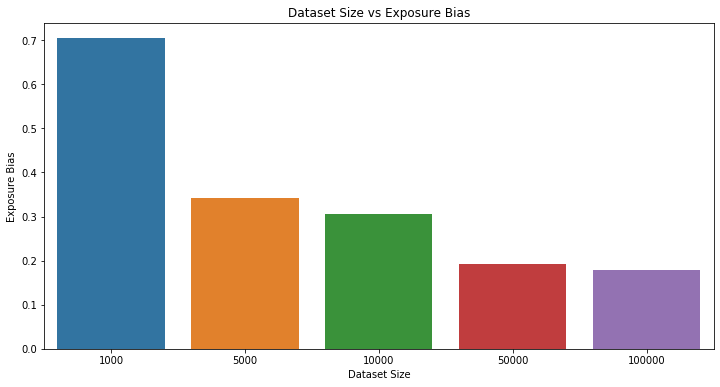

In [5]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(data=dataset_exp_results, ax=ax1)

plt.title('Dataset Size vs Exposure Bias')
ax1.set_xlabel('Dataset Size')
ax1.set_ylabel('Exposure Bias')



# Validation Experiments

In [ ]:
import glob
import json
import numpy as np

validation_exp_results = {}
for num_run in range(num_sample_oracles):
    serialization_dir = os.path.join(serialization_dir, 'validation_experiments', str(num_run))
    sample_oracle_args = get_args(args=['sample-oracle', param_path, '-s', serialization_dir])
    oracle_train_filename, oracle_dev_filename = sample_oracle_runner(sample_oracle_args, 
                                                                      serialization_dir);

    os.environ['ARTIFICIAL_GRAMMAR_TRAIN'] = oracle_train_filename
    os.environ['ARTIFICIAL_GRAMMAR_DEV'] = oracle_dev_filename

    train_args = get_args(args=['train' , param_path, '-s', serialization_dir])
    trainer_params = Params.from_file(train_args.param_path, train_args.overrides)
    cuda_device = trainer_params['trainer']['cuda_device']
    train_model_serialization_dir = train_runner(train_args, 
                                                 serialization_dir);

    archive_file = os.path.join(train_model_serialization_dir, 'model.tar.gz')
    for epoch in range(len(glob.glob(os.path.join(train_model_serialization_dir + '/model_state_epoch_*.th')))):
        qeb_output_dir = os.path.join(serialization_dir, 'exp_bias', 'epoch_' + str(epoch))
        
        # TODO(Kushal): Clean this up.
        validation_ppl = json.load(open(os.path.join(train_model_serialization_dir, f'metrics_epoch_{epoch}.json')))['validation_perplexity']

        weights_file = os.path.join(train_model_serialization_dir, f'model_state_epoch_{epoch}.th')
        qeb_args = get_args(args=['quantify-exposure-bias', archive_file, '--output-dir', qeb_output_dir, '--weights-file', weights_file])
        exp_biases, exp_bias_mean, exp_bias_std = quantify_exposure_bias_runner(qeb_args, 
                                                                                archive_file,
                                                                                qeb_output_dir,
                                                                                cuda_device=cuda_device,
                                                                                weights_file=weights_file,
                                                                                num_trials=num_trials,
                                                                                num_samples_per_length=num_samples_per_length);
        if epoch not in validation_exp_results:
            validation_exp_results[epoch] = {
                                                'exp_biases': exp_biases,
                                                'val_ppl': [validation_ppl],
                                                'exp_mean': [exp_bias_mean],
                                                'exp_std': [exp_bias_std]
                                            }
        else:
            validation_exp_results[epoch]['exp_biases'].extend(exp_biases)
            validation_exp_results[epoch]['val_ppl'].append(validation_ppl)

2019-10-11 11:54:34,265 - INFO - allennlp.common.params - random_seed = 13370
2019-10-11 11:54:34,267 - INFO - allennlp.common.params - numpy_seed = 1337
2019-10-11 11:54:34,268 - INFO - allennlp.common.params - pytorch_seed = 133
2019-10-11 11:54:36,711 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-11 11:54:36,719 - INFO - quant_exp_bias.commands.sample_oracle - Num Samples: 10000
2019-10-11 11:54:36,744 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.002

2019-10-11 11:54:45,648 - INFO - allennlp.common.params - vocabulary.tokens_to_add = None
2019-10-11 11:54:45,649 - INFO - allennlp.data.vocabulary - Fitting token dictionary from dataset.
0it [00:00, ?it/s]
2019-10-11 11:54:45,652 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/oracle_samples-train.txt
2019-10-11 11:54:48,325 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/oracle_samples-train.txt.
2019-10-11 11:54:48,327 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/oracle_samples-dev.txt
2019-10-11 11:54:48,721 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/oracle

2019-10-11 11:54:48,780 - INFO - allennlp.training.trainer_pieces - _decoder_cell.weight_hh
2019-10-11 11:54:48,781 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_ih
2019-10-11 11:54:48,782 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_hh
2019-10-11 11:54:48,783 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.weight
2019-10-11 11:54:48,785 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.bias
2019-10-11 11:54:48,786 - INFO - allennlp.common.params - trainer.patience = 5
2019-10-11 11:54:48,787 - INFO - allennlp.common.params - trainer.validation_metric = -loss
2019-10-11 11:54:48,789 - INFO - allennlp.common.params - trainer.shuffle = True
2019-10-11 11:54:48,790 - INFO - allennlp.common.params - trainer.num_epochs = 50
2019-10-11 11:54:48,791 - INFO - allennlp.common.params - trainer.cuda_device = 0
2019-10-11 11:54:48,792 - INFO - allennlp.common.params - trainer.grad_norm = None
2019-10-11 11:54:48,794 - INFO 

2019-10-11 11:55:09,244 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 0
2019-10-11 11:55:09,246 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 11:55:09,248 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/oracle_samples-train.txt
2019-10-11 11:55:09,446 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-11 11:55:17,093 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/oracle_samples-train.txt.
perplexity: 2.9935, loss: 1.0964 ||: : 36it [00:07,  4.52it/s]

2019-10-11 11:55:17,209 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 11:55:17,212 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artific

2019-10-11 11:55:29,882 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-11 11:55:37,272 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/oracle_samples-train.txt.
perplexity: 2.9797, loss: 1.0918 ||: : 36it [00:07,  4.69it/s]

2019-10-11 11:55:37,378 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 11:55:37,381 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/oracle_samples-dev.txt
2019-10-11 11:55:38,015 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/oracle_samples-dev.txt.
perplexity: 2.9411, loss: 1.0788 ||: : 5it [00:00,  7.57it/s]

2019-10-11 11:55:38,043 - INFO - allennlp.tr

  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 11:55:56,986 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/oracle_samples-dev.txt
2019-10-11 11:55:57,594 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/oracle_samples-dev.txt.
perplexity: 2.9375, loss: 1.0776 ||: : 5it [00:00,  7.94it/s]

2019-10-11 11:55:57,618 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-11 11:55:57,619 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |  7397.000  |       N/A
2019-10-11 11:55:57,621 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |     0.000  |       N/A
2019-10-11 11:55:57,622 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7719.000  |       N/A
2019-10-11 11:55:57,623 - INFO - allennlp.

2019-10-11 11:56:17,778 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |  7421.000  |       N/A
2019-10-11 11:56:17,779 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |     0.000  |       N/A
2019-10-11 11:56:17,780 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  7719.000  |       N/A
2019-10-11 11:56:17,782 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  7077.000  |       N/A
2019-10-11 11:56:17,783 - INFO - allennlp.training.tensorboard_writer - loss            |     1.090  |     1.077
2019-10-11 11:56:17,785 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  7655.000  |       N/A
2019-10-11 11:56:17,786 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |   911.000  |       N/A
2019-10-11 11:56:17,787 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  3309.000  |       N/A
2019-10-11 11:56:17,788 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |     0.

2019-10-11 11:56:37,446 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |   911.000  |       N/A
2019-10-11 11:56:37,447 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  2411.000  |       N/A
2019-10-11 11:56:37,449 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |     0.000  |       N/A
2019-10-11 11:56:37,450 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2608.828  |       N/A
2019-10-11 11:56:37,451 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.972  |     2.937
2019-10-11 11:56:37,482 - INFO - allennlp.training.trainer - Epoch duration: 0:00:09.926308
2019-10-11 11:56:37,483 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:06:53
2019-10-11 11:56:37,484 - INFO - allennlp.training.trainer - Epoch 10/49
2019-10-11 11:56:37,486 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2608.828
2019-10-11 11:56:38,942 - INFO - allennlp.training.trainer - GPU 0 mem

2019-10-11 11:56:55,760 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2608.832
2019-10-11 11:56:57,309 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7719
2019-10-11 11:56:57,311 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 7421
2019-10-11 11:56:57,311 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7077
2019-10-11 11:56:57,312 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 7665
2019-10-11 11:56:57,313 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 911
2019-10-11 11:56:57,313 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 2385
2019-10-11 11:56:57,314 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 0
2019-10-11 11:56:57,315 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 0
2019-10-11 11:56:57,316 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 11:56:57,318 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading

2019-10-11 11:57:10,798 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   5 :: exposure_bias: 0.40
2019-10-11 11:57:12,133 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   6 :: exposure_bias: 0.32
2019-10-11 11:57:13,456 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   7 :: exposure_bias: 0.14
2019-10-11 11:57:14,729 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   8 :: exposure_bias: 0.45
2019-10-11 11:57:15,754 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   9 :: exposure_bias: 0.31
2019-10-11 11:57:16,996 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:  10 :: exposure_bias: 0.32
2019-10-11 11:57:17,003 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Exposure Bias Average:
2019-10-11 11:57:17,004 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 mean: 0.33
2019-10-11 11:57:17,006 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 std:  0.09
2019-10-1

2019-10-11 11:57:30,104 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

2019-10-11 11:57:40,574 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-11 11:57:40,584 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-11 11:57:40,586 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Metrics:
2019-10-11 11:57:41,495 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   1 :: exposure_bias: 0.28
2019-10-11 11:57:42,607 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   2 :: exposure_bias: 0.24
2019-10-11 11:57:43,429 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   3 :: exposure_bias: 0.44
2019-10-11 11:57:44,328 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   4 :: exposure_bias: 0.36
2019-10-11 11:57:45,503 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   5 :: exposure_bias: 0.31
2019-10-11 11:57:46,398 - INFO - quant_exp_bias.commands.quantify_exp

2019-10-11 11:58:00,274 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'type': 'quant_exp_lm', 'use_bleu': False} and extras {'vocab'}
2019-10-

2019-10-11 11:58:10,021 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True} and extras {'vocab'}
2019-10-11 11:58:10,030 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-11 11:58:10,044 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-11 11

2019-10-11 11:58:30,108 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 mean: 0.32
2019-10-11 11:58:30,109 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 std:  0.07
2019-10-11 11:58:30,111 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Done!!
2019-10-11 11:58:30,135 - INFO - allennlp.models.archival - loading archive file results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/train_output/model.tar.gz
2019-10-11 11:58:30,136 - INFO - allennlp.models.archival - extracting archive file results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/train_output/model.tar.gz to temp dir /tmp/tmpphwhwo5w
2019-10-11 11:58:30,217 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmpphwhwo5w/vocabulary.
2019-10-11 11:58:30,219 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 

2019-10-11 11:58:40,536 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras {'vocab'}
2019-10-11 11:58:40,537 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' 

2019-10-11 11:58:56,872 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   6 :: exposure_bias: 0.16
2019-10-11 11:58:58,007 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   7 :: exposure_bias: 0.39
2019-10-11 11:58:58,853 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   8 :: exposure_bias: 0.36
2019-10-11 11:58:59,798 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   9 :: exposure_bias: 0.38
2019-10-11 11:59:00,882 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:  10 :: exposure_bias: 0.28
2019-10-11 11:59:00,887 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Exposure Bias Average:
2019-10-11 11:59:00,888 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 mean: 0.32
2019-10-11 11:59:00,889 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 std:  0.07
2019-10-11 11:59:00,890 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Done!!
2019-10-11 11:59:00,902 - INFO - all

2019-10-11 11:59:11,306 - INFO - quant_exp_bias.commands.sample_oracle - writing the oracle samples to results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/oracle_samples.txt.
2019-10-11 11:59:13,610 - INFO - quant_exp_bias.commands.sample_oracle - done creating oracle samples
2019-10-11 11:59:13,719 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-11 11:59:13,723 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.data.dataset_readers.dataset_reader.DatasetReader'> from params {'end_tokens': ['</S>'], 'start_tokens': ['<S>'], 'token_indexers': {'tokens': {'namespace': 'target_tokens', 'type': 'single_id'}}, 'type': 'quant_exp_language_modeling'} and extras set()
2019-10-11 11:59:13,724 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.dataset_readers.language_modeling.LanguageModelingDatasetReader'> from params {'end_tokens': ['</S>'], 'start_tokens': ['<S>'], 'token_ind

2019-10-11 11:59:16,975 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.bias
2019-10-11 11:59:16,978 - INFO - allennlp.training.optimizers - Number of trainable parameters: 727809
2019-10-11 11:59:16,988 - INFO - allennlp.training.trainer - Beginning training.
2019-10-11 11:59:16,989 - INFO - allennlp.training.trainer - Epoch 0/49
2019-10-11 11:59:16,990 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2681.028
2019-10-11 11:59:18,142 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 6579
2019-10-11 11:59:18,145 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 6123
2019-10-11 11:59:18,146 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 4397
2019-10-11 11:59:18,147 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 5871
2019-10-11 11:59:18,148 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 1951
2019-10-11 11:59:18,149 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 2555
2019-10-11 11:59

2019-10-11 11:59:36,902 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:07:57
2019-10-11 11:59:36,903 - INFO - allennlp.training.trainer - Epoch 2/49
2019-10-11 11:59:36,904 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2681.028
2019-10-11 11:59:38,282 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7603
2019-10-11 11:59:38,284 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 7411
2019-10-11 11:59:38,285 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7073
2019-10-11 11:59:38,287 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 7665
2019-10-11 11:59:38,288 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 1979
2019-10-11 11:59:38,289 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 3867
2019-10-11 11:59:38,290 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 0
2019-10-11 11:59:38,292 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 0
2019-10-11 11:59:38,29

2019-10-11 11:59:58,487 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 1979
2019-10-11 11:59:58,489 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 3877
2019-10-11 11:59:58,490 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 0
2019-10-11 11:59:58,490 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 0
2019-10-11 11:59:58,492 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 11:59:58,494 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/oracle_samples-train.txt
2019-10-11 11:59:58,700 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-11 12:00:05,882 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/ora

2019-10-11 12:00:18,751 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 0
2019-10-11 12:00:18,752 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 0
2019-10-11 12:00:18,753 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 12:00:18,756 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/oracle_samples-train.txt
2019-10-11 12:00:18,994 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-11 12:00:26,725 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/oracle_samples-train.txt.
perplexity: 2.9446, loss: 1.0800 ||: : 36it [00:08,  4.49it/s]

2019-10-11 12:00:26,770 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/

2019-10-11 12:00:39,367 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-11 12:00:46,770 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/oracle_samples-train.txt.
perplexity: 2.9408, loss: 1.0787 ||: : 36it [00:07,  4.68it/s]

2019-10-11 12:00:46,823 - INFO - allennlp.training.trainer - Validating
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 12:00:46,825 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/oracle_samples-dev.txt
2019-10-11 12:00:47,570 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/oracle_samples-dev.txt.
perplexity: 2.8917, loss: 1.0618

2019-10-11 12:01:06,315 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances dropped from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/oracle_samples-dev.txt.
perplexity: 2.8916, loss: 1.0618 ||: : 5it [00:00,  7.98it/s]

2019-10-11 12:01:06,325 - INFO - allennlp.training.tensorboard_writer -                     Training |  Validation
2019-10-11 12:01:06,327 - INFO - allennlp.training.tensorboard_writer - gpu_1_memory_MB |  4573.000  |       N/A
2019-10-11 12:01:06,328 - INFO - allennlp.training.tensorboard_writer - gpu_6_memory_MB |     0.000  |       N/A
2019-10-11 12:01:06,330 - INFO - allennlp.training.tensorboard_writer - gpu_0_memory_MB |  6067.000  |       N/A
2019-10-11 12:01:06,331 - INFO - allennlp.training.tensorboard_writer - gpu_2_memory_MB |  4407.000  |       N/A
2019-10-11 12:01:06,332 - INFO - allennlp.training.tensorboard_writer - loss            |     1.079  |     1.062
2019-10-11 12:01:06,334 - 

2019-10-11 12:01:17,173 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True} and extras {'vocab'}
2019-10-11 12:01:17,184 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-11 12:01:17,196 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-11 12

2019-10-11 12:01:34,460 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 mean: 0.38
2019-10-11 12:01:34,462 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 std:  0.08
2019-10-11 12:01:34,463 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Done!!
2019-10-11 12:01:34,478 - INFO - allennlp.models.archival - loading archive file results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/train_output/model.tar.gz
2019-10-11 12:01:34,479 - INFO - allennlp.models.archival - extracting archive file results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/train_output/model.tar.gz to temp dir /tmp/tmp6_xlf9dq
2019-10-11 12:01:34,543 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmp6_xlf9dq/vocabulary.
2019-10-11 12:01:34,545 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0

2019-10-11 12:01:43,373 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras {'vocab'}
2019-10-11 12:01:43,374 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' 

2019-10-11 12:01:59,934 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   6 :: exposure_bias: 0.31
2019-10-11 12:02:00,858 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   7 :: exposure_bias: 0.27
2019-10-11 12:02:01,763 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   8 :: exposure_bias: 0.25
2019-10-11 12:02:02,644 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   9 :: exposure_bias: 0.28
2019-10-11 12:02:03,836 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:  10 :: exposure_bias: 0.29
2019-10-11 12:02:03,842 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Exposure Bias Average:
2019-10-11 12:02:03,843 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 mean: 0.29
2019-10-11 12:02:03,844 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 std:  0.05
2019-10-11 12:02:03,845 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Done!!
2019-10-11 12:02:03,860 - INFO - all

2019-10-11 12:02:14,273 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

2019-10-11 12:02:24,322 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-11 12:02:24,331 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-11 12:02:24,332 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Metrics:
2019-10-11 12:02:25,291 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   1 :: exposure_bias: 0.30
2019-10-11 12:02:26,321 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   2 :: exposure_bias: 0.30
2019-10-11 12:02:27,181 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   3 :: exposure_bias: 0.44
2019-10-11 12:02:28,193 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   4 :: exposure_bias: 0.32
2019-10-11 12:02:29,200 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   5 :: exposure_bias: 0.24
2019-10-11 12:02:30,052 - INFO - quant_exp_bias.commands.quantify_exp

2019-10-11 12:02:44,278 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmpizrireeh/vocabulary.
2019-10-11 12:02:44,281 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespac

2019-10-11 12:02:54,241 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True} and extras {'vocab'}
2019-10-11 12:02:54,253 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-11 12:02:54,263 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-11 12

2019-10-11 12:03:10,286 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

2019-10-11 12:03:19,613 - INFO - allennlp.training.trainer - Epoch 1/49
2019-10-11 12:03:19,614 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2741.256
2019-10-11 12:03:20,685 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7603
2019-10-11 12:03:20,687 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 7429
2019-10-11 12:03:20,688 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7087
2019-10-11 12:03:20,690 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 7761
2019-10-11 12:03:20,691 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 1979
2019-10-11 12:03:20,692 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 4267
2019-10-11 12:03:20,693 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 0
2019-10-11 12:03:20,695 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 0
2019-10-11 12:03:20,696 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 12:03:2

2019-10-11 12:03:39,413 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:07:35
2019-10-11 12:03:39,414 - INFO - allennlp.training.trainer - Epoch 3/49
2019-10-11 12:03:39,414 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2741.256
2019-10-11 12:03:40,884 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7603
2019-10-11 12:03:40,886 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 7429
2019-10-11 12:03:40,887 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7087
2019-10-11 12:03:40,887 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 7761
2019-10-11 12:03:40,888 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 1979
2019-10-11 12:03:40,888 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 3423
2019-10-11 12:03:40,889 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 0
2019-10-11 12:03:40,891 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 0
2019-10-11 12:03:40,89

2019-10-11 12:03:59,477 - INFO - allennlp.training.trainer - Epoch duration: 0:00:09.797746
2019-10-11 12:03:59,479 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:07:22
2019-10-11 12:03:59,482 - INFO - allennlp.training.trainer - Epoch 5/49
2019-10-11 12:03:59,485 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2741.256
2019-10-11 12:04:00,863 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7603
2019-10-11 12:04:00,865 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 7429
2019-10-11 12:04:00,866 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 7087
2019-10-11 12:04:00,867 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 7761
2019-10-11 12:04:00,868 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 1979
2019-10-11 12:04:00,869 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 4367
2019-10-11 12:04:00,869 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 0
2019-10-11 12:04

2019-10-11 12:04:18,087 - INFO - allennlp.training.trainer - Epoch 7/49
2019-10-11 12:04:18,088 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2741.256
2019-10-11 12:04:19,034 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 5811
2019-10-11 12:04:19,036 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 4583
2019-10-11 12:04:19,037 - INFO - allennlp.training.trainer - GPU 2 memory usage MB: 4413
2019-10-11 12:04:19,038 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6279
2019-10-11 12:04:19,040 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 1979
2019-10-11 12:04:19,041 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 3741
2019-10-11 12:04:19,042 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 0
2019-10-11 12:04:19,043 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 0
2019-10-11 12:04:19,045 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 12:04:1

2019-10-11 12:04:38,962 - INFO - allennlp.training.trainer - GPU 3 memory usage MB: 6899
2019-10-11 12:04:38,963 - INFO - allennlp.training.trainer - GPU 4 memory usage MB: 1979
2019-10-11 12:04:38,964 - INFO - allennlp.training.trainer - GPU 5 memory usage MB: 4487
2019-10-11 12:04:38,965 - INFO - allennlp.training.trainer - GPU 6 memory usage MB: 0
2019-10-11 12:04:38,966 - INFO - allennlp.training.trainer - GPU 7 memory usage MB: 0
2019-10-11 12:04:38,967 - INFO - allennlp.training.trainer - Training
  0%|          | 0/1 [00:00<?, ?it/s]
2019-10-11 12:04:38,970 - INFO - quant_exp_bias.dataset_readers.language_modeling - Loading data from results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/validation_experiments/2/oracle_samples-train.txt
2019-10-11 12:04:39,167 - INFO - allennlp.training.trainer - current batch size: 256 mean batch size: 256.0
2019-10-11 12:04:46,642 - INFO - quant_exp_bias.dataset_readers.language_modeling - No instances

2019-10-11 12:04:56,699 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.models.lms.unconditioned_lm.LMQuantExpModel'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespace': 'target_tokens', 'target_output_dim': 300, 'use_bleu': False} and extras {'vocab'}
2

2019-10-11 12:05:07,699 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-11 12:05:07,709 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-11 12:05:07,710 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Metrics:
2019-10-11 12:05:08,727 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   1 :: exposure_bias: 0.29
2019-10-11 12:05:09,648 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   2 :: exposure_bias: 0.37
2019-10-11 12:05:10,709 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   3 :: exposure_bias: 0.47
2019-10-11 12:05:11,948 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   4 :: exposure_bias: 0.23
2019-10-11 12:05:12,958 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   5 :: exposure_bias: 0.36
2019-10-11 12:05:13,908 - INFO - quant_exp_bias.commands.quantify_exp

2019-10-11 12:05:28,281 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmphx14xbgq/vocabulary.
2019-10-11 12:05:28,283 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model.Model'> from params {'beam_size': 1, 'dropout': 0.5, 'end_token': '</S>', 'generation_batch_size': 32, 'max_decoding_steps': 50, 'oracle': {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'}, 'start_token': '<S>', 'target_embedding_dim': 300, 'target_namespac

2019-10-11 12:05:38,413 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True} and extras {'vocab'}
2019-10-11 12:05:38,421 - INFO - root - Loading a model trained before embedding extension was implemented; pass an explicit vocab namespace if you want to extend the vocabulary.
2019-10-11 12:05:38,430 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-11 12

2019-10-11 12:05:58,256 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 mean: 0.32
2019-10-11 12:05:58,258 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 std:  0.06
2019-10-11 12:05:58,259 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Done!!
2019-10-11 12:05:58,276 - INFO - allennlp.models.archival - loading archive file results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/validation_experiments/2/train_output/model.tar.gz
2019-10-11 12:05:58,277 - INFO - allennlp.models.archival - extracting archive file results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/validation_experiments/2/train_output/model.tar.gz to temp dir /tmp/tmpxbgvsetw
2019-10-11 12:05:58,361 - INFO - allennlp.data.vocabulary - Loading token dictionary from /tmp/tmpxbgvsetw/vocabulary.
2019-10-11 12:05:58,363 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.models.model

2019-10-11 12:06:08,609 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.oracle_base.Oracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' q1 [0.0025] | 'c' q1 [0.0025] | 'E' q1 [0.0025]\n                        q1 -> 'S' q1 [0.0025] | 'a' q1 [0.3000] | 'b' q1 [0.3000] | 'c' q1 [0.3000] | 'E' q1 [0.0025]\n                        q1 -> 'S' q2 [0.0025] | 'a' q2 [0.0300] | 'b' q2 [0.0300] | 'c' q2 [0.0300] | 'E' q2 [0.0025]\n                        q2 -> 'S' [0.0025] | 'a' [0.0025] | 'b' [0.0025] | 'c' [0.0025] | 'E' [0.9900]\n                    ", 'parallelize': True, 'type': 'artificial_lang_oracle'} and extras {'vocab'}
2019-10-11 12:06:08,610 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.oracles.artificial_grammar_oracle.ArtificialLanguageOracle'> from params {'grammar_string': "\n                        q0 -> 'S' q1 [0.9900] | 'a' q1 [0.0025] | 'b' 

2019-10-11 12:06:23,947 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   5 :: exposure_bias: 0.27
2019-10-11 12:06:24,838 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   6 :: exposure_bias: 0.30
2019-10-11 12:06:25,748 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   7 :: exposure_bias: 0.34
2019-10-11 12:06:26,709 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   8 :: exposure_bias: 0.30
2019-10-11 12:06:27,641 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:   9 :: exposure_bias: 0.27
2019-10-11 12:06:28,698 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Trial:  10 :: exposure_bias: 0.29
2019-10-11 12:06:28,704 - INFO - quant_exp_bias.commands.quantify_exposure_bias - Exposure Bias Average:
2019-10-11 12:06:28,704 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 mean: 0.31
2019-10-11 12:06:28,705 - INFO - quant_exp_bias.commands.quantify_exposure_bias - 	 std:  0.05
2019-10-1

2019-10-11 12:06:38,967 - INFO - quant_exp_bias.commands.sample_oracle - writing the oracle samples to results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/validation_experiments/2/validation_experiments/3/oracle_samples.txt.
2019-10-11 12:06:41,392 - INFO - quant_exp_bias.commands.sample_oracle - done creating oracle samples
2019-10-11 12:06:41,497 - INFO - allennlp.common.checks - Pytorch version: 1.1.0
2019-10-11 12:06:41,501 - INFO - allennlp.common.from_params - instantiating class <class 'allennlp.data.dataset_readers.dataset_reader.DatasetReader'> from params {'end_tokens': ['</S>'], 'start_tokens': ['<S>'], 'token_indexers': {'tokens': {'namespace': 'target_tokens', 'type': 'single_id'}}, 'type': 'quant_exp_language_modeling'} and extras set()
2019-10-11 12:06:41,503 - INFO - allennlp.common.from_params - instantiating class <class 'quant_exp_bias.dataset_readers.language_modeling.LanguageModelingDatasetReader'> from params {'end_toke

2019-10-11 12:06:44,751 - INFO - allennlp.training.trainer_pieces - _decoder_cell.weight_hh
2019-10-11 12:06:44,752 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_ih
2019-10-11 12:06:44,753 - INFO - allennlp.training.trainer_pieces - _decoder_cell.bias_hh
2019-10-11 12:06:44,754 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.weight
2019-10-11 12:06:44,755 - INFO - allennlp.training.trainer_pieces - _output_projection_layer.bias
2019-10-11 12:06:44,757 - INFO - allennlp.training.optimizers - Number of trainable parameters: 727809
2019-10-11 12:06:44,762 - INFO - allennlp.training.trainer - Beginning training.
2019-10-11 12:06:44,763 - INFO - allennlp.training.trainer - Epoch 0/49
2019-10-11 12:06:44,764 - INFO - allennlp.training.trainer - Peak CPU memory usage MB: 2796.952
2019-10-11 12:06:46,277 - INFO - allennlp.training.trainer - GPU 0 memory usage MB: 7719
2019-10-11 12:06:46,279 - INFO - allennlp.training.trainer - GPU 1 memory usage MB: 7413


2019-10-11 12:07:02,812 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  4791.000  |       N/A
2019-10-11 12:07:02,814 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |     0.000  |       N/A
2019-10-11 12:07:02,815 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2796.952  |       N/A
2019-10-11 12:07:02,817 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.995  |     2.955
2019-10-11 12:07:02,845 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/validation_experiments/2/validation_experiments/3/train_output/best.th'.
2019-10-11 12:07:02,856 - INFO - allennlp.training.trainer - Epoch duration: 0:00:08.572144
2019-10-11 12:07:02,857 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:07:14
2019-10-11 12:07:02,859 - INFO - allennlp.training.trainer -

2019-10-11 12:07:20,931 - INFO - allennlp.training.tensorboard_writer - loss            |     1.090  |     1.085
2019-10-11 12:07:20,933 - INFO - allennlp.training.tensorboard_writer - gpu_3_memory_MB |  7639.000  |       N/A
2019-10-11 12:07:20,934 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |  1979.000  |       N/A
2019-10-11 12:07:20,936 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  4823.000  |       N/A
2019-10-11 12:07:20,937 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |     0.000  |       N/A
2019-10-11 12:07:20,939 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2796.952  |       N/A
2019-10-11 12:07:20,940 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.973  |     2.959
2019-10-11 12:07:20,969 - INFO - allennlp.training.trainer - Epoch duration: 0:00:08.756389
2019-10-11 12:07:20,971 - INFO - allennlp.training.trainer - Estimated training time remaining: 0:06:56
2019-10-11 12

2019-10-11 12:07:37,415 - INFO - allennlp.training.tensorboard_writer - gpu_4_memory_MB |  1979.000  |       N/A
2019-10-11 12:07:37,416 - INFO - allennlp.training.tensorboard_writer - gpu_5_memory_MB |  4859.000  |       N/A
2019-10-11 12:07:37,418 - INFO - allennlp.training.tensorboard_writer - gpu_7_memory_MB |     0.000  |       N/A
2019-10-11 12:07:37,419 - INFO - allennlp.training.tensorboard_writer - cpu_memory_MB   |  2796.952  |       N/A
2019-10-11 12:07:37,421 - INFO - allennlp.training.tensorboard_writer - perplexity      |     2.970  |     2.952
2019-10-11 12:07:37,442 - INFO - allennlp.training.checkpointer - Best validation performance so far. Copying weights to 'results/artificial_grammar/10_11_2019_11_54_33/validation_experiments/0/validation_experiments/1/validation_experiments/2/validation_experiments/3/train_output/best.th'.
2019-10-11 12:07:37,451 - INFO - allennlp.training.trainer - Epoch duration: 0:00:07.993759
2019-10-11 12:07:37,452 - INFO - allennlp.training.

In [ ]:
for epoch in validation_exp_results:
    validation_exp_results[epoch]['exp_biases'] = np.mean(validation_exp_results[epoch]['exp_biases'], dtype=float)
    validation_exp_results[epoch]['val_ppl'] = np.mean(validation_exp_results[epoch]['val_ppl'], dtype=float)
validation_exp_results = pd.DataFrame(validation_exp_results).T
validation_exp_results

In [ ]:
validation_exp_results.exp_biases = validation_exp_results.exp_biases.astype(float)
validation_exp_results.val_ppl = validation_exp_results.val_ppl.astype(float)

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = plt.twinx()


sns.lineplot(data=validation_exp_results.exp_biases, color='g', ax=ax1)
sns.lineplot(data=validation_exp_results.val_ppl, color='b', ax=ax2)

plt.title('Epochs vs Validation PPL vs Exposure Bias')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Exposure Bias')
ax2.set_ylabel('Validation PPL')

fig.legend(['val_ppl', 'exp_biases'])


# Model Size Experiments

# Beam Search Experiments